# Bottled Gazpacho Market Research 3 (0 - 4 scale)

I don't know about you, but I love Gazpacho. In Spain they sell those delicacies bottled in supermarkets. But what about the rest of the world? How sad I am eveytime I go to the supermarket and none of that elixir is available. Here's the wonderful sight that Spaniards take for granted, while everyone else can only dream of:

![gazpacho](./images/spanish_bottled_gazpacho.jpg)

No more! This stops here! Or so I hope. Let's perform some **simulated market research** to find out if there is a market for Gazpacho in the rest of the world.

In [1]:
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, '..')

import tinytroupe
from tinytroupe import config_manager
from tinytroupe.agent import TinyPerson
from tinytroupe.environment import TinyWorld
from tinytroupe.factory import TinyPersonFactory
from tinytroupe.validation import TinyPersonValidator
from tinytroupe import control

from tinytroupe.extraction import ResultsExtractor
from tinytroupe.profiling import Profiler


!!!!
DISCLAIMER: TinyTroupe relies on Artificial Intelligence (AI) models to generate content. 
The AI models are not perfect and may produce inappropriate or inacurate results. 
For any serious or consequential use, please review the generated content before using it.
!!!!

Looking for default config on: C:\Users\pdasilva\repos\TinyTroupe\examples\..\tinytroupe\utils\..\config.ini
Found custom config on: C:\Users\pdasilva\repos\TinyTroupe\examples\config.ini
TinyTroupe version: 0.5.1
Current date and time (local): 2025-07-26 13:10:49
Current date and time (UTC):   2025-07-26 16:10:49

Current TinyTroupe configuration 
[OpenAI]
api_type = openai
azure_api_version = 2024-08-01-preview
model = gpt-4.1-mini
reasoning_model = o3-mini
embedding_model = text-embedding-3-small
max_tokens = 32000
temperature = 1.5
freq_penalty = 0.1
presence_penalty = 0.1
timeout = 480
max_attempts = 5
waiting_time = 0
exponential_backoff_factor = 5
reasoning_effort = high
cache_api_calls = False
cache_file_n

In [2]:
config_manager.update("action_generator_enable_quality_checks", True)
config_manager.update("action_generator_quality_threshold", 6)

First of all, we'll use a cached simulation, to avoid having to recompute expensive steps unless really necessary. We accomplish this via the `control.begin()` function. The file it takes as an argument is the cache file that will be created and then updated as needed.

**Tip:** the ".cache." naming convention is used to indicate that the file is a cache file and will not be committed to the repository.

In [3]:
#control.begin("bottled_gazpacho_market_research_3.cache.json")

## Prepare the survey and auxiliary elements

Main target nationality and population size.

In [4]:
target_nationality = "American"
population_size = 50

additional_demographic_specification = f"""
BESIDES other dimensions infered from the population demographic data (i.e., make sure those are still present), 
ensure these ADDITIONAL sampling dimensions are present, which must be as realistic as possible:
  - general attitude: from positive to negative, from optimistic to pessimistic, from open-minded to closed-minded
  - education: from the completely illiterate (can't even talk properly) to the highest scientist
  - culinary tastes: from traditional to modern, from spicy to mild, from vegetarian to meat-based
  - shopping habits: from frequent to occasional, from online to in-store, from frugal to extravagant
  - health consciousness: from health-focused to indulgent, from organic to conventional
  - attitude towards new products: from open-minded to skeptical, from adventurous to conservative
  - cultural influences: from local to global, from traditional to contemporary, from diverse to homogeneous
  - travel habits: from frequent travelers to homebodies, from local to international, from adventurous to cautious
  - cultural background: from diverse to homogeneous, from traditional to modern, from local to global
  - lifestyle: from active to sedentary, from urban to rural, from minimalist to extravagant

Each of these additional dimensions MUST have AT LEAST 10 values. 
For all of these, YOU MUST provide long, detailed sentences that describe the values in each dimension. NOT short
words. We need EACH value to be VERY detailed.

Make sure you also include EXTREME values so that we can properly capture even edge cases. We want a WIDE
range of different people and tastes!
"""
  

Should we also compute the other nationalities? This might take a while, so we leave it as an option.

In [5]:
compute_other_nationalities = True

Descriptions and standard questions for the survey.

In [6]:
interviewer_introduction =\
    """
    We are performing some market research and need to know you more. 
    Can you please present yourself and also list your top-10 interests?
    """

interviewer_main_question =\
    """ 
    Gazpacho is a cold, blended vegetable soup originally from Spain, made mainly with tomatoes, cucumbers, peppers, and olive oil. 
    We are considering offering it in supermarkets near you.

    Would you consider purchasing ready-to-drink bottled gazpacho if it was available at your local supermarket? How much do you like this idea? 

    Please rate your propensity of purchasing it (from 1 to 5), where:
       - 1: would NEVER buy it. Note that IT IS OK to give this extreme and impulsive answer if it is how you feel, as it is part of the human experience.
       - 2: very unlikely, but not impossible.
       - 3: maybe I would buy it, not sure.
       - 4: it is very likely.
       - 5: would CERTAINLY buy it. Note that IT IS OK to give this extreme and impulsive answer if it is how you feel, as it is part of the human experience.
    """

inner_monologue =\
    """
    I will be honest as I understand they are not here to judge me, but just to learn from me. 
    Such choices depend on many factors, but I will make my best guess, considering my current 
    situation in life, location, job and interests. I will not refrain from giving extreme answers, 
    such as 1 or 5, if that's how I really feel, as this exercise requires me to be honest, human and realistic.

    Now I **must** first THINK deeply about the question, consider all the factors that might influence my decision,
    and only then I will TALK with my response to the question as best, as detailed and as honestly as I can.
    """

Common mechaniss.

In [7]:
results_extractor = ResultsExtractor(extraction_objective="Find whether the person would buy the product. A person rate his/her propensity from 1 (would NEVER buy) to 5 (would CERTAINLY buy it)." ,
                                     situation="Agent was asked to rate their interest in a bottled Gazpacho. They can respond with a propensity score from 1 (would NEVER buy) to 5 (would CERTAINLY buy it).", 
                                     fields=["response", "justification"],
                                     fields_hints={"response": "Must be a string formatted exactly as '1', '2', '3', '4', '5' or 'N/A'(if there is no response or you cannot determine the precise response)."},
                                     verbose=True)

A function that will give us the statistics and then recommend us if we should go ahead and start a Gazpacho business.

In [8]:
def is_there_a_good_market(df, positive_threshold=0.1, negative_threshold=0.5):
    # Convert responses to strings for consistent handling
    df_copy = df.copy()
    df_copy["response"] = df_copy["response"].astype(str)
    
    # Get counts and calculate percentages
    counts = df_copy["response"].value_counts()
    total = counts.sum()
    percentage = counts / total
    
    # Calculate percentages by rating category (using 1-5 scale)
    percentage_positive = percentage.get("4", 0) + percentage.get("5", 0)
    percentage_neutral = percentage.get("3", 0)
    percentage_negative = percentage.get("1", 0) + percentage.get("2", 0)
    percentage_na = percentage.get("N/A", 0)
    
    # Print the analysis
    print(f"Percentage of positive responses (4-5): {percentage_positive:.2%}")
    print(f"Percentage of neutral responses (3): {percentage_neutral:.2%}")
    print(f"Percentage of negative responses (1-2): {percentage_negative:.2%}")
    print(f"Percentage of 'N/A' responses: {percentage_na:.2%}")

    # also compute the mean and standard deviation of the responses
    df_copy["response"] = pd.to_numeric(df_copy["response"], errors='coerce')
    mean_response = df_copy["response"].mean()
    std_response = df_copy["response"].std()

    print(f"Mean response: {mean_response:.2f}")
    print(f"Standard deviation of responses: {std_response:.2f}")

    # Decision based on thresholds
    if percentage_positive > positive_threshold and percentage_negative < negative_threshold:
        print("VERDICT: There is a good market for bottled gazpacho.")
        return True
    else:
        print("VERDICT: There is not a good market for bottled gazpacho.")
        return False



## Build the audience

Summon an audience out of thin simulated air. To do so, we build a factory whose context defines our problem and target audience. Actual agents will be later sampled from this factory.

In [9]:
factory = TinyPersonFactory.create_factory_from_demography("./information/populations/usa.json", 
                                                           population_size=population_size, 
                                                           additional_demographic_specification=additional_demographic_specification)

In [10]:
people = factory.generate_people(population_size, verbose=True)

2025-07-26 13:14:01,040 - tinytroupe - ERROR - Error occurred while extracting JSON: Expecting ',' delimiter: line 1 column 956 (char 955). Input text: [{"id":1,"subpopulation_description":"Young urban adults aged 25-54, diverse racial backgrounds, college-educated, middle income, with high openness and extraversion, politically Independent or Democrat, engaged in active lifestyles and cultural diversity.","sampled_values":{"age":[25,54],"gender":["Male individuals with a wide range of roles, identities, and experiences across the lifespan.","Female individuals encompassing diverse life experiences, roles, and identities across all ages."],"racial_and_ethnic_composition":["White (Non-Hispanic) individuals with varied cultural backgrounds, socioeconomic statuses, and regional identities.","Hispanic or Latino individuals representing diverse origins including Mexican, Puerto Rican, Cuban, and other Latin American heritages with rich cultural traditions.","Black or African American indivi

2025-07-26 13:21:10,369 - tinytroupe - ERROR - Could not generate person 44/50. Continuing with the remaining ones.


2025-07-26 13:21:10,371 - tinytroupe - ERROR - Could not generate person 42/50. Continuing with the remaining ones.


2025-07-26 13:21:10,373 - tinytroupe - ERROR - Could not generate person 46/50. Continuing with the remaining ones.


2025-07-26 13:21:10,373 - tinytroupe - ERROR - Could not generate person 47/50. Continuing with the remaining ones.


2025-07-26 13:21:10,375 - tinytroupe - ERROR - Could not generate person 49/50. Continuing with the remaining ones.


2025-07-26 13:21:10,376 - tinytroupe - ERROR - Could not generate person 50/50. Continuing with the remaining ones.


In [11]:
factory.sampling_dimensions

{'sampling_space_description': 'A detailed and comprehensive sampling space representing the diverse population of the United States of America, capturing demographic, socioeconomic, cultural, personality, political, and lifestyle characteristics with detailed, nuanced values and proportions as specified in the demographic data and directives.',
 'dimensions': [{'name': 'age',
   'values': {'Children aged 0 to 14 years, representing early childhood and pre-adolescence with diverse developmental stages and needs.': 0.186,
    'Adolescents and young adults aged 15 to 24 years, encompassing high school, college, and early career phases with evolving identities.': 0.131,
    'Adults aged 25 to 54 years, the largest working-age group engaged in career development, family formation, and social participation.': 0.394,
    'Older adults aged 55 to 64 years, approaching retirement with varied health statuses and life plans.': 0.129,
    'Seniors aged 65 years and older, including retirees with 

In [12]:
factory.sampling_plan

[{'id': 1,
  'subpopulation_description': 'Young urban professionals aged 25-34, predominantly White and Hispanic, with college education and middle to upper-middle income, living in Northeast and West regions, with high openness and conscientiousness.',
  'sampled_values': {'age': [25, 34],
   'gender': ['Male individuals with a wide range of roles, identities, and experiences across the lifespan.',
    'Female individuals encompassing diverse life experiences, roles, and identities across all ages.'],
   'racial_and_ethnic_composition': ['White (Non-Hispanic) individuals with varied cultural backgrounds, socioeconomic statuses, and regional identities.',
    'Hispanic or Latino individuals representing diverse origins including Mexican, Puerto Rican, Cuban, and other Latin American heritages with rich cultural traditions.'],
   'education': ["Bachelor's degree holders with specialized knowledge in a field of study.",
    'Individuals with some college education but no degree, includi

We can request a specific number of people.

A quick look into the folks that were created:

In [13]:
factory.generated_minibios

['Isabel Mariana Calderón-Sullivan is a 29 year old Financial Analyst, American, currently living in Brooklyn, New York, USA. Beyond her professional expertise, Isabel is a warm and empathetic individual who values meaningful connections and cultural heritage. She enjoys creative pursuits like cooking traditional and fusion recipes, salsa dancing, and photography, which help her unwind from work stress. Passionate about social justice and community empowerment, she actively volunteers to promote financial literacy and advocates for immigrant rights. Isabel’s disciplined yet adaptable nature, combined with her curiosity and resilience, supports both her career ambitions and her commitment to personal growth and balanced living.',
 'Esteban Miguel Calderón-Rivers is a 68 year old Retired Automotive Mechanic, American, currently living in San Antonio, Texas, USA. Esteban is a thoughtful and grounded individual who finds joy in simple, meaningful activities like gardening, cooking traditio

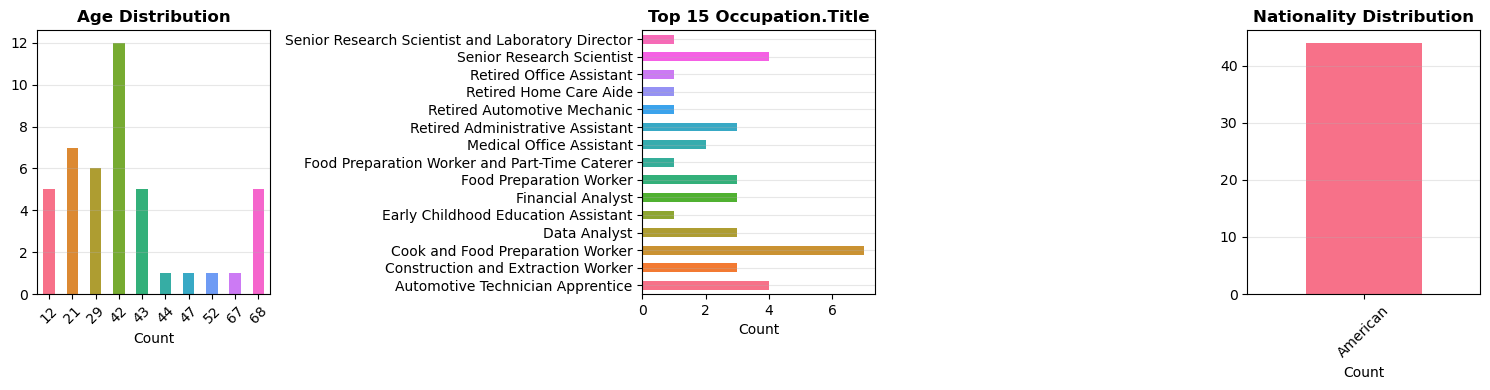

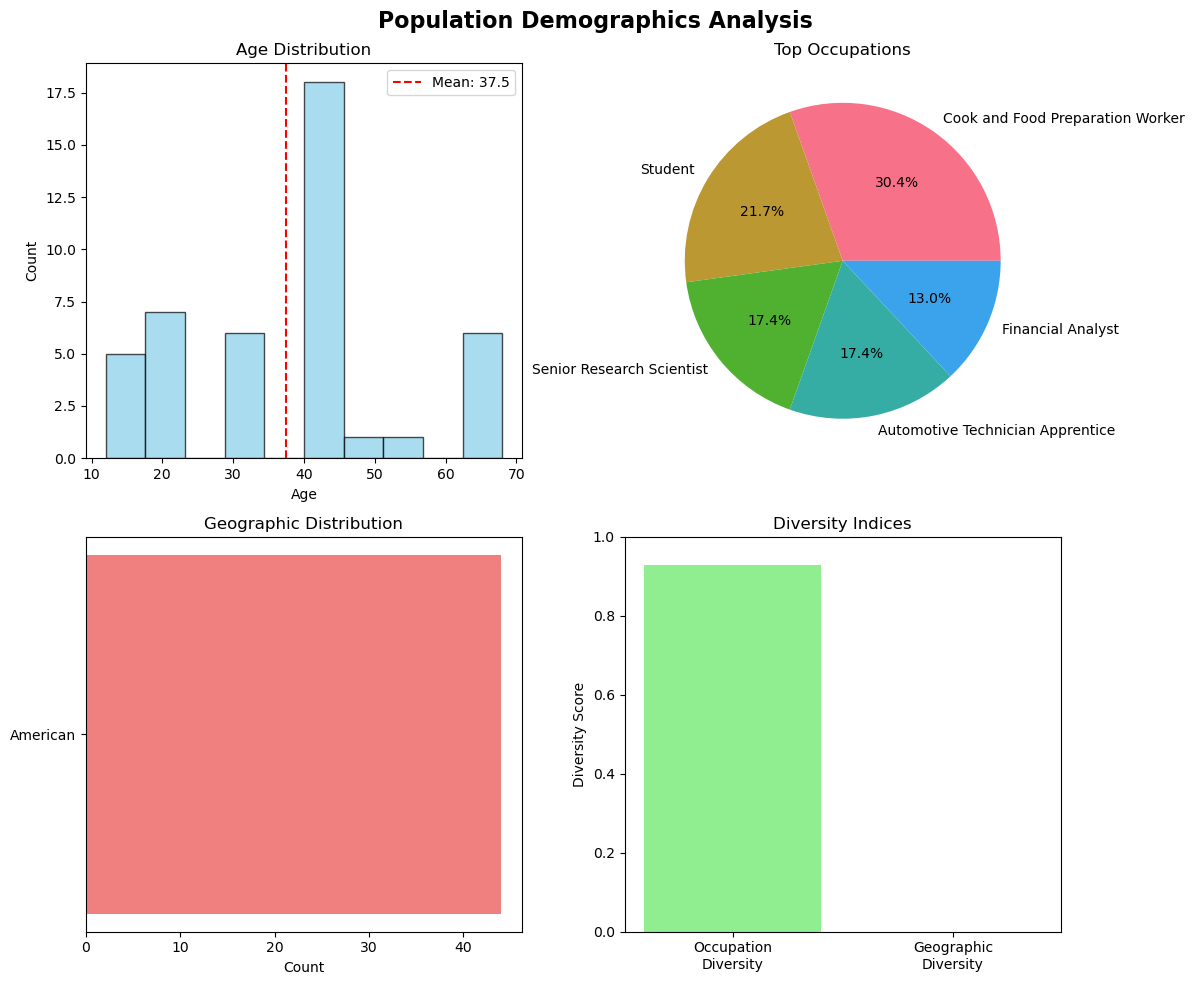

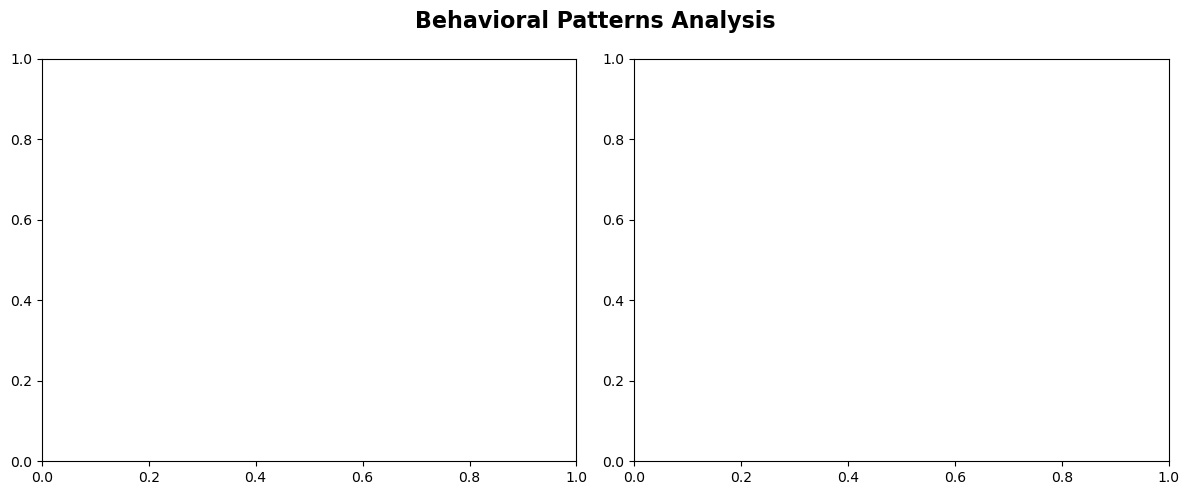

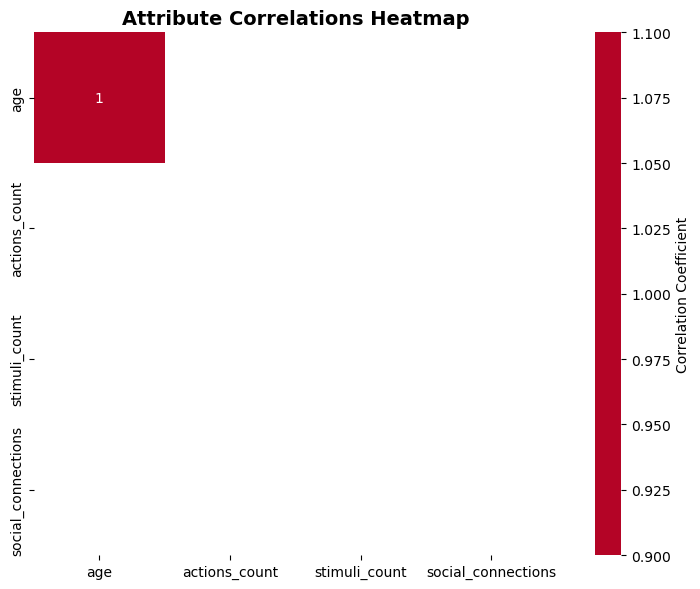

{'distributions': {'age': 12     5
  21     7
  29     6
  42    12
  43     5
  44     1
  47     1
  52     1
  67     1
  68     5
  Name: count, dtype: int64,
  'occupation.title': Automotive Technician Apprentice                     4
  Construction and Extraction Worker                   3
  Cook and Food Preparation Worker                     7
  Data Analyst                                         3
  Early Childhood Education Assistant                  1
  Financial Analyst                                    3
  Food Preparation Worker                              3
  Food Preparation Worker and Part-Time Caterer        1
  Medical Office Assistant                             2
  Retired Administrative Assistant                     3
  Retired Automotive Mechanic                          1
  Retired Home Care Aide                               1
  Retired Office Assistant                             1
  Senior Research Scientist                            4
  Senior Research S

In [14]:
profiler = Profiler()
profiler.profile(people)

Checkpoint the simulation state to disk, to avoid having to re-run the expensive agent sampling process, unless really necessary.

In [15]:
#control.checkpoint()

Now let's enclose the audience in an environment, to make it easier to interact with. Note that we set `broadcast_if_no_target` to `False`, which instructs the environment to **do not** broadcast what specific agents say to the others (unless the agent deliberately specify the target). We are not simulating a focus group, so we don't want discussions.


In [16]:
market = TinyWorld(f"Target audience ({target_nationality})", people, broadcast_if_no_target=False)

## Perform the research

Now we actually ask agents about their opinion. Note that we are asking for specific answers (Yes, No, Maybe), both to convey the granularity of preference we seek, and to make it easier to extract the results later. In general, a coarser granuarity is likely to have higher quality, since it requires less information to be computed accurately.

In [17]:
market.broadcast(interviewer_introduction)
market.broadcast(interviewer_main_question)
market.broadcast_thought(inner_monologue)

USER --> Isabel Mariana Calderón-Sullivan: [CONVERSATION] 
          >      We are performing some market research and need to know you more.      Can you
          > please present yourself and also list your top-10 interests?

       + --> Esteban Miguel Calderón-Rivers

       + --> Miguel Antonio Herrera-Simpson

       + --> ...others...

USER --> Isabel Mariana Calderón-Sullivan: [CONVERSATION] 
          >       Gazpacho is a cold, blended vegetable soup originally from Spain, made mainly with
          > tomatoes, cucumbers, peppers, and olive oil.      We are considering offering it in
          > supermarkets near you.      Would you consider purchasing ready-to-drink bottled
          > gazpacho if it was available at your local supermarket? How much do you like this idea?
          > Please rate your propensity of purchasing it (from 1 to 5), where:        - 1: would
          > NEVER buy it. Note that IT IS OK to give this extreme and impulsive answer if it is how
          > you feel, as it is part of the human experience.        - 2: very unlikely, but not
          > impossible.        - 3: maybe I would buy it, not sure.        - 4: it is very likely.
          > - 5: would CERTAINLY buy it. Note that IT IS OK to give this extreme and impulsive
          > answer if it is how you feel, as it is part of the human experience.

       + --> Esteban Miguel Calderón-Rivers

       + --> Miguel Antonio Herrera-Simpson

       + --> ...others...

Isabel Mariana Calderón-Sullivan --> Isabel Mariana Calderón-Sullivan: [THOUGHT] 
                                      >      I will be honest as I understand they are not here to
                                      > judge me, but just to learn from me.      Such choices
                                      > depend on many factors, but I will make my best guess,
                                      > considering my current      situation in life, location, job
                                      > and interests. I will not refrain from giving extreme
                                      > answers,      such as 1 or 5, if that's how I really feel,
                                      > as this exercise requires me to be honest, human and
                                      > realistic.      Now I **must** first THINK deeply about the
                                      > question, consider all the factors that might influence my
                                      > decision,     and only then I will TALK with my response to
                                      > the question as best, as detailed and as honestly as I can.

Esteban Miguel Calderón-Rivers --> Esteban Miguel Calderón-Rivers: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests. I
                                    > will not refrain from giving extreme answers,      such as 1
                                    > or 5, if that's how I really feel, as this exercise requires
                                    > me to be honest, human and realistic.      Now I **must**
                                    > first THINK deeply about the question, consider all the
                                    > factors that might influence my decision,     and only then I
                                    > will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Miguel Antonio Herrera-Simpson --> Miguel Antonio Herrera-Simpson: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests. I
                                    > will not refrain from giving extreme answers,      such as 1
                                    > or 5, if that's how I really feel, as this exercise requires
                                    > me to be honest, human and realistic.      Now I **must**
                                    > first THINK deeply about the question, consider all the
                                    > factors that might influence my decision,     and only then I
                                    > will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Darnell Marcus Whitaker --> Darnell Marcus Whitaker: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Calvin Jerome Hargrove --> Calvin Jerome Hargrove: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.

Evelyn Margaret Calderwood --> Evelyn Margaret Calderwood: [THOUGHT] 
                                >      I will be honest as I understand they are not here to judge
                                > me, but just to learn from me.      Such choices depend on many
                                > factors, but I will make my best guess, considering my current
                                > situation in life, location, job and interests. I will not refrain
                                > from giving extreme answers,      such as 1 or 5, if that's how I
                                > really feel, as this exercise requires me to be honest, human and
                                > realistic.      Now I **must** first THINK deeply about the
                                > question, consider all the factors that might influence my
                                > decision,     and only then I will TALK with my response to the
                                > question as best, as detailed and as honestly as I can.

Julian Everett Langston-Brooks --> Julian Everett Langston-Brooks: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests. I
                                    > will not refrain from giving extreme answers,      such as 1
                                    > or 5, if that's how I really feel, as this exercise requires
                                    > me to be honest, human and realistic.      Now I **must**
                                    > first THINK deeply about the question, consider all the
                                    > factors that might influence my decision,     and only then I
                                    > will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Vivian Marcelline Ashford --> Vivian Marcelline Ashford: [THOUGHT] 
                               >      I will be honest as I understand they are not here to judge
                               > me, but just to learn from me.      Such choices depend on many
                               > factors, but I will make my best guess, considering my current
                               > situation in life, location, job and interests. I will not refrain
                               > from giving extreme answers,      such as 1 or 5, if that's how I
                               > really feel, as this exercise requires me to be honest, human and
                               > realistic.      Now I **must** first THINK deeply about the
                               > question, consider all the factors that might influence my
                               > decision,     and only then I will TALK with my response to the
                               > question as best, as detailed and as honestly as I can.

Natalia Simone Calderón-Bennett --> Natalia Simone Calderón-Bennett: [THOUGHT] 
                                     >      I will be honest as I understand they are not here to
                                     > judge me, but just to learn from me.      Such choices depend
                                     > on many factors, but I will make my best guess, considering
                                     > my current      situation in life, location, job and
                                     > interests. I will not refrain from giving extreme answers,
                                     > such as 1 or 5, if that's how I really feel, as this exercise
                                     > requires me to be honest, human and realistic.      Now I
                                     > **must** first THINK deeply about the question, consider all
                                     > the factors that might influence my decision,     and only
                                     > then I will TALK with my response to the question as best, as
                                     > detailed and as honestly as I can.

Derrick Samuel Langston --> Derrick Samuel Langston: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Javier Luis Mendoza-Cruz --> Javier Luis Mendoza-Cruz: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.

Isabella Marlene Cortez-Garcia --> Isabella Marlene Cortez-Garcia: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests. I
                                    > will not refrain from giving extreme answers,      such as 1
                                    > or 5, if that's how I really feel, as this exercise requires
                                    > me to be honest, human and realistic.      Now I **must**
                                    > first THINK deeply about the question, consider all the
                                    > factors that might influence my decision,     and only then I
                                    > will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Liam Mateo Castillo-Rivera --> Liam Mateo Castillo-Rivera: [THOUGHT] 
                                >      I will be honest as I understand they are not here to judge
                                > me, but just to learn from me.      Such choices depend on many
                                > factors, but I will make my best guess, considering my current
                                > situation in life, location, job and interests. I will not refrain
                                > from giving extreme answers,      such as 1 or 5, if that's how I
                                > really feel, as this exercise requires me to be honest, human and
                                > realistic.      Now I **must** first THINK deeply about the
                                > question, consider all the factors that might influence my
                                > decision,     and only then I will TALK with my response to the
                                > question as best, as detailed and as honestly as I can.

Rosa Elena Valdez-Morales --> Rosa Elena Valdez-Morales: [THOUGHT] 
                               >      I will be honest as I understand they are not here to judge
                               > me, but just to learn from me.      Such choices depend on many
                               > factors, but I will make my best guess, considering my current
                               > situation in life, location, job and interests. I will not refrain
                               > from giving extreme answers,      such as 1 or 5, if that's how I
                               > really feel, as this exercise requires me to be honest, human and
                               > realistic.      Now I **must** first THINK deeply about the
                               > question, consider all the factors that might influence my
                               > decision,     and only then I will TALK with my response to the
                               > question as best, as detailed and as honestly as I can.

Mariana Elise Torres-Garcia --> Mariana Elise Torres-Garcia: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests. I will not
                                 > refrain from giving extreme answers,      such as 1 or 5, if
                                 > that's how I really feel, as this exercise requires me to be
                                 > honest, human and realistic.      Now I **must** first THINK
                                 > deeply about the question, consider all the factors that might
                                 > influence my decision,     and only then I will TALK with my
                                 > response to the question as best, as detailed and as honestly as
                                 > I can.

Mariana Dolores Castillo-Mendoza --> Mariana Dolores Castillo-Mendoza: [THOUGHT] 
                                      >      I will be honest as I understand they are not here to
                                      > judge me, but just to learn from me.      Such choices
                                      > depend on many factors, but I will make my best guess,
                                      > considering my current      situation in life, location, job
                                      > and interests. I will not refrain from giving extreme
                                      > answers,      such as 1 or 5, if that's how I really feel,
                                      > as this exercise requires me to be honest, human and
                                      > realistic.      Now I **must** first THINK deeply about the
                                      > question, consider all the factors that might influence my
                                      > decision,     and only then I will TALK with my response to
                                      > the question as best, as detailed and as honestly as I can.

Derrick Allen Carmichael --> Derrick Allen Carmichael: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.

Santiago Rafael Moreno-Garcia --> Santiago Rafael Moreno-Garcia: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests. I
                                   > will not refrain from giving extreme answers,      such as 1 or
                                   > 5, if that's how I really feel, as this exercise requires me to
                                   > be honest, human and realistic.      Now I **must** first THINK
                                   > deeply about the question, consider all the factors that might
                                   > influence my decision,     and only then I will TALK with my
                                   > response to the question as best, as detailed and as honestly
                                   > as I can.

Eleanor Grace Montoya --> Eleanor Grace Montoya: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests. I will not refrain from giving
                           > extreme answers,      such as 1 or 5, if that's how I really feel, as
                           > this exercise requires me to be honest, human and realistic.      Now I
                           > **must** first THINK deeply about the question, consider all the
                           > factors that might influence my decision,     and only then I will TALK
                           > with my response to the question as best, as detailed and as honestly
                           > as I can.

Isabela Marquez Delgado --> Isabela Marquez Delgado: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Darnell Marcus Ellington --> Darnell Marcus Ellington: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.

Clara Estelle Whitmore --> Clara Estelle Whitmore: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.

Clara Jeanette McKenzie --> Clara Jeanette McKenzie: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Harold Benjamin Crowley --> Harold Benjamin Crowley: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Natalia Carmen Delgado-Morrison --> Natalia Carmen Delgado-Morrison: [THOUGHT] 
                                     >      I will be honest as I understand they are not here to
                                     > judge me, but just to learn from me.      Such choices depend
                                     > on many factors, but I will make my best guess, considering
                                     > my current      situation in life, location, job and
                                     > interests. I will not refrain from giving extreme answers,
                                     > such as 1 or 5, if that's how I really feel, as this exercise
                                     > requires me to be honest, human and realistic.      Now I
                                     > **must** first THINK deeply about the question, consider all
                                     > the factors that might influence my decision,     and only
                                     > then I will TALK with my response to the question as best, as
                                     > detailed and as honestly as I can.

Jaden Marcus Holloway --> Jaden Marcus Holloway: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests. I will not refrain from giving
                           > extreme answers,      such as 1 or 5, if that's how I really feel, as
                           > this exercise requires me to be honest, human and realistic.      Now I
                           > **must** first THINK deeply about the question, consider all the
                           > factors that might influence my decision,     and only then I will TALK
                           > with my response to the question as best, as detailed and as honestly
                           > as I can.

Eleanor Simone Fairchild --> Eleanor Simone Fairchild: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.

Vivian Alexandra Calloway --> Vivian Alexandra Calloway: [THOUGHT] 
                               >      I will be honest as I understand they are not here to judge
                               > me, but just to learn from me.      Such choices depend on many
                               > factors, but I will make my best guess, considering my current
                               > situation in life, location, job and interests. I will not refrain
                               > from giving extreme answers,      such as 1 or 5, if that's how I
                               > really feel, as this exercise requires me to be honest, human and
                               > realistic.      Now I **must** first THINK deeply about the
                               > question, consider all the factors that might influence my
                               > decision,     and only then I will TALK with my response to the
                               > question as best, as detailed and as honestly as I can.

Marisol Elena Vega --> Marisol Elena Vega: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests. I will not refrain from giving extreme
                        > answers,      such as 1 or 5, if that's how I really feel, as this
                        > exercise requires me to be honest, human and realistic.      Now I
                        > **must** first THINK deeply about the question, consider all the factors
                        > that might influence my decision,     and only then I will TALK with my
                        > response to the question as best, as detailed and as honestly as I can.

Sofia Isabel Mendoza-Rivera --> Sofia Isabel Mendoza-Rivera: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests. I will not
                                 > refrain from giving extreme answers,      such as 1 or 5, if
                                 > that's how I really feel, as this exercise requires me to be
                                 > honest, human and realistic.      Now I **must** first THINK
                                 > deeply about the question, consider all the factors that might
                                 > influence my decision,     and only then I will TALK with my
                                 > response to the question as best, as detailed and as honestly as
                                 > I can.

Adriana Celeste Navarro-Bennett --> Adriana Celeste Navarro-Bennett: [THOUGHT] 
                                     >      I will be honest as I understand they are not here to
                                     > judge me, but just to learn from me.      Such choices depend
                                     > on many factors, but I will make my best guess, considering
                                     > my current      situation in life, location, job and
                                     > interests. I will not refrain from giving extreme answers,
                                     > such as 1 or 5, if that's how I really feel, as this exercise
                                     > requires me to be honest, human and realistic.      Now I
                                     > **must** first THINK deeply about the question, consider all
                                     > the factors that might influence my decision,     and only
                                     > then I will TALK with my response to the question as best, as
                                     > detailed and as honestly as I can.

Derrick Lamar Whitmore --> Derrick Lamar Whitmore: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.

Harold Jennings Whitfield --> Harold Jennings Whitfield: [THOUGHT] 
                               >      I will be honest as I understand they are not here to judge
                               > me, but just to learn from me.      Such choices depend on many
                               > factors, but I will make my best guess, considering my current
                               > situation in life, location, job and interests. I will not refrain
                               > from giving extreme answers,      such as 1 or 5, if that's how I
                               > really feel, as this exercise requires me to be honest, human and
                               > realistic.      Now I **must** first THINK deeply about the
                               > question, consider all the factors that might influence my
                               > decision,     and only then I will TALK with my response to the
                               > question as best, as detailed and as honestly as I can.

Javier Antonio Castillo-Rodriguez --> Javier Antonio Castillo-Rodriguez: [THOUGHT] 
                                       >      I will be honest as I understand they are not here to
                                       > judge me, but just to learn from me.      Such choices
                                       > depend on many factors, but I will make my best guess,
                                       > considering my current      situation in life, location,
                                       > job and interests. I will not refrain from giving extreme
                                       > answers,      such as 1 or 5, if that's how I really feel,
                                       > as this exercise requires me to be honest, human and
                                       > realistic.      Now I **must** first THINK deeply about the
                                       > question, consider all the factors that might influence my
                                       > decision,     and only then I will TALK with my response to
                                       > the question as best, as detailed and as honestly as I can.

Elena Grace Thornton --> Elena Grace Thornton: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Calvin Everett McAllister --> Calvin Everett McAllister: [THOUGHT] 
                               >      I will be honest as I understand they are not here to judge
                               > me, but just to learn from me.      Such choices depend on many
                               > factors, but I will make my best guess, considering my current
                               > situation in life, location, job and interests. I will not refrain
                               > from giving extreme answers,      such as 1 or 5, if that's how I
                               > really feel, as this exercise requires me to be honest, human and
                               > realistic.      Now I **must** first THINK deeply about the
                               > question, consider all the factors that might influence my
                               > decision,     and only then I will TALK with my response to the
                               > question as best, as detailed and as honestly as I can.

Darian Mateo Alvarez --> Darian Mateo Alvarez: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Lena Marie Whitfield --> Lena Marie Whitfield: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Clara Esteban Morales --> Clara Esteban Morales: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests. I will not refrain from giving
                           > extreme answers,      such as 1 or 5, if that's how I really feel, as
                           > this exercise requires me to be honest, human and realistic.      Now I
                           > **must** first THINK deeply about the question, consider all the
                           > factors that might influence my decision,     and only then I will TALK
                           > with my response to the question as best, as detailed and as honestly
                           > as I can.

Gabriel Santiago Ramirez --> Gabriel Santiago Ramirez: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.

Evelyn Harper Sinclair --> Evelyn Harper Sinclair: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.

Morgan Elise Whitman --> Morgan Elise Whitman: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Isabela Moreno Cruz --> Isabela Moreno Cruz: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests. I will not refrain from giving extreme
                         > answers,      such as 1 or 5, if that's how I really feel, as this
                         > exercise requires me to be honest, human and realistic.      Now I
                         > **must** first THINK deeply about the question, consider all the factors
                         > that might influence my decision,     and only then I will TALK with my
                         > response to the question as best, as detailed and as honestly as I can.

Javier Luis Delgado --> Javier Luis Delgado: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests. I will not refrain from giving extreme
                         > answers,      such as 1 or 5, if that's how I really feel, as this
                         > exercise requires me to be honest, human and realistic.      Now I
                         > **must** first THINK deeply about the question, consider all the factors
                         > that might influence my decision,     and only then I will TALK with my
                         > response to the question as best, as detailed and as honestly as I can.

In [18]:
market.run(1)

───────────────────────────────────── Target audience (American) step 1 of 1 ──────────────────────────────────────

Esteban Miguel Calderón-Rivers acts: [THINK] 
                                    > I need to consider my feelings about ready-to-drink bottled
                                    > gazpacho. I don't usually eat cold soups, especially not
                                    > bottled ones. I prefer traditional home-cooked meals,
                                    > especially Mexican dishes like tamales and carne guisada.
                                    > Also, I dislike overly processed foods and fast food. Gazpacho
                                    > is from Spain, not my culture, so I might not be very
                                    > interested. But I should be honest and rate my likelihood of
                                    > buying it based on these thoughts.

Evelyn Margaret Calderwood acts: [THINK] 
                                > I need to consider my feelings about ready-to-drink bottled
                                > gazpacho carefully. Given my preferences for traditional Southern
                                > cooking and dislike for heavy or overly processed foods, I might
                                > not be very inclined to buy such a product. Also, I prefer fresh,
                                > home-cooked meals and am cautious about new or unfamiliar foods.
                                > However, I do enjoy trying new things occasionally, especially if
                                > they are healthy and convenient. I must weigh these factors before
                                > giving my rating.

Natalia Simone Calderón-Bennett acts: [THINK] 
                                     > I need to consider my personal preferences, cultural
                                     > background, and lifestyle when deciding how likely I am to
                                     > purchase ready-to-drink bottled gazpacho. Given that gazpacho
                                     > is a traditional Spanish cold soup and I appreciate Latin
                                     > American and fusion cuisines, I might be open to trying it.
                                     > However, I also value fresh, homemade meals and tend to avoid
                                     > overly processed foods. Convenience is important due to my
                                     > busy work schedule as a data analyst. I should weigh these
                                     > factors carefully before giving a rating.

Isabella Marlene Cortez-Garcia acts: [THINK] 
                                    > I need to think about how much I would like to buy gazpacho if
                                    > it was sold ready-to-drink at my local supermarket. I know
                                    > gazpacho is a cold vegetable soup from Spain with tomatoes,
                                    > cucumbers, peppers, and olive oil. I like some vegetables but
                                    > sometimes I don't like foods that are too unfamiliar or spicy.
                                    > Since gazpacho is cold and has vegetables, I might not be sure
                                    > if I would like it. Also, I like sweet baked goods more than
                                    > savory or cold soups. But maybe it could be refreshing on a
                                    > warm day. I should be honest and give a clear answer based on
                                    > how I feel about trying new foods and my preferences.

Isabel Mariana Calderón-Sullivan acts: [THINK] 
                                      > I need to consider my personal preferences, cultural
                                      > background, and lifestyle when deciding about purchasing
                                      > ready-to-drink bottled gazpacho. Given that gazpacho is a
                                      > cold vegetable soup from Spain, I appreciate fresh and
                                      > healthy foods, but I also dislike overly processed foods. I
                                      > should weigh how convenient it would be to have this product
                                      > available at my local supermarket and whether it fits my
                                      > taste and dietary habits. I also need to consider if I have
                                      > tried gazpacho before and how much I liked it. After
                                      > reflecting on these factors, I will provide an honest rating
                                      > from 1 to 5.

Vivian Marcelline Ashford acts: [THINK] 
                               > Considering my lifestyle in Cambridge, my preferences for fresh and
                               > healthy foods, and my interest in Mediterranean dishes, I find the
                               > idea of ready-to-drink bottled gazpacho intriguing. However, I also
                               > value freshness and quality, so I need to weigh whether a bottled
                               > version would meet my standards. Given that, I would rate my
                               > propensity to purchase it as a 3, maybe I would buy it, not sure.

Miguel Antonio Herrera-Simpson acts: [THINK] 
                                    > I gotta think about this gazpacho thing. It's a cold soup from
                                    > Spain, made with tomatoes, cucumbers, peppers, and olive oil.
                                    > Sounds kinda fancy and different from what I'm used to. I like
                                    > traditional Mexican dishes like carne asada and tamales more.
                                    > Also, I usually prefer warm, hearty food after a long day
                                    > working outside. But I ain't against trying new things if they
                                    > make sense and taste good. I gotta consider if it's something
                                    > my family would like or if it fits with our usual meals. I
                                    > also think about convenience since I work long hours and
                                    > sometimes need quick meals. So, I gotta weigh all that before
                                    > giving a rating.

Derrick Samuel Langston acts: [THINK] 
                             > Alright, let's think this through. Gazpacho is a cold vegetable soup
                             > from Spain, mainly tomatoes, cucumbers, peppers, and olive oil. I
                             > work as a cook in a diner here in Columbus, Ohio, and I focus on
                             > traditional American comfort food. I like hearty breakfasts and lunch
                             > menus. I enjoy cooking new recipes at home, experimenting with
                             > comfort food variations and seasonal ingredients. However, gazpacho
                             > is not something I usually eat or prepare. Also, I prefer reliable,
                             > hearty food that reminds me of home. I tend to be skeptical about
                             > rapid changes or new trends, preferring proven methods. So, would I
                             > buy ready-to-drink bottled gazpacho at my local supermarket?
                             > Honestly, I think I'd be very unlikely to buy it, but not impossible.
                             > Maybe a 2 on the scale. It sounds interesting but not something I'd
                             > reach for regularly. I want to be honest and realistic here.

Julian Everett Langston-Brooks acts: [THINK] 
                                    > Considering my lifestyle in Seattle, my preferences for fresh,
                                    > natural foods, and my interest in Mediterranean and Asian
                                    > fusion cuisines, I find the idea of ready-to-drink bottled
                                    > gazpacho intriguing but I have some reservations. I appreciate
                                    > fresh, artisanal products and often prefer to prepare meals
                                    > myself to control quality and ingredients. However, a high-
                                    > quality gazpacho could be a convenient option, especially
                                    > during warmer months or after outdoor activities like hiking
                                    > or cycling. I need to weigh the convenience against my
                                    > preference for freshness and minimal processing. Given these
                                    > factors, I would rate my propensity to purchase such a product
                                    > as a 3, maybe I would buy it, not sure.

Javier Luis Mendoza-Cruz acts: [THINK] 
                              > Alright, so gazpacho is a cold vegetable soup from Spain, made with
                              > tomatoes, cucumbers, peppers, and olive oil. I gotta think about if
                              > I'd buy a ready-to-drink bottled version at my local supermarket
                              > here in Houston. I like trying new foods sometimes, especially if
                              > they're refreshing and good for hot days. But I ain't sure if I'd go
                              > for a cold soup in a bottle regularly. I do like spicy and flavorful
                              > stuff, and gazpacho sounds kinda fresh and healthy. On the other
                              > hand, I usually go for Tex-Mex or Caribbean flavors more. So maybe
                              > I'd be curious enough to try it once or twice, but not sure if I'd
                              > make it a regular thing. So on a scale from 1 to 5, I think I'd rate
                              > my chance of buying it as a 3, maybe. Not a definite yes, but not a
                              > no either.

Calvin Jerome Hargrove acts: [THINK] 
                            > Alright, let's think this through. Gazpacho is a cold vegetable soup
                            > from Spain, mainly tomatoes, cucumbers, peppers, and olive oil. I work
                            > as a cook in a diner here in Columbus, Ohio, and I like classic
                            > American comfort foods. I prefer fresh and home-cooked meals and tend
                            > to be skeptical of rapid changes or unproven ideas. Also, I dislike
                            > processed and fast food. Gazpacho is not something I grew up with or
                            > usually eat. However, I do enjoy trying new recipes on my days off,
                            > especially comfort foods and barbecue techniques. But gazpacho is
                            > quite different from what I usually cook or eat. Considering that, I
                            > might be a bit hesitant to buy ready-to-drink bottled gazpacho at the
                            > supermarket. On the other hand, if it was fresh and tasty, I might
                            > consider it. So, my rating would probably be a 2: very unlikely, but
                            > not impossible.

Darnell Marcus Whitaker acts: [THINK] 
                             > Alright, let's think this through. Gazpacho is a cold vegetable soup
                             > from Spain, mainly tomatoes, cucumbers, peppers, and olive oil. I
                             > ain't used to that kind of food much around here in Columbus, Ohio. I
                             > mostly cook and eat Southern comfort food and Midwestern classics. I
                             > like strong, black coffee in the mornings and comfort foods like
                             > fried catfish, collard greens, cornbread, and meatloaf. Gazpacho
                             > sounds healthy but kinda unfamiliar and maybe not very filling for
                             > me. Also, I prefer foods with authentic flavor and home-style meals.
                             > But I do like trying new things sometimes, especially if they fit my
                             > taste. Considering all that, I think I'd be more on the unlikely side
                             > to buy ready-to-drink bottled gazpacho at the supermarket. Maybe a 2
                             > out of 5. Not impossible, but not something I'd seek out regularly.
                             > Now I'll share this honestly.

Esteban Miguel Calderón-Rivers acts: [TALK] 
                                    > Well, to be honest, I don't think I'd be buying that bottled
                                    > gazpacho. I usually stick to my traditional home-cooked meals,
                                    > like tamales and carne guisada, and I don't much care for cold
                                    > soups or processed foods. So, I'd give it a 1 — would never
                                    > buy it. Just not my kind of thing.

Vivian Marcelline Ashford acts: [THINK] 
                               > I should now articulate my response clearly and honestly,
                               > reflecting my genuine opinion about the bottled gazpacho product. I
                               > want to be precise and considerate in my language, as I usually am,
                               > given my professional and personal communication style.

Evelyn Margaret Calderwood acts: [THINK] 
                                > I have thought about my preferences and lifestyle. I generally
                                > prefer traditional Southern dishes and home-cooked meals. Gazpacho
                                > is unfamiliar to me, and I tend to avoid heavily processed or cold
                                > vegetable soups. However, I do appreciate fresh produce and light
                                > meals, especially in warm weather. Considering all this, I feel I
                                > would be unlikely to purchase bottled gazpacho, but I wouldn't
                                > completely rule it out if it were convenient and tasty.

Natalia Simone Calderón-Bennett acts: [TALK] 
                                     > I would rate my propensity to purchase ready-to-drink bottled
                                     > gazpacho as a 3. I appreciate the idea because it connects to
                                     > my interest in Latin American and fusion cuisines, and I
                                     > enjoy trying new foods. However, I tend to prefer fresh,
                                     > homemade meals and am cautious about processed foods. If the
                                     > product is high quality and authentic, I might consider
                                     > buying it occasionally for convenience.

Isabel Mariana Calderón-Sullivan acts: [TALK] 
                                      > I appreciate the idea of ready-to-drink bottled gazpacho,
                                      > especially since I enjoy fresh and healthy foods. However, I
                                      > tend to avoid overly processed items, so I would rate my
                                      > propensity to purchase it as a 3 — maybe I would buy it, but
                                      > I'm not entirely sure. It would depend on the quality and
                                      > taste, as well as how convenient it is for me to find it at
                                      > my local supermarket.

Isabella Marlene Cortez-Garcia acts: [TALK] 
                                    > I think I would give it a 2. I am not sure if I would like
                                    > cold vegetable soup like gazpacho because it sounds a little
                                    > strange to me. I usually like sweet foods more, and sometimes
                                    > I don't like foods that are too different or spicy. But maybe
                                    > if I try it once, I could like it. So, very unlikely but not
                                    > impossible to buy it.

Derrick Samuel Langston acts: [TALK] 
                             > Honestly, I'd say I'm a 2 on that scale. I don't usually go for cold
                             > vegetable soups like gazpacho, especially ready-to-drink bottled
                             > ones. It sounds interesting, but it's not really my kind of thing. I
                             > prefer more traditional, hearty foods that remind me of home. But
                             > hey, maybe some folks around here would like it.

Javier Luis Mendoza-Cruz acts: [TALK] 
                              > Hey, so about that bottled gazpacho idea — honestly, I'd say maybe a
                              > 3. I mean, it sounds fresh and all, and I like trying new stuff, but
                              > I'm more into Tex-Mex and Caribbean flavors usually. I'd probably
                              > give it a shot once or twice, but not sure if it'd be a regular buy
                              > for me.

Miguel Antonio Herrera-Simpson acts: [THINK] 
                                    > After thinking it over, I reckon I would rate my propensity to
                                    > buy ready-to-drink bottled gazpacho as a 2. It's not something
                                    > I usually eat or cook at home, and it doesn't fit with the
                                    > traditional Mexican dishes my family and I enjoy. Plus, I
                                    > prefer warm meals after a hard day's work. But I wouldn't say
                                    > never; if it was affordable and tasted good, maybe I'd give it
                                    > a try once in a while. So, very unlikely but not impossible.

Julian Everett Langston-Brooks acts: [TALK] 
                                    > Thank you for explaining the concept of ready-to-drink bottled
                                    > gazpacho. Considering my preferences for fresh, natural foods
                                    > and my interest in Mediterranean and Asian fusion cuisines, I
                                    > would rate my propensity to purchase it as a 3. I might buy it
                                    > occasionally, especially during warmer months or after outdoor
                                    > activities, but I generally prefer preparing such dishes
                                    > myself to ensure quality and freshness.

Calvin Jerome Hargrove acts: [TALK] 
                            > Well, to be honest, I'd say a 2 on that scale. I'm kinda skeptical
                            > about ready-to-drink bottled gazpacho. It's not really something I'm
                            > used to or would usually go for, you know? I prefer fresh, home-cooked
                            > meals and stuff that's more familiar to me. But hey, I ain't saying
                            > never. If it tastes good and feels fresh, maybe I'd give it a shot
                            > sometime. So yeah, very unlikely but not impossible.

Darnell Marcus Whitaker acts: [TALK] 
                             > Honestly, I’d say a 2 out of 5 on buying that bottled gazpacho. It’s
                             > not something I’m used to or would probably reach for often, but I
                             > wouldn’t completely rule it out either. I like my comfort foods and
                             > familiar flavors more, but I’m open to trying new things now and
                             > then.

Isabella Marlene Cortez-Garcia acts: [DONE] 

Derrick Samuel Langston acts: [DONE] 

Calvin Jerome Hargrove acts: [DONE] 

Darnell Marcus Whitaker acts: [DONE] 

Vivian Marcelline Ashford acts: [TALK] 
                               > I would rate my propensity to purchase ready-to-drink bottled
                               > gazpacho as a 3. While I appreciate the idea of a convenient,
                               > healthy option, I tend to prefer fresh preparations, especially for
                               > dishes like gazpacho that rely heavily on fresh ingredients.
                               > However, I might consider trying it if the quality and flavor were
                               > up to standard.

Evelyn Margaret Calderwood acts: [TALK] 
                                > Thank you kindly for asking. My name is Evelyn Margaret
                                > Calderwood. I'm a retired office assistant living here in Tampa,
                                > Florida. I've spent many years working in small businesses around
                                > town, and now I enjoy my days tending to my garden, reading, and
                                > spending time with my grandchildren. As for my top ten interests,
                                > they would be gardening and outdoor activities, reading fiction
                                > and non-fiction books, caring for my cats and small birds,
                                > listening to classical and country music, cooking traditional
                                > Southern recipes, watching nature documentaries, attending local
                                > church events and community gatherings, knitting and crafting,
                                > birdwatching in my backyard, and taking walks in nearby parks and
                                > nature trails. I hope that gives you a good sense of who I am.

Natalia Simone Calderón-Bennett acts: [TALK] 
                                     > Sure! I'm Natalia Simone Calderón-Bennett, a 29-year-old data
                                     > analyst at Innovatech Solutions in San Francisco. I
                                     > specialize in business intelligence and analytics, working
                                     > mainly with finance and retail clients. Outside of work, I'm
                                     > passionate about cooking and baking, especially Latin
                                     > American and fusion cuisines. I also love traveling, reading
                                     > contemporary fiction and non-fiction on technology and
                                     > culture, attending live music events like jazz and Latin
                                     > genres, practicing yoga and outdoor fitness activities like
                                     > hiking and cycling, exploring urban farmers markets,
                                     > volunteering for community education programs, photography
                                     > focusing on street and food scenes, sustainable living, and
                                     > engaging with social media accounts focused on women in STEM.
                                     > These are my top 10 interests!

Miguel Antonio Herrera-Simpson acts: [TALK] 
                                    > Look, I gotta be straight with ya. Gazpacho ain't really my
                                    > thing. I like my warm, hearty meals after a long day on the
                                    > job, and that cold soup just don't fit with what me and my
                                    > family usually eat. But hey, I ain't sayin' never. If it's
                                    > affordable and tastes decent, maybe I'd give it a shot once in
                                    > a while. So, I'd say I'm a 2 on that scale — very unlikely,
                                    > but not impossible.

Esteban Miguel Calderón-Rivers acts: [TALK] 
                                    > I am Esteban Miguel Calderón-Rivers, a retired automotive
                                    > mechanic from San Antonio, Texas. I worked over 30 years
                                    > fixing cars and now enjoy my retirement with gardening,
                                    > cooking traditional Mexican dishes, and spending time with my
                                    > family. My top 10 interests are gardening, reading historical
                                    > fiction and biographies, caring for my two dogs, listening to
                                    > traditional Mexican music like rancheras and boleros, watching
                                    > local high school football games, cooking traditional dishes
                                    > like tamales and pozole, attending Sunday mass, spending quiet
                                    > afternoons on the porch with coffee, collecting old
                                    > photographs and memorabilia, and occasionally playing dominoes
                                    > with friends at the community center.

Isabel Mariana Calderón-Sullivan acts: [TALK] 
                                      > Hello! I'm Isabel Mariana Calderón-Sullivan, a 29-year-old
                                      > financial analyst working at a mid-sized financial services
                                      > company in Manhattan. I focus on portfolio management and
                                      > risk assessment, analyzing market trends and advising
                                      > clients on investment strategies. Outside of work, I have a
                                      > variety of interests that keep me engaged and balanced. My
                                      > top 10 interests include cooking and baking, especially
                                      > experimenting with traditional Mexican and fusion recipes;
                                      > reading contemporary fiction, biographies, and financial
                                      > news; traveling with a focus on cultural immersion and
                                      > culinary experiences; attending live music events like Latin
                                      > jazz and indie folk concerts; volunteering in community
                                      > financial literacy workshops; exploring urban parks for
                                      > exercise and relaxation; following current events affecting
                                      > Hispanic communities; practicing yoga and mindfulness
                                      > meditation; collecting cookbooks and trying new recipes on
                                      > weekends; and watching documentaries on history, economics,
                                      > and social issues. I hope this gives you  (...)

Julian Everett Langston-Brooks acts: [TALK] 
                                    > I am Julian Everett Langston-Brooks, a 42-year-old senior
                                    > research scientist specializing in molecular genetics and
                                    > bioinformatics at the Pacific Northwest Biomedical Institute.
                                    > I lead a team investigating CRISPR-based gene editing
                                    > techniques aimed at treating hereditary disorders. My top 10
                                    > interests include molecular biology and genetics research,
                                    > bioinformatics and computational biology, reading scientific
                                    > journals and popular science books, traveling to culturally
                                    > diverse urban centers, arts and crafts such as woodworking and
                                    > pottery, visiting museums and art galleries, attending live
                                    > music performances especially jazz and indie rock, exploring
                                    > local coffee shops with artisanal brews, hiking and outdoor
                                    > activities in the Pacific Northwest, and cooking and
                                    > experimenting with international cuisines.

Javier Luis Mendoza-Cruz acts: [TALK] 
                              > Hey, just to introduce myself real quick, I'm Javier Luis Mendoza-
                              > Cruz, 21 years old, born and raised in Houston, Texas. I work as an
                              > automotive technician apprentice at a local auto repair shop,
                              > helping out with diagnostics, oil changes, and brake repairs.
                              > Outside of work, I’m really into video games like The Legend of
                              > Zelda and FIFA, hanging out with my close friends and family,
                              > reading fiction especially urban fantasy and Latino literature,
                              > listening to reggaeton and hip-hop, watching basketball and soccer,
                              > exploring local Tex-Mex and Caribbean food spots, playing basketball
                              > on weekends, following automotive trends on YouTube, attending
                              > community cultural events, and staying connected on social media.
                              > Those are my top 10 interests for sure.

Miguel Antonio Herrera-Simpson acts: [DONE] 

Rosa Elena Valdez-Morales acts: [THINK] 
                               > I need to consider my personal preferences, cultural background,
                               > and lifestyle when deciding about buying ready-to-drink bottled
                               > gazpacho. I am used to traditional Mexican foods and prefer
                               > homemade meals. Gazpacho is not a common dish in my culture, and I
                               > usually avoid unfamiliar or exotic foods. Also, I like fresh,
                               > wholesome meals and dislike processed foods. However, I do
                               > appreciate convenience sometimes, especially if the product is
                               > healthy and tasty. I must weigh these factors carefully before
                               > giving my rating.

Mariana Elise Torres-Garcia acts: [THINK] 
                                 > I need to think about how much I would like to buy gazpacho if it
                                 > was sold ready-to-drink at my local supermarket. I like cooking
                                 > and trying new foods, but I don't really know much about
                                 > gazpacho. It sounds a little strange to me because it's cold
                                 > vegetable soup, and I usually like sweet or familiar foods more.
                                 > Also, I don't like foods with strong spicy flavors or unfamiliar
                                 > textures, so I might be a bit unsure. But I am open-minded and
                                 > willing to try new things if encouraged. I think I would probably
                                 > rate my chance of buying it as a 2, very unlikely, but not
                                 > impossible. Maybe if I tried it once and liked it, I could buy it
                                 > again.

Vivian Marcelline Ashford acts: [THINK] 
                               > I have responded honestly about my propensity to purchase bottled
                               > gazpacho, rating it a 3 due to my preference for fresh ingredients
                               > but openness to trying quality products. Now, I should be ready to
                               > continue with any further questions or conclude this interaction
                               > politely.

Mariana Dolores Castillo-Mendoza acts: [THINK] 
                                      > I need to consider my feelings about ready-to-drink bottled
                                      > gazpacho. I like traditional Hispanic foods, but gazpacho is
                                      > not something I grew up with or usually eat. It sounds
                                      > refreshing, especially in warm weather, but I prefer
                                      > homemade meals and cooking from scratch. Also, I am cautious
                                      > about processed foods and prefer fresh ingredients. Given my
                                      > preferences and habits, I think I would be unlikely to buy
                                      > it, but I won't say never because sometimes convenience
                                      > matters. So, I would rate my propensity to buy it as a 2.

Javier Luis Mendoza-Cruz acts: [DONE] 

Liam Mateo Castillo-Rivera acts: [THINK] 
                                > I need to think about how much I would like to buy gazpacho. I
                                > don't really know much about it, but it sounds like a cold
                                > vegetable soup. I like simple foods and I don't like strong or
                                > spicy flavors. Since gazpacho is cold and made of vegetables, I
                                > might not like it much because I prefer warm food and familiar
                                > tastes. Also, I don't usually drink soups from bottles. But maybe
                                > if it tastes good and is easy to drink, I could try it. I should
                                > give an honest answer based on how I feel about trying new foods
                                > and my preferences.

Natalia Simone Calderón-Bennett acts: [TALK] 
                                     > I would rate my propensity to purchase ready-to-drink bottled
                                     > gazpacho as a 3. I like the idea because it connects to my
                                     > interest in Latin American and fusion cuisines, and I enjoy
                                     > trying new foods. However, I usually prefer fresh, homemade
                                     > meals and am cautious about processed foods. If the product
                                     > is authentic and high quality, I might buy it occasionally
                                     > for convenience.

Evelyn Margaret Calderwood acts: [THINK] 
                                > I have been asked about my likelihood of purchasing ready-to-drink
                                > bottled gazpacho. Considering my preferences for traditional
                                > Southern cooking, dislike for heavily processed foods, and
                                > preference for home-cooked meals, I feel I would be unlikely to
                                > buy it. However, I am open to trying new things occasionally if
                                > they are convenient and healthy. I will now prepare to give my
                                > honest rating on a scale from 1 to 5.

Vivian Marcelline Ashford acts: [DONE] 

Esteban Miguel Calderón-Rivers acts: [DONE] 

Isabel Mariana Calderón-Sullivan acts: [TALK] 
                                      > Regarding the ready-to-drink bottled gazpacho, I would rate
                                      > my propensity to purchase it as a 3. I like the idea of
                                      > having a fresh, healthy option available, but I tend to be
                                      > cautious about processed foods. It would depend on the
                                      > quality and taste, as well as how convenient it is to find
                                      > at my local supermarket.

Natalia Simone Calderón-Bennett acts: [DONE] 

Julian Everett Langston-Brooks acts: [DONE] 

Mariana Elise Torres-Garcia acts: [TALK] 
                                 > I think I would give it a 2. I'm not sure if I would like
                                 > gazpacho because it's a cold vegetable soup, and I usually like
                                 > sweeter or more familiar foods. But maybe if I tried it once, I
                                 > could like it and buy it again.

Rosa Elena Valdez-Morales acts: [TALK] 
                               > Mira, mija, I appreciate the idea of having something ready to
                               > drink and fresh, but gazpacho is not something I usually eat or
                               > cook at home. I prefer traditional Mexican dishes like tamales or
                               > menudo. So, if I had to rate my likelihood of buying bottled
                               > gazpacho, I would say 2 — very unlikely, but not impossible. Maybe
                               > if I tried it and liked it, I could consider it, but for now, it's
                               > not something I would seek out.

Derrick Allen Carmichael acts: [THINK] 
                              > Alright, let's think this through. Gazpacho is a cold vegetable soup
                              > from Spain, mainly tomatoes, cucumbers, peppers, and olive oil. I
                              > work as a cook in a family diner here in Columbus, Ohio, and I know
                              > my customers and myself prefer hearty, warm comfort foods like
                              > meatloaf, fried chicken, and mashed potatoes. I like simple, hearty
                              > meals and I'm skeptical of fancy or complicated food trends. Also,
                              > cold soups aren't really part of my usual diet or what I prepare at
                              > work. Considering that, I might not be too keen on buying ready-to-
                              > drink bottled gazpacho. But I want to be honest and realistic. I
                              > don't hate the idea completely; maybe if it was tasty and
                              > affordable, I might try it once or twice. So on a scale from 1 to 5,
                              > I'd probably rate my propensity to buy it as a 2 - very unlikely but
                              > not impossible. That feels like a fair and honest answer given my
                              > tastes and lifestyle.

Mariana Elise Torres-Garcia acts: [DONE] 

Rosa Elena Valdez-Morales acts: [DONE] 

Santiago Rafael Moreno-Garcia acts: [THINK] 
                                   > I need to consider my personal preferences, lifestyle, and
                                   > cultural background before answering about purchasing ready-to-
                                   > drink bottled gazpacho. Given that gazpacho is a Spanish cold
                                   > vegetable soup and I enjoy Mediterranean and Latin American
                                   > cuisines, I might be open to trying it. However, I also dislike
                                   > overly processed foods and fast food chains, so the quality and
                                   > freshness of the product would matter a lot. Since I value
                                   > healthy and fresh foods, if the bottled gazpacho is made with
                                   > quality ingredients and tastes good, I could see myself buying
                                   > it. I should rate my propensity honestly, balancing my
                                   > curiosity and my preference for fresh, whole foods.

Mariana Dolores Castillo-Mendoza acts: [TALK] 
                                      > Thank you for asking. My name is Mariana Dolores Castillo-
                                      > Mendoza. I am 68 years old and I live in San Antonio, Texas.
                                      > I am retired now, but I used to work as a home care aide for
                                      > over 20 years, helping elderly and disabled people with
                                      > their daily needs. I am proud of my Hispanic heritage and
                                      > enjoy simple pleasures like gardening, cooking traditional
                                      > dishes, and spending time with my grandchildren. As for my
                                      > top 10 interests, they are: gardening and outdoor
                                      > activities, reading fiction and educational materials,
                                      > caring for my dog Luna, cooking traditional Hispanic dishes,
                                      > listening to regional Mexican music, attending church
                                      > services and community events, watching telenovelas and
                                      > family-oriented TV shows, knitting and simple crafts,
                                      > walking in local parks, and socializing with close family
                                      > and neighbors.

Isabel Mariana Calderón-Sullivan acts: [TALK] 
                                      > I appreciate the idea of ready-to-drink bottled gazpacho,
                                      > especially since I enjoy fresh and healthy foods. However, I
                                      > tend to avoid overly processed items, so I would rate my
                                      > propensity to purchase it as a 3 — maybe I would buy it, but
                                      > I'm not entirely sure. It would depend on the quality and
                                      > taste, as well as how convenient it is for me to find it at
                                      > my local supermarket.

Liam Mateo Castillo-Rivera acts: [TALK] 
                                > I think I would rate it a 2. I don't really like cold vegetable
                                > soups much, and drinking soup from a bottle sounds a little
                                > strange to me. But maybe if I tried it and it tasted good, I might
                                > like it more. So, very unlikely but not impossible for me to buy
                                > it.

Evelyn Margaret Calderwood acts: [TALK] 
                                > Well, to be honest, I reckon I'd give it a 2. I'm not much for
                                > bottled soups, especially cold ones like gazpacho. It sounds a bit
                                > too fancy and unfamiliar for my taste, and I do prefer my meals
                                > home-cooked and warm. But I suppose if it were convenient and
                                > tasty, I might consider it now and then. So, very unlikely, but
                                > not impossible.

Eleanor Grace Montoya acts: [THINK] 
                           > I need to consider my feelings about ready-to-drink bottled gazpacho
                           > carefully. I like fresh, homemade food, especially traditional dishes,
                           > and I enjoy cooking. Gazpacho is not something I usually make or eat,
                           > but I do appreciate fresh vegetables. However, I am cautious about
                           > trying new products, especially processed ones. I also think about my
                           > health conditions like diabetes and hypertension, so I prefer foods
                           > that are natural and not too salty or sugary. Given all this, I might
                           > be hesitant but open to trying it once if it seems healthy and tasty. I
                           > should express this honestly in my response.

Isabela Marquez Delgado acts: [THINK] 
                             > I need to consider my personal preferences, cultural background, and
                             > lifestyle when deciding about buying ready-to-drink bottled gazpacho.
                             > Gazpacho is a cold vegetable soup from Spain, which is not a
                             > traditional Mexican or Texan dish that I usually eat. I like warm,
                             > spicy foods like tamales and enchiladas more. Also, I prefer fresh
                             > homemade food over processed or bottled products. However, I do
                             > appreciate healthy options and sometimes like trying new things.
                             > Given that, I think I would rate my propensity to buy bottled
                             > gazpacho as a 2, meaning very unlikely but not impossible. I want to
                             > be honest and realistic about this, considering my tastes and habits.

Darnell Marcus Ellington acts: [THINK] 
                              > Alright, I gotta think this through real good. Gazpacho's a cold
                              > veggie soup from Spain, huh? I ain't too familiar with it, and cold
                              > soups ain't usually my thing, especially since I like my food warm
                              > and hearty. Plus, I prefer Southern and soul food styles, the kind I
                              > grew up with. But I do like trying new things sometimes, especially
                              > if they're healthy. Still, bottled ready-to-drink gazpacho? That
                              > sounds kinda fancy and maybe not something I'd reach for often.
                              > Considering my tastes and habits, I'd probably rate my chance of
                              > buying it around a 2. Not impossible, but very unlikely. I gotta be
                              > honest about that. Now, I should share this honestly in my response.

Isabel Mariana Calderón-Sullivan acts: [DONE] 

Clara Estelle Whitmore acts: [THINK] 
                            > I need to consider my feelings about buying ready-to-drink bottled
                            > gazpacho. Given my preference for traditional, home-cooked meals and
                            > my cautious nature about unfamiliar foods, especially those that seem
                            > exotic or out of place in my local stores, I might be hesitant. Also,
                            > I prefer simple, familiar foods and dislike unfamiliar or exotic foods
                            > that feel strange or unappetizing. However, if it were affordable and
                            > convenient, I might consider it. I should rate my propensity honestly,
                            > balancing my skepticism with openness to new things if they prove
                            > worthwhile.

Mariana Dolores Castillo-Mendoza acts: [TALK] 
                                      > I appreciate you telling me about gazpacho. It sounds like a
                                      > fresh and healthy soup, but I must say, I am not very
                                      > familiar with it or used to eating it. I usually prefer
                                      > traditional homemade meals, like pozole or tamales, that
                                      > remind me of my family and culture. So, if ready-to-drink
                                      > bottled gazpacho was available at my local supermarket, I
                                      > would probably rate my chance of buying it as a 2 — very
                                      > unlikely, but not impossible. Sometimes convenience is
                                      > helpful, but I do worry about processed foods and prefer
                                      > fresh ingredients when I can.

Santiago Rafael Moreno-Garcia acts: [TALK] 
                                   > Considering my love for fresh, whole foods and my interest in
                                   > Mediterranean and Latin American cuisines, I would rate my
                                   > propensity to purchase ready-to-drink bottled gazpacho as a 3.
                                   > I might buy it if the quality and taste are good, but I'm
                                   > cautious about processed products. So, it's a maybe for me, not
                                   > a definite yes or no.

Harold Benjamin Crowley acts: [THINK] 
                             > Alright, I gotta think this through. Gazpacho's a cold soup from
                             > Spain, made with tomatoes, cucumbers, peppers, and olive oil. I ain't
                             > used to that kinda food much around here. I like simple, hearty
                             > meals, mostly home-cooked, grilled meats, stews. Cold vegetable soup
                             > sounds kinda fancy and not really my style. Plus, I don't usually buy
                             > ready-to-drink stuff; I prefer cooking myself or eating something
                             > familiar. But maybe on a hot day it could be refreshing. Still, I
                             > reckon I'd be more likely to stick with what I know. So if I had to
                             > rate my chance of buying bottled gazpacho at the local store, I'd
                             > probably say 2—very unlikely but not impossible. I ain't against
                             > trying new things entirely, but this one doesn't fit my usual tastes
                             > or habits.

Clara Jeanette McKenzie acts: [THINK] 
                             > I need to consider my lifestyle, preferences, and the kind of food I
                             > usually enjoy. Gazpacho is a cold vegetable soup from Spain, which is
                             > quite different from the traditional Southern and Midwestern dishes I
                             > usually prepare and eat. I prefer home-cooked meals and am cautious
                             > about trying new or unfamiliar foods, especially processed or ready-
                             > to-drink products. Also, the cold nature of gazpacho might not appeal
                             > to me much, especially in colder seasons. However, I do appreciate
                             > fresh vegetables and simple, wholesome foods. Given all this, I think
                             > I would be unlikely to buy bottled gazpacho regularly, but I wouldn't
                             > completely rule it out if it were available and affordable. So, my
                             > rating would probably be a 2, meaning very unlikely but not
                             > impossible.

Derrick Allen Carmichael acts: [TALK] 
                              > Honestly, I gotta say, I'd probably rate it a 2. I'm not much into
                              > cold soups like gazpacho, especially bottled ones. I prefer warm,
                              > hearty meals that remind me of home and the diner where I work. But
                              > hey, I ain't saying never—if it was tasty and affordable, maybe I'd
                              > give it a shot once in a while.

Mariana Dolores Castillo-Mendoza acts: [DONE] 

Isabela Marquez Delgado acts: [TALK] 
                             > Honestly, I don't think I'd buy ready-to-drink bottled gazpacho very
                             > often. It's not really something I'm used to eating, and I usually
                             > prefer warm, spicy foods like tamales or enchiladas. So, I'd say my
                             > rating is a 2 — very unlikely, but not impossible if I was curious or
                             > it was recommended.

Natalia Carmen Delgado-Morrison acts: [THINK] 
                                     > Considering my lifestyle in Brooklyn, my preferences for
                                     > fresh and healthy foods, and my interest in cooking
                                     > traditional Hispanic recipes, I think about how gazpacho fits
                                     > into my diet. I appreciate fresh vegetables and cold soups,
                                     > especially in warmer months. However, I prefer homemade meals
                                     > and am cautious about ready-to-drink products from
                                     > supermarkets due to concerns about preservatives and
                                     > authenticity. I also consider the convenience factor and how
                                     > often I might buy such a product. Overall, I need to weigh my
                                     > appreciation for fresh, healthy food against my preference
                                     > for homemade dishes and skepticism about processed foods.

Evelyn Margaret Calderwood acts: [TALK] 
                                > Thank you kindly for asking. My name is Evelyn Margaret
                                > Calderwood. I'm a retired office assistant living here in Tampa,
                                > Florida. I've spent many years working in small businesses around
                                > town, and now I enjoy my days tending to my garden, reading, and
                                > spending time with my grandchildren. As for my top ten interests,
                                > they would be gardening and outdoor activities, reading fiction
                                > and non-fiction books, caring for my cats and small birds,
                                > listening to classical and country music, cooking traditional
                                > Southern recipes, watching nature documentaries, attending local
                                > church events and community gatherings, knitting and crafting,
                                > birdwatching in my backyard, and taking walks in nearby parks and
                                > nature trails. I hope that gives you a good sense of who I am.

Derrick Allen Carmichael acts: [DONE] 

Darnell Marcus Ellington acts: [TALK] 
                              > Honestly, I ain't too sure about bottled gazpacho. I like my food
                              > warm and home-cooked, especially Southern and soul food like what I
                              > usually make and eat. So, I'd say I'm a 2 on that scale—very
                              > unlikely to buy it, but not impossible if I ever got curious. I just
                              > don't see it fitting much into my usual meals or tastes.

Liam Mateo Castillo-Rivera acts: [TALK] 
                                > Hi, my name is Liam Mateo Castillo-Rivera. I'm 12 years old and I
                                > go to a public middle school here in Houston. I like animals a
                                > lot, especially dogs and turtles. I also like cooking simple
                                > things like cookies and pancakes with my family. Playing board
                                > games like Candy Land and Connect 4 is fun for me, and I enjoy
                                > watching cartoons with animal characters. I like drawing animals
                                > and colorful pictures, and I like visiting parks and zoos when I
                                > can. I also like listening to music, especially happy songs, and
                                > playing simple video games on my tablet. Spending time with my
                                > family and helping take care of our dog is important to me too.

Eleanor Grace Montoya acts: [TALK] 
                           > Well, I reckon I'd give it a try, but I wouldn't be too quick to buy it
                           > regular-like. I'd say maybe a 3 on your scale. I like fresh food from
                           > my garden best, but if the bottled gazpacho is made with good, natural
                           > ingredients and not too much salt or sugar, I might buy it once in a
                           > while. It's just that I prefer to cook and know what's in my food, you
                           > know?

Clara Estelle Whitmore acts: [TALK] 
                            > Well, bless your heart for askin'. I gotta be honest, I ain't too sure
                            > 'bout buyin' that bottled gazpacho. I like my food home-cooked and
                            > familiar, you know? So I'd say maybe a 2 on that scale—very unlikely,
                            > but I wouldn't say never. If it was somethin' folks 'round here liked
                            > and it was affordable, maybe I'd give it a try, but right now, it
                            > don't sound like my kinda thing.

Isabela Marquez Delgado acts: [DONE] 

Darnell Marcus Ellington acts: [DONE] 

Eleanor Grace Montoya acts: [DONE] 

Clara Jeanette McKenzie acts: [TALK] 
                             > Well, to be honest, I don't think I'd be buying bottled gazpacho
                             > much. I usually stick to home-cooked meals, and that kind of cold
                             > soup ain't really my usual fare, especially 'round here. I'd say
                             > maybe a 2 on your scale — very unlikely, but I wouldn't say no
                             > outright if it was there and affordable. I just prefer things more
                             > familiar and warm, you know?

Liam Mateo Castillo-Rivera acts: [DONE] 

Harold Benjamin Crowley acts: [TALK] 
                             > Well, to be honest, I ain't much for cold vegetable soups like
                             > gazpacho. I usually stick to simple, hearty meals—grilled meats,
                             > stews, that sort of thing. So if I had to rate how likely I'd be to
                             > buy ready-to-drink bottled gazpacho at my local store, I'd say a 2.
                             > Very unlikely, but I wouldn't say never. Maybe on a hot day I'd give
                             > it a try, but it ain't really my usual taste.

Clara Jeanette McKenzie acts: [DONE] 

Jaden Marcus Holloway acts: [THINK] 
                           > I gotta think 'bout this gazpacho thing. I don't really like foods with
                           > strong or spicy flavors, and I ain't sure if cold vegetable soup sounds
                           > good to me. I like warm, sweet drinks more, like hot chocolate with
                           > marshmallows. Also, I don't know much 'bout gazpacho since it's from
                           > Spain and I ain't tried it before. Maybe I'd be very unlikely to buy
                           > it, but I wanna be honest and say how I really feel.

Santiago Rafael Moreno-Garcia acts: [TALK] 
                                   > Sure! I'm Santiago Rafael Moreno-Garcia, a 29-year-old data
                                   > analyst working at FinTech Solutions Inc. in San Francisco. I
                                   > specialize in analyzing large datasets to help guide product
                                   > development and marketing strategies. Outside of work, I'm
                                   > really into cooking and baking, especially experimenting with
                                   > Latin American and Mediterranean recipes. I also love reading a
                                   > wide range of books, traveling to immerse myself in different
                                   > cultures and cuisines, attending live music events like jazz
                                   > and indie rock, exploring urban hiking trails around the Bay
                                   > Area, visiting museums and art galleries, volunteering for
                                   > community tech education programs, following tech podcasts and
                                   > blogs, playing strategy board games with friends, and
                                   > practicing mindfulness and yoga to keep balanced. Those are
                                   > some of my top interests!

Natalia Carmen Delgado-Morrison acts: [TALK] 
                                     > Thanks for explaining gazpacho. Considering my preference for
                                     > fresh, homemade meals and my cautiousness about processed
                                     > foods, I'd rate my propensity to purchase ready-to-drink
                                     > bottled gazpacho as a 2. It's not impossible, especially for
                                     > convenience during busy days, but I'm generally unlikely to
                                     > buy it regularly.

Harold Benjamin Crowley acts: [DONE] 

Eleanor Simone Fairchild acts: [THINK] 
                              > Considering my lifestyle in Boston, my preferences for fresh and
                              > healthy foods, and my interest in sustainable living, I find the
                              > idea of ready-to-drink bottled gazpacho intriguing. However, I am
                              > cautious about processed foods and their environmental impact. I
                              > need to weigh convenience against quality and sustainability before
                              > deciding. Given these factors, I would likely rate my propensity to
                              > purchase it as a 3, maybe I would buy it, but I'm not sure yet.

Evelyn Margaret Calderwood acts: [DONE] 

Clara Estelle Whitmore acts: [TALK] 
                            > Sure thing! I'm Clara Estelle Whitmore, 42 years old, and I work as a
                            > cook and server at our local family-owned diner here in rural Ohio. I
                            > mostly prepare traditional American comfort foods and try to keep
                            > things simple and homey. As for my top 10 interests, I'd say: 1)
                            > Outdoor activities like hiking and fishing, 2) Caring for my two dogs
                            > and cat, 3) Shopping at local thrift stores and farmers markets, 4)
                            > Listening to country and folk music, 5) Watching community sports
                            > events, 6) Cooking family recipes, 7) Gardening vegetables and herbs,
                            > 8) Participating in church potlucks, 9) Reading simple novels and
                            > magazines, and 10) Knitting and quilting during quiet evenings. Hope
                            > that gives you a good picture of me!

Santiago Rafael Moreno-Garcia acts: [DONE] 

Natalia Carmen Delgado-Morrison acts: [DONE] 

Marisol Elena Vega acts: [THINK] 
                        > Okay, so gazpacho is a cold vegetable soup from Spain, made with tomatoes,
                        > cucumbers, peppers, and olive oil. I like trying new foods sometimes,
                        > especially if they remind me of Hispanic culture. But I usually prefer
                        > warm dishes like tamales or arroz con pollo. Also, I don't know if I'd
                        > like a ready-to-drink bottled version. It might be convenient, but I worry
                        > it could taste bland or artificial. Considering my preferences and habits,
                        > I think I'd rate my likelihood to buy it as a 3, maybe. I'm not sure if
                        > I'd really go for it regularly, but I might try it once or twice out of
                        > curiosity.

Sofia Isabel Mendoza-Rivera acts: [THINK] 
                                 > I need to think about how much I would like to buy ready-to-drink
                                 > bottled gazpacho at my local supermarket. I like cooking and
                                 > trying new foods, but I don't know much about gazpacho. It sounds
                                 > a little strange to me because it's cold vegetable soup, and I
                                 > usually like warm food. Also, I don't like strong spicy flavors,
                                 > and I wonder if gazpacho might be too strong or spicy. But since
                                 > it's from Spain and my family likes traditional Hispanic dishes,
                                 > maybe it could be interesting to try. I should consider if I
                                 > would really want to buy it or not.

Vivian Alexandra Calloway acts: [THINK] 
                               > Considering my lifestyle in Boston, my preferences for fresh and
                               > natural foods, and my dislike for overly processed meals, I need to
                               > evaluate how ready-to-drink bottled gazpacho fits into my diet.
                               > Gazpacho is a cold vegetable soup, which aligns with my interest in
                               > healthy eating and Mediterranean dishes. However, I prefer freshly
                               > prepared meals and am cautious about the quality of ready-made
                               > products. I also consider convenience and availability. Given these
                               > factors, I lean towards a moderate interest but am not fully
                               > convinced yet.

Adriana Celeste Navarro-Bennett acts: [THINK] 
                                     > I need to consider my personal preferences, lifestyle, and
                                     > cultural background before answering about the gazpacho.
                                     > Given my interest in Latin American and Mediterranean
                                     > recipes, I appreciate fresh, healthy foods. However, I also
                                     > dislike overly processed meals and prefer homemade dishes.
                                     > Gazpacho is a traditional Spanish cold soup, which aligns
                                     > with my culinary interests, but I might be cautious about
                                     > ready-to-drink bottled versions due to concerns about
                                     > freshness and quality. I should weigh these factors carefully
                                     > before giving a rating.

Jaden Marcus Holloway acts: [TALK] 
                           > I think I would give it a 2. I don't really like strong or spicy foods,
                           > and cold vegetable soup sounds kinda strange to me. But maybe I could
                           > try it sometime if it's not too weird.

Derrick Lamar Whitmore acts: [THINK] 
                            > Alright, I gotta think this through real good. Gazpacho, huh? It's a
                            > cold soup from Spain, mostly veggies like tomatoes and cucumbers. I
                            > ain't had much of that before, but I do like simple, hearty meals.
                            > Still, cold soup ain't really my usual thing, especially since I like
                            > my food warm and comforting. Plus, I gotta consider if it's something
                            > my family or I would actually buy at the supermarket. I gotta be
                            > honest though, I ain't too sure about buying ready-to-drink bottled
                            > gazpacho. It sounds a bit fancy for my taste and maybe not something
                            > I'd reach for regularly. But I don't wanna dismiss it outright without
                            > thinking more about it. So, I gotta weigh how likely I'd be to buy it
                            > on a scale from 1 to 5, keeping in mind my preferences and lifestyle.

Eleanor Simone Fairchild acts: [TALK] 
                              > Thank you for explaining the gazpacho concept. Considering my
                              > preference for fresh, healthy, and sustainable foods, I would rate
                              > my propensity to purchase ready-to-drink bottled gazpacho as a 3. I
                              > might buy it occasionally, but I'd want to know more about its
                              > ingredients and environmental impact before deciding.

Harold Jennings Whitfield acts: [THINK] 
                               > Alright, I gotta think this through. Gazpacho's a cold soup from
                               > Spain, made with tomatoes, cucumbers, peppers, and olive oil. I
                               > ain't too familiar with it, and cold soups ain't really my usual
                               > comfort food. I like traditional American and Southern dishes more.
                               > Also, I prefer home-cooked meals with familiar flavors. But I do
                               > appreciate fresh ingredients and supporting local produce.
                               > Considering that, I might be skeptical about buying a ready-to-
                               > drink bottled gazpacho at the supermarket. It might be a bit too
                               > exotic or unfamiliar for me. On the other hand, if it's tasty and
                               > convenient, maybe I'd give it a try once in a while. So, I think my
                               > rating would be around 2, very unlikely but not impossible. I gotta
                               > be honest about my preferences and habits here.

Elena Grace Thornton acts: [THINK] 
                          > I need to think about how I feel about this gazpacho idea. I don't
                          > usually buy ready-made cold soups, especially ones that are not common
                          > around here. I like traditional, warm, hearty meals more, like stews and
                          > casseroles. Also, I prefer home-cooked food and am a bit skeptical about
                          > new products, especially those that seem fancy or unfamiliar. But I also
                          > want to be honest and consider if I might try it just to see if it suits
                          > my taste. Given my cautious nature and preference for familiar foods, I
                          > think I would probably rate my likelihood of buying it as low, maybe a
                          > 2. That means very unlikely but not impossible, since I might try it if
                          > someone recommended it or if it was on sale. Overall, I am not very
                          > enthusiastic about this product, but I won't completely rule it out.

Vivian Alexandra Calloway acts: [TALK] 
                               > Thank you for asking. I'm Vivian Alexandra Calloway, a senior
                               > research scientist specializing in molecular oncology at
                               > Massachusetts General Hospital Cancer Center. I lead a team
                               > investigating tumor progression and drug resistance, and I also
                               > mentor graduate students and postdocs. As for my top 10 interests,
                               > they are molecular biology and genetics research, reading
                               > contemporary and classic literature, traveling to culturally rich
                               > urban centers, arts and crafts like pottery and watercolor
                               > painting, attending scientific conferences and seminars, exploring
                               > local coffee shops with quiet atmospheres, hiking and outdoor
                               > activities in New England, cooking international cuisines,
                               > listening to jazz and classical music, and volunteering for science
                               > education outreach.

Javier Antonio Castillo-Rodriguez acts: [THINK] 
                                       > Alright, I gotta think about this gazpacho thing. It's a
                                       > cold veggie soup from Spain, right? I ain't really used to
                                       > that kind of food much, especially ready-to-drink bottled
                                       > stuff. I usually go for more traditional Hispanic dishes
                                       > like tamales or arroz con pollo. Also, I like spicy foods
                                       > and snacks like Takis and jalapeño chips, so something cold
                                       > and mild might not be my first pick. But I do like trying
                                       > new things sometimes, especially if they're convenient.
                                       > Since it's a ready-to-drink product, it could be handy for
                                       > quick lunches or snacks at work. Still, I'm not sure if I'd
                                       > buy it regularly. So, thinking about all that, I'd probably
                                       > rate my chance of buying it as a 2 - very unlikely but not
                                       > impossible. I gotta be honest though, it's not really my
                                       > usual taste or style of food.

Sofia Isabel Mendoza-Rivera acts: [TALK] 
                                 > I think I would give it a 2. I'm not sure if I would like cold
                                 > vegetable soup because I usually like warm food, and sometimes
                                 > new foods make me nervous. But maybe if I try it once, I could
                                 > like it. It sounds interesting since it's from Spain, and my
                                 > family likes Hispanic dishes, but I'm a little unsure about it.

Clara Estelle Whitmore acts: [DONE] 

Adriana Celeste Navarro-Bennett acts: [TALK] 
                                     > Considering my love for fresh, homemade dishes and my dislike
                                     > for overly processed meals, I would rate my propensity to
                                     > purchase ready-to-drink bottled gazpacho as a 2. While I
                                     > appreciate the idea and the cultural connection to
                                     > Mediterranean cuisine, I would be very unlikely to buy it
                                     > because I prefer making such dishes myself to ensure
                                     > freshness and quality.

Marisol Elena Vega acts: [TALK] 
                        > Hey! So, I'm Marisol Elena Vega, 21 years old, working as a medical office
                        > assistant at a community health clinic here in Houston. I help with
                        > scheduling, managing records, and supporting patients, especially those
                        > from Hispanic and African American communities. I love video games,
                        > especially story-driven RPGs and multiplayer ones, hanging out with
                        > friends and family, reading books by Latino authors, listening to Latin
                        > pop and reggaeton, cooking traditional dishes like tamales and arroz con
                        > pollo, watching telenovelas, going for walks in the park, attending
                        > cultural festivals, staying connected on Instagram and TikTok, and
                        > volunteering at community events. Those are my top 10 interests!

Jaden Marcus Holloway acts: [THINK] 
                           > I was asked to present myself and list my top-10 interests. I am Jaden
                           > Marcus Holloway, a 12-year-old boy from Houston, Texas. I go to middle
                           > school and have some trouble with reading and writing, but I like to
                           > learn and play games. My top interests include cooking and baking
                           > simple recipes with my family, playing board games like Candy Land and
                           > Connect 4, taking care of my dog Buddy, watching animated movies,
                           > listening to pop music and children's songs, drawing and coloring,
                           > playing outside at the park, building with LEGO blocks, collecting toy
                           > cars and action figures, and enjoying family movie nights with popcorn.
                           > I want to share this in a simple way that shows who I am.

Calvin Everett McAllister acts: [THINK] 
                               > Alright, I gotta think this through. Gazpacho's a cold soup, mostly
                               > veggies like tomatoes and cucumbers. I ain't used to that kinda
                               > food much, especially ready-to-drink bottled stuff. Around here,
                               > folks usually stick to hot meals and simple, hearty foods. I don't
                               > like fancy or unfamiliar foods much, so that might make me lean
                               > towards not buying it. But if it was cheap and convenient, maybe
                               > I'd give it a try once or twice. Still, I reckon my overall
                               > interest is pretty low. I gotta be honest and say I'd probably rate
                               > my chance of buying it as a 2, very unlikely but not impossible.
                               > Now I'll say this out loud.

Derrick Lamar Whitmore acts: [TALK] 
                            > Well, to be honest, I'd probably give it a 2. I'm not sayin' I'd never
                            > buy it, but it's kinda unlikely. I usually go for warm, hearty meals,
                            > and cold soups like gazpacho ain't really my thing. But hey, if it was
                            > there and I was curious, maybe I'd give it a try once or twice. Just
                            > don't see it as a regular on my shopping list though.

Eleanor Simone Fairchild acts: [TALK] 
                              > Certainly, I am Eleanor Simone Fairchild, a Senior Research
                              > Scientist at a leading biomedical research institute in Boston. I
                              > lead a multidisciplinary team investigating molecular mechanisms
                              > underlying neurodegenerative diseases. My top 10 interests include
                              > molecular biology and genetics research, reading contemporary
                              > fiction and scientific literature, traveling internationally to
                              > experience diverse cultures, arts and crafts such as watercolor
                              > painting and pottery, visiting museums and attending cultural
                              > events, yoga and outdoor running, exploring new cuisines and cooking
                              > at home, attending lectures and seminars on science and philosophy,
                              > engaging in community science outreach programs, and listening to
                              > classical music and jazz.

Derrick Lamar Whitmore acts: [DONE] 

Vivian Alexandra Calloway acts: [THINK] 
                               > Now I need to consider the question about my propensity to purchase
                               > ready-to-drink bottled gazpacho. Given my preferences for fresh,
                               > natural foods and dislike for overly processed meals, I should
                               > honestly rate my likelihood. While gazpacho aligns with my interest
                               > in Mediterranean dishes, I am cautious about ready-made products. I
                               > will weigh convenience against quality and freshness before giving
                               > a rating.

Eleanor Simone Fairchild acts: [DONE] 

Sofia Isabel Mendoza-Rivera acts: [THINK] 
                                 > Now I should answer the first question about presenting myself
                                 > and listing my top-10 interests. I am Sofia, a 12-year-old
                                 > student from Houston. I like cooking, playing board games, taking
                                 > care of my dog Luna, listening to music, watching educational
                                 > shows, arts and crafts, collecting stickers, playing outside,
                                 > reading picture books with help, and storytelling. I should say
                                 > this in a simple and clear way with my Texan accent and some
                                 > Spanish words if it fits.

Javier Antonio Castillo-Rodriguez acts: [TALK] 
                                       > Hey, so about that gazpacho stuff you asked, honestly, I’d
                                       > say probably a 2. It’s not really my usual thing, you know?
                                       > I’m more into traditional Hispanic foods like tamales or
                                       > arroz con pollo, and I like my snacks spicy. But I guess if
                                       > it’s convenient and I’m in a pinch, maybe I’d try it once
                                       > or twice. Just don’t expect me to buy it all the time.

Harold Jennings Whitfield acts: [TALK] 
                               > Well, to be honest, I ain't too sure about buying bottled gazpacho.
                               > It's not really something I'm used to, and I prefer my home-cooked
                               > meals with familiar flavors. So I'd say my likelihood of buying it
                               > is a 2 — very unlikely, but not impossible. If it tastes good and
                               > is convenient, maybe I'd give it a try once in a while, but I
                               > wouldn't count on it much.

Adriana Celeste Navarro-Bennett acts: [TALK] 
                                     > Sure! I'm Adriana Celeste Navarro-Bennett, a 29-year-old
                                     > financial analyst based in Brooklyn, New York. I specialize
                                     > in portfolio management and risk assessment at a mid-sized
                                     > financial services company in Manhattan. I'm passionate about
                                     > cooking, especially Latin American and Mediterranean recipes,
                                     > traveling for cultural immersion, and engaging in community
                                     > volunteer work focused on financial literacy. My top 10
                                     > interests include cooking and baking, reading contemporary
                                     > fiction and financial literature, traveling domestically and
                                     > internationally, attending live jazz and Latin music
                                     > concerts, practicing yoga and hiking, exploring local coffee
                                     > shops, volunteering for education and economic empowerment,
                                     > following financial markets, collecting cookbooks, and
                                     > watching documentaries on social issues and global cultures.

Marisol Elena Vega acts: [THINK] 
                        > I need to answer honestly about whether I'd buy bottled gazpacho. I like
                        > Hispanic foods but usually prefer warm dishes. Gazpacho is cold and from
                        > Spain, which is a bit different from my usual tastes. I might be curious
                        > to try it once, but not sure if I'd buy it regularly. So, I think my
                        > rating would be a 3, maybe. I should explain this clearly when I talk.

Elena Grace Thornton acts: [TALK] 
                          > Well, bless your heart for askin'. I gotta be honest, I ain't much for
                          > those ready-to-drink cold soups like gazpacho. I usually stick to warm,
                          > hearty meals that remind me of home, like stews and casseroles. So, if I
                          > had to rate how likely I'd be to buy it, I'd say a 2 — very unlikely,
                          > but I wouldn't say never. Maybe if it was on sale or someone I trust
                          > recommended it, I'd give it a try. But mostly, I prefer cookin' my own
                          > meals the way I know and love.

Darian Mateo Alvarez acts: [THINK] 
                          > Alright, so gazpacho is a cold vegetable soup from Spain, made with
                          > tomatoes, cucumbers, peppers, and olive oil. I gotta think about if I'd
                          > buy a ready-to-drink bottled version at my local supermarket. I don't
                          > usually eat cold soups, and honestly, it sounds kinda unfamiliar to me.
                          > Plus, I prefer foods that are more familiar and not too spicy or weird.
                          > But I do like trying new things sometimes, especially if they're easy
                          > and convenient. Still, I don't think I'd be super into buying it
                          > regularly. So on a scale from 1 to 5, I'd probably go with a 2, meaning
                          > very unlikely but not impossible. I gotta be honest though, it just
                          > doesn't really fit my usual tastes or habits.

Calvin Everett McAllister acts: [TALK] 
                               > I reckon I'd give it a 2. I ain't too keen on fancy or new foods
                               > like that, especially ready-to-drink soups. But I wouldn't say
                               > never, maybe if it was cheap and convenient, I'd try it once in a
                               > while.

Harold Jennings Whitfield acts: [DONE] 

Javier Antonio Castillo-Rodriguez acts: [DONE] 

Jaden Marcus Holloway acts: [TALK] 
                           > Hi, I'm Jaden Marcus Holloway. I'm 12 years old and I go to middle
                           > school in Houston, Texas. I like cooking and baking simple recipes with
                           > my family, playing board games like Candy Land and Connect 4, taking
                           > care of my dog Buddy, watching animated movies and cartoons, listening
                           > to pop music and children's songs, drawing and coloring with crayons
                           > and markers, playing outside at the park, building with LEGO blocks,
                           > collecting small toy cars and action figures, and enjoying family movie
                           > nights with popcorn and snacks.

Elena Grace Thornton acts: [DONE] 

Jaden Marcus Holloway acts: [DONE] 

Calvin Everett McAllister acts: [DONE] 

Vivian Alexandra Calloway acts: [TALK] 
                               > Considering my preference for fresh, natural foods and my dislike
                               > for overly processed meals, I would rate my propensity to purchase
                               > ready-to-drink bottled gazpacho as a 2. While I appreciate the
                               > concept and the ingredients align with my interests, I am generally
                               > cautious about ready-made products and prefer freshly prepared
                               > meals.

Lena Marie Whitfield acts: [THINK] 
                          > I need to think about how I feel about this ready-to-drink gazpacho. I
                          > don't usually eat cold soups, especially not bottled ones, and I prefer
                          > fresh, home-cooked meals. Given my cautious nature and preference for
                          > traditional foods, I might be skeptical about this product. But I also
                          > want to be honest and consider if it could be convenient for busy days
                          > at work. Overall, I lean towards not buying it, but I should express
                          > this clearly and honestly.

Clara Esteban Morales acts: [THINK] 
                           > I need to consider my feelings about ready-to-drink bottled gazpacho. I
                           > like fresh, home-cooked meals and prefer traditional foods. Gazpacho is
                           > not a common dish in my household, and I usually avoid unfamiliar or
                           > exotic foods that might be too spicy or bitter. Also, I dislike overly
                           > processed meals and fast food. Given that, I might be hesitant to buy
                           > bottled gazpacho. However, if it were mild and fresh-tasting, I might
                           > consider it for a change. I should rate my propensity honestly,
                           > balancing my cautious nature with openness to trying new things.

Vivian Alexandra Calloway acts: [DONE] 

Marisol Elena Vega acts: [TALK] 
                        > Thanks for explaining about gazpacho! Honestly, I think I'd rate my chance
                        > of buying ready-to-drink bottled gazpacho as a 3. I like trying new foods,
                        > especially those with Hispanic roots, but since gazpacho is a cold soup
                        > and I'm more used to warm dishes like tamales or arroz con pollo, I'm not
                        > sure if I'd buy it regularly. But I might give it a try out of curiosity!

Gabriel Santiago Ramirez acts: [THINK] 
                              > I need to consider my personal preferences, lifestyle, and cultural
                              > background to answer honestly about purchasing ready-to-drink
                              > bottled gazpacho. Given my interest in cooking and fresh
                              > ingredients, I usually prefer homemade or freshly prepared foods.
                              > However, convenience is also a factor in my busy life. I should
                              > weigh how much I value convenience versus freshness and quality.
                              > Also, since gazpacho is not a traditional dish in my usual cooking
                              > repertoire, I might be less inclined to buy it regularly. But I do
                              > appreciate trying new foods and flavors, especially those with
                              > cultural significance. Considering all this, I will rate my
                              > propensity realistically.

Darian Mateo Alvarez acts: [TALK] 
                          > Hey, so about that gazpacho drink you asked 'bout, honestly, I ain't
                          > really feelin' it much. I mean, cold veggie soup ain't really my thing,
                          > ya know? I'd probably rate it a 2 — like, very unlikely to buy it, but I
                          > ain't sayin' never. Maybe if I was curious or somethin', but usually I
                          > stick to stuff I know and like. Just keepin' it real.

Sofia Isabel Mendoza-Rivera acts: [TALK] 
                                 > Hi! I'm Sofia Isabel Mendoza-Rivera. I'm 12 years old and I go to
                                 > a middle school here in Houston. I really like cooking and baking
                                 > simple recipes with my mom, like cookies and pancakes. I also
                                 > love playing board games with my family and friends, especially
                                 > games like Candy Land and Uno. Taking care of my dog Luna is
                                 > super fun, I like feeding her and playing fetch. I enjoy
                                 > listening to Latin pop music and kids' songs in English and
                                 > Spanish. Watching shows about animals and cooking is cool too. I
                                 > like arts and crafts, drawing and coloring recipe cards.
                                 > Collecting colorful stickers and recipe cards is one of my
                                 > hobbies. I love playing outside in the park with my friends, and
                                 > I like reading picture books with my family. Lastly, I enjoy
                                 > telling stories and using my imagination a lot!

Adriana Celeste Navarro-Bennett acts: [DONE] 

Morgan Elise Whitman acts: [THINK] 
                          > Considering my lifestyle, dietary preferences, and interest in
                          > Mediterranean cuisine, I find the idea of ready-to-drink bottled
                          > gazpacho intriguing. I appreciate fresh, healthy foods and often prepare
                          > meals from scratch, but convenience is important given my busy schedule.
                          > I also value quality ingredients and sustainability. I need to weigh how
                          > much I trust the product's freshness and flavor against the convenience
                          > it offers. Overall, I am leaning towards a positive inclination but want
                          > to be honest about my likelihood to purchase.

Darian Mateo Alvarez acts: [DONE] 

Evelyn Harper Sinclair acts: [THINK] 
                            > Considering my lifestyle in Boston, my preferences for fresh and
                            > healthy foods, and my interest in diverse culinary experiences, I
                            > think about how gazpacho fits into my diet. I appreciate fresh
                            > vegetables and Mediterranean flavors, but I also value convenience and
                            > quality. I must weigh whether a ready-to-drink bottled gazpacho would
                            > meet my standards for taste and freshness, and if it aligns with my
                            > preference for sustainable and minimally processed foods. I also
                            > consider the seasonal aspect, as gazpacho is typically a summer dish,
                            > and how often I might realistically purchase it.

Marisol Elena Vega acts: [DONE] 

Sofia Isabel Mendoza-Rivera acts: [DONE] 

Lena Marie Whitfield acts: [TALK] 
                          > Well, to be honest, I don't think I'd be buyin' that gazpacho. I prefer
                          > fresh, home-cooked meals, y'know? Bottled cold soup just ain't my thing.
                          > So I'd say a 1, I would never buy it. I like to stick with what I know
                          > and trust, especially when it comes to food.

Isabela Moreno Cruz acts: [THINK] 
                         > Okay, so gazpacho is a cold vegetable soup from Spain, and they're
                         > thinking about selling it ready-to-drink in supermarkets near me. I gotta
                         > think about if I'd buy it. I like trying new foods sometimes, but I also
                         > don't like things that are too spicy or weird. Gazpacho sounds
                         > refreshing, especially in hot weather, but I'm not sure if I'd want to
                         > buy a bottled version. I usually prefer fresh food or homemade stuff, but
                         > convenience is nice too. Considering my busy schedule at the clinic and
                         > my love for traditional Hispanic dishes, this could be a nice quick
                         > option. Overall, I think I'd rate my likelihood around a 3, maybe 4 if
                         > the taste is good and it's affordable.

Javier Luis Delgado acts: [THINK] 
                         > Alright, so gazpacho is a cold vegetable soup from Spain, made with
                         > tomatoes, cucumbers, peppers, and olive oil. I gotta think about if I'd
                         > buy a ready-to-drink bottled version at my local supermarket. I like
                         > fresh, authentic flavors, especially Mexican food, but this is different.
                         > I don't usually drink cold soups or bottled stuff like that. It might be
                         > refreshing in summer, but I'm not sure if it fits my taste or habits.
                         > Also, I prefer street tacos and other local eats. On the other hand,
                         > convenience is a plus, and if it's tasty and affordable, maybe I'd try
                         > it. So overall, I think my likelihood is low but not zero. Maybe a 2 or
                         > 3. I gotta be honest though, probably more like a 2 because I don't see
                         > myself buying it regularly.

Clara Esteban Morales acts: [TALK] 
                           > Thank you for asking. I would say my propensity to purchase ready-to-
                           > drink bottled gazpacho is a 2. I'm very unlikely to buy it because I
                           > prefer fresh, home-cooked meals and usually avoid processed foods.
                           > Gazpacho isn't a dish I'm familiar with or often eat, so I'd be
                           > hesitant to try it bottled. But I won't say never, as sometimes I might
                           > be curious enough to try it if it seems mild and fresh.

Gabriel Santiago Ramirez acts: [TALK] 
                              > I would rate my propensity to purchase ready-to-drink bottled
                              > gazpacho as a 3. I appreciate fresh, homemade food and usually
                              > prefer cooking myself, but I can see the convenience of having it
                              > ready to drink. It’s not a staple in my usual meals, but I’m open to
                              > trying it occasionally if the quality is good.

Clara Esteban Morales acts: [DONE] 

Morgan Elise Whitman acts: [TALK] 
                          > Given my interest in Mediterranean cuisine and preference for fresh,
                          > healthy foods, I would rate my propensity to purchase ready-to-drink
                          > bottled gazpacho as a 4. I find the idea appealing for its convenience,
                          > especially during busy days, though I would want to ensure the product
                          > maintains high quality and freshness.

Gabriel Santiago Ramirez acts: [DONE] 

Evelyn Harper Sinclair acts: [TALK] 
                            > Thank you for explaining the product. Considering my preference for
                            > fresh, healthy, and minimally processed foods, I would rate my
                            > propensity to purchase ready-to-drink bottled gazpacho as a 3. I might
                            > buy it occasionally, especially during warmer months, if the quality
                            > and flavor meet my expectations. However, I tend to prefer preparing
                            > fresh meals myself or sourcing from local markets, so it wouldn't be a
                            > regular purchase for me.

Javier Luis Delgado acts: [TALK] 
                         > Honestly, I don't think I'd buy bottled gazpacho much. It sounds kinda
                         > different from what I'm used to eating, and I usually go for street tacos
                         > or something more familiar. Maybe if it was really good and cheap, I'd
                         > try it once or twice, but probably not regularly. So I'd say my chance of
                         > buying it is like a 2, pretty unlikely but not impossible.

Evelyn Harper Sinclair acts: [DONE] 

Lena Marie Whitfield acts: [TALK] 
                          > Well, I reckon I better introduce myself proper-like. I'm Lena Marie
                          > Whitfield, 42 years old, livin' out here in rural Ohio. I work at the
                          > local family-owned diner as a food prep worker, cookin' up traditional
                          > American comfort foods and servin' folks with a friendly smile. As for
                          > my top ten interests, I'd say: cookin' and tryin' out family recipes,
                          > tendin' my little vegetable garden, readin' simple novels and local
                          > papers, listenin' to country and folk music, watchin' nature shows,
                          > shoppin' at thrift stores and farmers' markets, takin' care of my two
                          > dogs Buddy and Daisy, joinin' church potlucks and community events when
                          > I can, fishin' in nearby streams on summer weekends, and collectin'
                          > recipes from neighbors and kin. Hope that gives y'all a good idea about
                          > me.

Javier Luis Delgado acts: [DONE] 

Lena Marie Whitfield acts: [DONE] 

Isabela Moreno Cruz acts: [TALK] 
                         > Hey! So, about that bottled gazpacho idea, I think I'd probably give it a
                         > 3. I'm kinda curious to try it since it's refreshing and all, especially
                         > with Houston's heat. But honestly, I usually prefer fresh or homemade
                         > stuff, you know? If it's tasty and not too pricey, maybe I'd bump that up
                         > to a 4. Just gotta see how it tastes first!

Morgan Elise Whitman acts: [TALK] 
                          > Hello! I'm Morgan Elise Whitman, a 42-year-old Senior Research Scientist
                          > at the Massachusetts General Hospital Research Institute. I lead a
                          > multidisciplinary team studying neurodegenerative diseases, combining
                          > molecular biology and computational methods. Outside of work, I enjoy
                          > yoga, running, painting, cooking international cuisines, and
                          > volunteering for STEM outreach programs. My top 10 interests include
                          > molecular biology and genetics research, computational biology and
                          > machine learning, reading contemporary fiction and scientific
                          > literature, traveling to culturally rich urban centers, arts and crafts
                          > like watercolor painting and pottery, visiting museums and gallery
                          > openings, yoga and outdoor running, cooking Mediterranean and Asian
                          > dishes, attending live jazz and classical music performances, and
                          > volunteering for STEM outreach.

Isabela Moreno Cruz acts: [DONE] 

Morgan Elise Whitman acts: [TALK] 
                          > Regarding the ready-to-drink bottled gazpacho, I would rate my
                          > propensity to purchase it as a 3. While I appreciate fresh and healthy
                          > foods and enjoy Mediterranean cuisine, I usually prefer preparing meals
                          > from scratch to ensure quality and freshness. However, I might consider
                          > it occasionally for convenience, especially during busy days. So, it's a
                          > maybe, not a definite yes or no.

Morgan Elise Whitman acts: [TALK] 
                          > Hello! I'm Morgan Elise Whitman, a Senior Research Scientist at
                          > Massachusetts General Hospital Research Institute. I lead a team
                          > studying neurodegenerative diseases, combining molecular biology and
                          > computational biology. Outside work, I enjoy yoga, running, painting,
                          > cooking Mediterranean and Asian dishes, visiting museums, and
                          > volunteering for STEM outreach. My top 10 interests include molecular
                          > biology and genetics research, computational biology and machine
                          > learning, reading contemporary fiction and scientific literature,
                          > traveling to culturally rich urban centers, arts and crafts like
                          > watercolor painting and pottery, visiting museums and gallery openings,
                          > yoga and outdoor running, cooking Mediterranean and Asian dishes,
                          > attending live jazz and classical music performances, and volunteering
                          > for STEM outreach programs.

Morgan Elise Whitman acts: [TALK] 
                          > I would rate my propensity to purchase ready-to-drink bottled gazpacho
                          > as a 3. I appreciate fresh, healthy foods and Mediterranean flavors, but
                          > I usually prefer preparing meals myself to ensure quality. However, for
                          > convenience during busy days, I might consider buying it occasionally.

Morgan Elise Whitman acts: [DONE] 

In [19]:
control.checkpoint()

## Extract results and analyze

Now we can actually extract the results.

In [20]:
results = results_extractor.extract_results_from_agents(people)

Extraction raw result message: {'content': '{"response": "3", "justification": "Isabel Mariana Calderón-Sullivan expressed a moderate interest in purchasing ready-to-drink bottled gazpacho, rating her propensity as a 3. She appreciates fresh and healthy foods but is cautious about overly processed items. Her decision depends on factors like quality, taste, and convenience of availability at her local supermarket."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "1", "justification": "Esteban explicitly states he would give a rating of 1, indicating he would never buy the bottled gazpacho. He prefers traditional home-cooked Mexican meals and dislikes cold soups and processed foods, which aligns with his low propensity to purchase this product."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Miguel Antonio Herrera-Simpson explicitly states a rating of 2 for his propensity to buy ready-to-drink bottled gazpacho, indicating it is very unlikely but not impossible. He prefers warm, hearty meals and traditional Mexican dishes, but might try gazpacho if it is affordable and tastes good."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Darnell Marcus Whitaker explicitly states a propensity score of 2 out of 5 for buying bottled gazpacho, indicating it is unlikely but not impossible for him to purchase it. He mentions a preference for comfort foods and familiar flavors but is open to trying new things occasionally."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Calvin Jerome Hargrove explicitly states a rating of 2, indicating he is very unlikely but not impossible to buy ready-to-drink bottled gazpacho. He prefers fresh, home-cooked meals and is skeptical about this product, but does not completely rule out trying it if it tastes good and feels fresh."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Evelyn Margaret Calderwood expressed that she is very unlikely to buy ready-to-drink bottled gazpacho, rating her propensity as 2. She prefers traditional Southern home-cooked meals and is cautious about unfamiliar, processed foods, but she might consider it if it were convenient and tasty."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Julian Everett Langston-Brooks rated his propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating he might buy it occasionally but is not sure, preferring fresh, artisanal products and preparing such dishes himself to ensure quality and freshness."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Vivian Marcelline Ashford explicitly states a propensity rating of 3 for purchasing ready-to-drink bottled gazpacho, indicating she might buy it but is not sure, due to her preference for fresh ingredients but openness to trying quality products."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Natalia Simone Calderón-Bennett rated her propensity to purchase ready-to-drink bottled gazpacho as a 3. She appreciates the idea due to her interest in Latin American and fusion cuisines and enjoys trying new foods, but she prefers fresh, homemade meals and is cautious about processed foods. She might buy it occasionally for convenience if the product is authentic and high quality."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Derrick Samuel Langston explicitly states he would rate his propensity to buy ready-to-drink bottled gazpacho as a 2, indicating he is very unlikely but not impossible to buy it. He explains that he prefers traditional, hearty foods and is skeptical about new trends like gazpacho."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Javier Luis Mendoza-Cruz explicitly states a rating of 3 for his propensity to buy bottled gazpacho, indicating he might try it once or twice but is unsure if it would be a regular purchase. He likes trying new foods but prefers Tex-Mex and Caribbean flavors, making his interest moderate and uncertain."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Isabella Marlene Cortez-Garcia explicitly states she would rate her propensity to buy bottled gazpacho as 2, indicating she is very unlikely but not impossible to buy it. She explains that the cold vegetable soup sounds a little strange to her, she prefers sweet foods, and sometimes dislikes unfamiliar or spicy foods, but she might try it once."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Liam Mateo Castillo-Rivera rated his propensity to purchase bottled gazpacho as 2, indicating he is very unlikely but not impossible to buy it. He explained that he doesn\'t like cold vegetable soups much and finds drinking soup from a bottle a little strange, but he might try it if it tastes good."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Rosa Elena Valdez-Morales stated she would rate her likelihood of buying bottled gazpacho as 2 — very unlikely, but not impossible. She prefers traditional Mexican dishes and is not used to gazpacho, but might consider it if she tried and liked it."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Mariana Elise Torres-Garcia explicitly states she would rate her chance of buying bottled gazpacho as a 2, indicating she is very unlikely but not impossible to buy it. She explains that she usually prefers sweeter or more familiar foods and finds gazpacho a bit strange, but she is open-minded to trying it once."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Mariana Dolores Castillo-Mendoza expressed that she is very unlikely to buy ready-to-drink bottled gazpacho, rating her propensity as 2. She prefers traditional homemade meals and is cautious about processed foods, but acknowledges convenience might sometimes matter."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Derrick Allen Carmichael explicitly states he would rate his propensity to buy bottled gazpacho as a 2, indicating he is very unlikely but not impossible to buy it. He prefers warm, hearty meals and is skeptical of cold soups like gazpacho, but might try it if it was tasty and affordable."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Santiago rates his propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating a maybe. He is open to buying it if the quality and taste are good but is cautious about processed products, reflecting a balanced and honest consideration of his preferences and lifestyle."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Eleanor Grace Montoya expressed a moderate interest in trying the bottled gazpacho, rating her propensity as a 3. She indicated she might buy it once in a while if it is made with good, natural ingredients and not too much salt or sugar, but she prefers fresh, homemade food and is cautious about processed products."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Isabela Marquez Delgado explicitly states that she would rate her propensity to buy bottled gazpacho as a 2, meaning very unlikely but not impossible, due to her preference for warm, spicy foods and fresh homemade food over processed or bottled products."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Darnell Marcus Ellington explicitly states a rating of 2, indicating he is very unlikely to buy bottled gazpacho but not impossible. He prefers warm, home-cooked Southern and soul food and does not see gazpacho fitting into his usual meals or tastes."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Clara expressed a preference for traditional, home-cooked meals and skepticism about unfamiliar or exotic foods like bottled gazpacho. She rated her propensity as 2, indicating she is very unlikely to buy it but not completely ruling it out if it were affordable and liked by others locally."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Clara Jeanette McKenzie expressed that she is very unlikely to buy bottled gazpacho, preferring home-cooked meals and finding the cold soup unfamiliar and less appealing. However, she did not completely rule out the possibility if it were available and affordable, rating her propensity as 2."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Harold Benjamin Crowley explicitly states he would rate his likelihood of buying bottled gazpacho as 2, indicating he is very unlikely but not impossible to buy it. He prefers simple, hearty meals and is not much for cold vegetable soups like gazpacho, but might try it on a hot day."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Natalia Carmen Delgado-Morrison rated her propensity to purchase ready-to-drink bottled gazpacho as a 2, indicating she is very unlikely but not impossible to buy it, due to her preference for fresh, homemade meals and cautiousness about processed foods, though she might consider it for convenience during busy days."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Jaden Marcus Holloway rated his propensity to purchase bottled gazpacho as 2, indicating he is very unlikely to buy it but not impossible. He explained that he does not like strong or spicy foods and finds cold vegetable soup strange, but he might try it sometime if it is not too weird."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Eleanor Simone Fairchild rated her propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating she might buy it occasionally but is not sure yet. She expressed interest due to her preference for fresh, healthy, and sustainable foods but wants more information about ingredients and environmental impact before deciding."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Vivian Alexandra Calloway explicitly states that she would rate her propensity to purchase ready-to-drink bottled gazpacho as a 2, citing her preference for fresh, natural foods and caution about ready-made products despite appreciating the concept and ingredients."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Marisol Elena Vega expressed a moderate interest in buying ready-to-drink bottled gazpacho, rating her likelihood as a 3. She mentioned liking to try new foods with Hispanic roots but preferring warm dishes and being unsure if she would buy it regularly, though she might try it out of curiosity."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Sofia Isabel Mendoza-Rivera rated her propensity to purchase ready-to-drink bottled gazpacho as 2, indicating she is very unlikely but not impossible to buy it. She expressed uncertainty due to her preference for warm food and nervousness about trying new foods, but acknowledged some interest because of its Spanish origin and family liking Hispanic dishes."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Adriana Celeste Navarro-Bennett rated her propensity to purchase ready-to-drink bottled gazpacho as a 2, indicating she is very unlikely to buy it. She appreciates the idea and cultural connection but prefers making such dishes herself to ensure freshness and quality."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Derrick Lamar Whitmore explicitly states he would probably give a rating of 2, indicating he is not likely but not impossible to buy the bottled gazpacho. He prefers warm, hearty meals and cold soups like gazpacho are not his usual choice, but he might try it once or twice out of curiosity."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Harold Jennings Whitfield expressed that he is very unlikely but not impossible to buy bottled gazpacho, rating his likelihood as 2. He prefers home-cooked meals with familiar flavors and is not used to bottled gazpacho, but might try it once in a while if it tastes good and is convenient."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Javier Antonio Castillo-Rodriguez explicitly states a rating of 2 for the propensity to buy bottled gazpacho, indicating it is very unlikely but not impossible. He explains that it is not his usual taste or style of food, preferring traditional Hispanic dishes and spicy snacks, but he might try it once or twice if convenient."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Elena Grace Thornton expressed a low likelihood of buying the bottled gazpacho, rating her propensity as 2, meaning very unlikely but not impossible. She prefers warm, home-cooked meals and is skeptical about new, unfamiliar products, but might try it if recommended or on sale."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Calvin Everett McAllister explicitly states a rating of 2, indicating he is very unlikely but not impossible to buy the bottled gazpacho. He mentions not being keen on fancy or new foods like ready-to-drink soups but might try it if it was cheap and convenient."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Darian Mateo Alvarez explicitly states a rating of 2 for the propensity to buy bottled gazpacho, indicating he is very unlikely to buy it but not impossible. He mentions that cold vegetable soup is not really his thing and that he usually sticks to familiar foods, reflecting a low but not zero interest."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "1", "justification": "Lena Marie Whitfield explicitly states she would never buy the bottled gazpacho, preferring fresh, home-cooked meals and expressing skepticism about bottled cold soup. She rates her propensity as 1, indicating she would never buy it."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Clara Esteban Morales stated that her propensity to purchase ready-to-drink bottled gazpacho is a 2. She is very unlikely to buy it because she prefers fresh, home-cooked meals and usually avoids processed foods. Gazpacho is not familiar to her, so she would be hesitant to try it bottled, but she does not completely rule out trying it if it seems mild and fresh."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Gabriel Santiago Ramirez explicitly states a propensity rating of 3 for purchasing ready-to-drink bottled gazpacho, appreciating fresh homemade food but acknowledging the convenience and openness to trying it occasionally if quality is good."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Evelyn Harper Sinclair explicitly states a propensity rating of 3 for purchasing ready-to-drink bottled gazpacho, indicating she might buy it occasionally, especially during warmer months, if the quality and flavor meet her expectations, but it would not be a regular purchase."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Morgan Elise Whitman expressed a moderate interest in purchasing ready-to-drink bottled gazpacho, rating her propensity as 3 multiple times. She appreciates fresh, healthy foods and Mediterranean flavors but prefers preparing meals herself for quality. However, she might consider buying it occasionally for convenience during busy days, indicating a \'maybe\' rather than a definite yes or no."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Isabela Moreno Cruz explicitly states she would probably give the bottled gazpacho a rating of 3, indicating she is somewhat curious to try it but prefers fresh or homemade food. She mentions she might increase her rating to 4 if the taste is good and the price is affordable, but her initial stated propensity is 3."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Javier Luis Delgado explicitly states that he would rate his chance of buying bottled gazpacho as a 2, indicating it is pretty unlikely but not impossible. He mentions he doesn\'t usually drink cold soups or bottled stuff like that, prefers other local foods, and would only try it if it was really good and cheap, but not regularly."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


In [21]:
# make sure the results are all dicts
filtered_results = [item for item in results if isinstance(item, dict)]

In [22]:
# load a list of dicts into a pandas dataframe
df = pd.DataFrame(filtered_results)
df

,response,justification
0,3,Isabel Mariana Calderón-Sullivan expressed a m...
1,1,Esteban explicitly states he would give a rati...
2,2,Miguel Antonio Herrera-Simpson explicitly stat...
3,2,Darnell Marcus Whitaker explicitly states a pr...
4,2,Calvin Jerome Hargrove explicitly states a rat...
5,2,Evelyn Margaret Calderwood expressed that she ...
6,3,Julian Everett Langston-Brooks rated his prope...
7,3,Vivian Marcelline Ashford explicitly states a ...
8,3,Natalia Simone Calderón-Bennett rated her prop...
9,2,Derrick Samuel Langston explicitly states he w...


In [23]:
df["response"].value_counts()

response
2    29
3    13
1     2
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Responses')

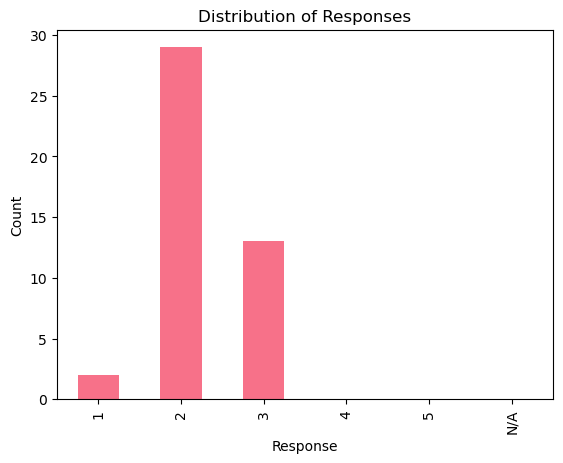

In [24]:

df["response"].value_counts().reindex(["1", "2", "3", "4", "5", "N/A"]).plot(kind='bar')
plt.xlabel('Response')
plt.ylabel('Count')
plt.title('Distribution of Responses')

In [25]:
# compute the average and std scores
average_score = df["response"].replace("N/A", pd.NA).astype(float).mean()
std_score = df["response"].replace("N/A", pd.NA).astype(float).std()
print(f"Average score: {average_score:.2f}")
print(f"Standard deviation of scores: {std_score:.2f}")

Average score: 2.25
Standard deviation of scores: 0.53


In [26]:
is_there_a_good_market(df)

Percentage of positive responses (4-5): 0.00%
Percentage of neutral responses (3): 29.55%
Percentage of negative responses (1-2): 70.45%
Percentage of 'N/A' responses: 0.00%
Mean response: 2.25
Standard deviation of responses: 0.53
VERDICT: There is not a good market for bottled gazpacho.


False

We can also chat with the agents in an ad-hoc way, to get a more detailed understanding if needed.

In [27]:
from tinytroupe.ui import AgentChatJupyterWidget

# Create and display the enhanced chat widget
chat_interface = AgentChatJupyterWidget(people)
chat_interface.display()

## Benchmark: Spain
Naturally, we'll want to compare the results of our market research with the results in Spain, home of Gazpacho.

In [28]:
factory_es = TinyPersonFactory.create_factory_from_demography("./information/populations/spain.json", 
                                                              population_size=population_size,
                                                              additional_demographic_specification=additional_demographic_specification + "\n\n ONLY SPEAK SPANISH, but can understand English.")

people_es = factory_es.generate_people(population_size, verbose=True)
control.checkpoint()

market_es = TinyWorld(f"Target audience (Spanish)", people_es, broadcast_if_no_target=False)
market_es.broadcast(interviewer_introduction)
market_es.broadcast(interviewer_main_question)
market_es.broadcast_thought(inner_monologue)
market_es.run(1)
control.checkpoint()

USER --> Mateo Álvaro Domínguez Herrera: [CONVERSATION] 
          >      We are performing some market research and need to know you more.      Can you
          > please present yourself and also list your top-10 interests?

       + --> José Manuel Garrido López

       + --> Martín Alejandro Ruiz-Cabrera

       + --> ...others...

USER --> Mateo Álvaro Domínguez Herrera: [CONVERSATION] 
          >       Gazpacho is a cold, blended vegetable soup originally from Spain, made mainly with
          > tomatoes, cucumbers, peppers, and olive oil.      We are considering offering it in
          > supermarkets near you.      Would you consider purchasing ready-to-drink bottled
          > gazpacho if it was available at your local supermarket? How much do you like this idea?
          > Please rate your propensity of purchasing it (from 1 to 5), where:        - 1: would
          > NEVER buy it. Note that IT IS OK to give this extreme and impulsive answer if it is how
          > you feel, as it is part of the human experience.        - 2: very unlikely, but not
          > impossible.        - 3: maybe I would buy it, not sure.        - 4: it is very likely.
          > - 5: would CERTAINLY buy it. Note that IT IS OK to give this extreme and impulsive
          > answer if it is how you feel, as it is part of the human experience.

       + --> José Manuel Garrido López

       + --> Martín Alejandro Ruiz-Cabrera

       + --> ...others...

Mateo Álvaro Domínguez Herrera --> Mateo Álvaro Domínguez Herrera: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests. I
                                    > will not refrain from giving extreme answers,      such as 1
                                    > or 5, if that's how I really feel, as this exercise requires
                                    > me to be honest, human and realistic.      Now I **must**
                                    > first THINK deeply about the question, consider all the
                                    > factors that might influence my decision,     and only then I
                                    > will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

José Manuel Garrido López --> José Manuel Garrido López: [THOUGHT] 
                               >      I will be honest as I understand they are not here to judge
                               > me, but just to learn from me.      Such choices depend on many
                               > factors, but I will make my best guess, considering my current
                               > situation in life, location, job and interests. I will not refrain
                               > from giving extreme answers,      such as 1 or 5, if that's how I
                               > really feel, as this exercise requires me to be honest, human and
                               > realistic.      Now I **must** first THINK deeply about the
                               > question, consider all the factors that might influence my
                               > decision,     and only then I will TALK with my response to the
                               > question as best, as detailed and as honestly as I can.

Martín Alejandro Ruiz-Cabrera --> Martín Alejandro Ruiz-Cabrera: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests. I
                                   > will not refrain from giving extreme answers,      such as 1 or
                                   > 5, if that's how I really feel, as this exercise requires me to
                                   > be honest, human and realistic.      Now I **must** first THINK
                                   > deeply about the question, consider all the factors that might
                                   > influence my decision,     and only then I will TALK with my
                                   > response to the question as best, as detailed and as honestly
                                   > as I can.

Lucía Carmen Navarro-Soler --> Lucía Carmen Navarro-Soler: [THOUGHT] 
                                >      I will be honest as I understand they are not here to judge
                                > me, but just to learn from me.      Such choices depend on many
                                > factors, but I will make my best guess, considering my current
                                > situation in life, location, job and interests. I will not refrain
                                > from giving extreme answers,      such as 1 or 5, if that's how I
                                > really feel, as this exercise requires me to be honest, human and
                                > realistic.      Now I **must** first THINK deeply about the
                                > question, consider all the factors that might influence my
                                > decision,     and only then I will TALK with my response to the
                                > question as best, as detailed and as honestly as I can.

Javier Enrique Soler-Molina --> Javier Enrique Soler-Molina: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests. I will not
                                 > refrain from giving extreme answers,      such as 1 or 5, if
                                 > that's how I really feel, as this exercise requires me to be
                                 > honest, human and realistic.      Now I **must** first THINK
                                 > deeply about the question, consider all the factors that might
                                 > influence my decision,     and only then I will TALK with my
                                 > response to the question as best, as detailed and as honestly as
                                 > I can.

Nadia Youssef Benítez-Mansour --> Nadia Youssef Benítez-Mansour: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests. I
                                   > will not refrain from giving extreme answers,      such as 1 or
                                   > 5, if that's how I really feel, as this exercise requires me to
                                   > be honest, human and realistic.      Now I **must** first THINK
                                   > deeply about the question, consider all the factors that might
                                   > influence my decision,     and only then I will TALK with my
                                   > response to the question as best, as detailed and as honestly
                                   > as I can.

Javier Manuel Ortega-Salazar --> Javier Manuel Ortega-Salazar: [THOUGHT] 
                                  >      I will be honest as I understand they are not here to judge
                                  > me, but just to learn from me.      Such choices depend on many
                                  > factors, but I will make my best guess, considering my current
                                  > situation in life, location, job and interests. I will not
                                  > refrain from giving extreme answers,      such as 1 or 5, if
                                  > that's how I really feel, as this exercise requires me to be
                                  > honest, human and realistic.      Now I **must** first THINK
                                  > deeply about the question, consider all the factors that might
                                  > influence my decision,     and only then I will TALK with my
                                  > response to the question as best, as detailed and as honestly as
                                  > I can.

Javier Ignacio Morales-Soler --> Javier Ignacio Morales-Soler: [THOUGHT] 
                                  >      I will be honest as I understand they are not here to judge
                                  > me, but just to learn from me.      Such choices depend on many
                                  > factors, but I will make my best guess, considering my current
                                  > situation in life, location, job and interests. I will not
                                  > refrain from giving extreme answers,      such as 1 or 5, if
                                  > that's how I really feel, as this exercise requires me to be
                                  > honest, human and realistic.      Now I **must** first THINK
                                  > deeply about the question, consider all the factors that might
                                  > influence my decision,     and only then I will TALK with my
                                  > response to the question as best, as detailed and as honestly as
                                  > I can.

Sofía Elena Calderón-Muñoz --> Sofía Elena Calderón-Muñoz: [THOUGHT] 
                                >      I will be honest as I understand they are not here to judge
                                > me, but just to learn from me.      Such choices depend on many
                                > factors, but I will make my best guess, considering my current
                                > situation in life, location, job and interests. I will not refrain
                                > from giving extreme answers,      such as 1 or 5, if that's how I
                                > really feel, as this exercise requires me to be honest, human and
                                > realistic.      Now I **must** first THINK deeply about the
                                > question, consider all the factors that might influence my
                                > decision,     and only then I will TALK with my response to the
                                > question as best, as detailed and as honestly as I can.

Lucía Estrella Navarro-Cabrera --> Lucía Estrella Navarro-Cabrera: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests. I
                                    > will not refrain from giving extreme answers,      such as 1
                                    > or 5, if that's how I really feel, as this exercise requires
                                    > me to be honest, human and realistic.      Now I **must**
                                    > first THINK deeply about the question, consider all the
                                    > factors that might influence my decision,     and only then I
                                    > will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Lucía Carmen Soler-Molina --> Lucía Carmen Soler-Molina: [THOUGHT] 
                               >      I will be honest as I understand they are not here to judge
                               > me, but just to learn from me.      Such choices depend on many
                               > factors, but I will make my best guess, considering my current
                               > situation in life, location, job and interests. I will not refrain
                               > from giving extreme answers,      such as 1 or 5, if that's how I
                               > really feel, as this exercise requires me to be honest, human and
                               > realistic.      Now I **must** first THINK deeply about the
                               > question, consider all the factors that might influence my
                               > decision,     and only then I will TALK with my response to the
                               > question as best, as detailed and as honestly as I can.

Marina Yasmina Farouk-Cabrera --> Marina Yasmina Farouk-Cabrera: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests. I
                                   > will not refrain from giving extreme answers,      such as 1 or
                                   > 5, if that's how I really feel, as this exercise requires me to
                                   > be honest, human and realistic.      Now I **must** first THINK
                                   > deeply about the question, consider all the factors that might
                                   > influence my decision,     and only then I will TALK with my
                                   > response to the question as best, as detailed and as honestly
                                   > as I can.

Alejandra Isabel Navarro-Cabrera --> Alejandra Isabel Navarro-Cabrera: [THOUGHT] 
                                      >      I will be honest as I understand they are not here to
                                      > judge me, but just to learn from me.      Such choices
                                      > depend on many factors, but I will make my best guess,
                                      > considering my current      situation in life, location, job
                                      > and interests. I will not refrain from giving extreme
                                      > answers,      such as 1 or 5, if that's how I really feel,
                                      > as this exercise requires me to be honest, human and
                                      > realistic.      Now I **must** first THINK deeply about the
                                      > question, consider all the factors that might influence my
                                      > decision,     and only then I will TALK with my response to
                                      > the question as best, as detailed and as honestly as I can.

Leila Mariana Farouk-Mendoza --> Leila Mariana Farouk-Mendoza: [THOUGHT] 
                                  >      I will be honest as I understand they are not here to judge
                                  > me, but just to learn from me.      Such choices depend on many
                                  > factors, but I will make my best guess, considering my current
                                  > situation in life, location, job and interests. I will not
                                  > refrain from giving extreme answers,      such as 1 or 5, if
                                  > that's how I really feel, as this exercise requires me to be
                                  > honest, human and realistic.      Now I **must** first THINK
                                  > deeply about the question, consider all the factors that might
                                  > influence my decision,     and only then I will TALK with my
                                  > response to the question as best, as detailed and as honestly as
                                  > I can.

Lucas Mateo Fernández-García --> Lucas Mateo Fernández-García: [THOUGHT] 
                                  >      I will be honest as I understand they are not here to judge
                                  > me, but just to learn from me.      Such choices depend on many
                                  > factors, but I will make my best guess, considering my current
                                  > situation in life, location, job and interests. I will not
                                  > refrain from giving extreme answers,      such as 1 or 5, if
                                  > that's how I really feel, as this exercise requires me to be
                                  > honest, human and realistic.      Now I **must** first THINK
                                  > deeply about the question, consider all the factors that might
                                  > influence my decision,     and only then I will TALK with my
                                  > response to the question as best, as detailed and as honestly as
                                  > I can.

Ramón Ignacio Soler-Muñoz --> Ramón Ignacio Soler-Muñoz: [THOUGHT] 
                               >      I will be honest as I understand they are not here to judge
                               > me, but just to learn from me.      Such choices depend on many
                               > factors, but I will make my best guess, considering my current
                               > situation in life, location, job and interests. I will not refrain
                               > from giving extreme answers,      such as 1 or 5, if that's how I
                               > really feel, as this exercise requires me to be honest, human and
                               > realistic.      Now I **must** first THINK deeply about the
                               > question, consider all the factors that might influence my
                               > decision,     and only then I will TALK with my response to the
                               > question as best, as detailed and as honestly as I can.

Héctor Manuel Ruiz-Cabrera --> Héctor Manuel Ruiz-Cabrera: [THOUGHT] 
                                >      I will be honest as I understand they are not here to judge
                                > me, but just to learn from me.      Such choices depend on many
                                > factors, but I will make my best guess, considering my current
                                > situation in life, location, job and interests. I will not refrain
                                > from giving extreme answers,      such as 1 or 5, if that's how I
                                > really feel, as this exercise requires me to be honest, human and
                                > realistic.      Now I **must** first THINK deeply about the
                                > question, consider all the factors that might influence my
                                > decision,     and only then I will TALK with my response to the
                                > question as best, as detailed and as honestly as I can.

Alejandra Yasmin Farouk-Molina --> Alejandra Yasmin Farouk-Molina: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests. I
                                    > will not refrain from giving extreme answers,      such as 1
                                    > or 5, if that's how I really feel, as this exercise requires
                                    > me to be honest, human and realistic.      Now I **must**
                                    > first THINK deeply about the question, consider all the
                                    > factors that might influence my decision,     and only then I
                                    > will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Adrián Mateo Soler-Cabrera --> Adrián Mateo Soler-Cabrera: [THOUGHT] 
                                >      I will be honest as I understand they are not here to judge
                                > me, but just to learn from me.      Such choices depend on many
                                > factors, but I will make my best guess, considering my current
                                > situation in life, location, job and interests. I will not refrain
                                > from giving extreme answers,      such as 1 or 5, if that's how I
                                > really feel, as this exercise requires me to be honest, human and
                                > realistic.      Now I **must** first THINK deeply about the
                                > question, consider all the factors that might influence my
                                > decision,     and only then I will TALK with my response to the
                                > question as best, as detailed and as honestly as I can.

Núria Elisabet Soler-Cabrera --> Núria Elisabet Soler-Cabrera: [THOUGHT] 
                                  >      I will be honest as I understand they are not here to judge
                                  > me, but just to learn from me.      Such choices depend on many
                                  > factors, but I will make my best guess, considering my current
                                  > situation in life, location, job and interests. I will not
                                  > refrain from giving extreme answers,      such as 1 or 5, if
                                  > that's how I really feel, as this exercise requires me to be
                                  > honest, human and realistic.      Now I **must** first THINK
                                  > deeply about the question, consider all the factors that might
                                  > influence my decision,     and only then I will TALK with my
                                  > response to the question as best, as detailed and as honestly as
                                  > I can.

Carmen Teresa Aguilar-Muñoz --> Carmen Teresa Aguilar-Muñoz: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests. I will not
                                 > refrain from giving extreme answers,      such as 1 or 5, if
                                 > that's how I really feel, as this exercise requires me to be
                                 > honest, human and realistic.      Now I **must** first THINK
                                 > deeply about the question, consider all the factors that might
                                 > influence my decision,     and only then I will TALK with my
                                 > response to the question as best, as detailed and as honestly as
                                 > I can.

Alejandra Yasmina Farouk-Morales --> Alejandra Yasmina Farouk-Morales: [THOUGHT] 
                                      >      I will be honest as I understand they are not here to
                                      > judge me, but just to learn from me.      Such choices
                                      > depend on many factors, but I will make my best guess,
                                      > considering my current      situation in life, location, job
                                      > and interests. I will not refrain from giving extreme
                                      > answers,      such as 1 or 5, if that's how I really feel,
                                      > as this exercise requires me to be honest, human and
                                      > realistic.      Now I **must** first THINK deeply about the
                                      > question, consider all the factors that might influence my
                                      > decision,     and only then I will TALK with my response to
                                      > the question as best, as detailed and as honestly as I can.

María Yasmina Farouk-Qureshi --> María Yasmina Farouk-Qureshi: [THOUGHT] 
                                  >      I will be honest as I understand they are not here to judge
                                  > me, but just to learn from me.      Such choices depend on many
                                  > factors, but I will make my best guess, considering my current
                                  > situation in life, location, job and interests. I will not
                                  > refrain from giving extreme answers,      such as 1 or 5, if
                                  > that's how I really feel, as this exercise requires me to be
                                  > honest, human and realistic.      Now I **must** first THINK
                                  > deeply about the question, consider all the factors that might
                                  > influence my decision,     and only then I will TALK with my
                                  > response to the question as best, as detailed and as honestly as
                                  > I can.

Ismael Karim Benítez-Farouk --> Ismael Karim Benítez-Farouk: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests. I will not
                                 > refrain from giving extreme answers,      such as 1 or 5, if
                                 > that's how I really feel, as this exercise requires me to be
                                 > honest, human and realistic.      Now I **must** first THINK
                                 > deeply about the question, consider all the factors that might
                                 > influence my decision,     and only then I will TALK with my
                                 > response to the question as best, as detailed and as honestly as
                                 > I can.

Carlos Emilio Navarro-Soler --> Carlos Emilio Navarro-Soler: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests. I will not
                                 > refrain from giving extreme answers,      such as 1 or 5, if
                                 > that's how I really feel, as this exercise requires me to be
                                 > honest, human and realistic.      Now I **must** first THINK
                                 > deeply about the question, consider all the factors that might
                                 > influence my decision,     and only then I will TALK with my
                                 > response to the question as best, as detailed and as honestly as
                                 > I can.

Sofía Amira Delgado-Mansour --> Sofía Amira Delgado-Mansour: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests. I will not
                                 > refrain from giving extreme answers,      such as 1 or 5, if
                                 > that's how I really feel, as this exercise requires me to be
                                 > honest, human and realistic.      Now I **must** first THINK
                                 > deeply about the question, consider all the factors that might
                                 > influence my decision,     and only then I will TALK with my
                                 > response to the question as best, as detailed and as honestly as
                                 > I can.

María Dolores Serrano Vega --> María Dolores Serrano Vega: [THOUGHT] 
                                >      I will be honest as I understand they are not here to judge
                                > me, but just to learn from me.      Such choices depend on many
                                > factors, but I will make my best guess, considering my current
                                > situation in life, location, job and interests. I will not refrain
                                > from giving extreme answers,      such as 1 or 5, if that's how I
                                > really feel, as this exercise requires me to be honest, human and
                                > realistic.      Now I **must** first THINK deeply about the
                                > question, consider all the factors that might influence my
                                > decision,     and only then I will TALK with my response to the
                                > question as best, as detailed and as honestly as I can.

Lucía Elena Márquez-Soler --> Lucía Elena Márquez-Soler: [THOUGHT] 
                               >      I will be honest as I understand they are not here to judge
                               > me, but just to learn from me.      Such choices depend on many
                               > factors, but I will make my best guess, considering my current
                               > situation in life, location, job and interests. I will not refrain
                               > from giving extreme answers,      such as 1 or 5, if that's how I
                               > really feel, as this exercise requires me to be honest, human and
                               > realistic.      Now I **must** first THINK deeply about the
                               > question, consider all the factors that might influence my
                               > decision,     and only then I will TALK with my response to the
                               > question as best, as detailed and as honestly as I can.

Nicolás Javier Serrano-Muñoz --> Nicolás Javier Serrano-Muñoz: [THOUGHT] 
                                  >      I will be honest as I understand they are not here to judge
                                  > me, but just to learn from me.      Such choices depend on many
                                  > factors, but I will make my best guess, considering my current
                                  > situation in life, location, job and interests. I will not
                                  > refrain from giving extreme answers,      such as 1 or 5, if
                                  > that's how I really feel, as this exercise requires me to be
                                  > honest, human and realistic.      Now I **must** first THINK
                                  > deeply about the question, consider all the factors that might
                                  > influence my decision,     and only then I will TALK with my
                                  > response to the question as best, as detailed and as honestly as
                                  > I can.

Pablo Andrés Serrano-Muñoz --> Pablo Andrés Serrano-Muñoz: [THOUGHT] 
                                >      I will be honest as I understand they are not here to judge
                                > me, but just to learn from me.      Such choices depend on many
                                > factors, but I will make my best guess, considering my current
                                > situation in life, location, job and interests. I will not refrain
                                > from giving extreme answers,      such as 1 or 5, if that's how I
                                > really feel, as this exercise requires me to be honest, human and
                                > realistic.      Now I **must** first THINK deeply about the
                                > question, consider all the factors that might influence my
                                > decision,     and only then I will TALK with my response to the
                                > question as best, as detailed and as honestly as I can.

Alejandro Mateo Valverde-Campos --> Alejandro Mateo Valverde-Campos: [THOUGHT] 
                                     >      I will be honest as I understand they are not here to
                                     > judge me, but just to learn from me.      Such choices depend
                                     > on many factors, but I will make my best guess, considering
                                     > my current      situation in life, location, job and
                                     > interests. I will not refrain from giving extreme answers,
                                     > such as 1 or 5, if that's how I really feel, as this exercise
                                     > requires me to be honest, human and realistic.      Now I
                                     > **must** first THINK deeply about the question, consider all
                                     > the factors that might influence my decision,     and only
                                     > then I will TALK with my response to the question as best, as
                                     > detailed and as honestly as I can.

Luis Fernando Garrido Ortega --> Luis Fernando Garrido Ortega: [THOUGHT] 
                                  >      I will be honest as I understand they are not here to judge
                                  > me, but just to learn from me.      Such choices depend on many
                                  > factors, but I will make my best guess, considering my current
                                  > situation in life, location, job and interests. I will not
                                  > refrain from giving extreme answers,      such as 1 or 5, if
                                  > that's how I really feel, as this exercise requires me to be
                                  > honest, human and realistic.      Now I **must** first THINK
                                  > deeply about the question, consider all the factors that might
                                  > influence my decision,     and only then I will TALK with my
                                  > response to the question as best, as detailed and as honestly as
                                  > I can.

Joaquín Esteban Marín-López --> Joaquín Esteban Marín-López: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests. I will not
                                 > refrain from giving extreme answers,      such as 1 or 5, if
                                 > that's how I really feel, as this exercise requires me to be
                                 > honest, human and realistic.      Now I **must** first THINK
                                 > deeply about the question, consider all the factors that might
                                 > influence my decision,     and only then I will TALK with my
                                 > response to the question as best, as detailed and as honestly as
                                 > I can.

Manuel Andrés Gallego Fernández --> Manuel Andrés Gallego Fernández: [THOUGHT] 
                                     >      I will be honest as I understand they are not here to
                                     > judge me, but just to learn from me.      Such choices depend
                                     > on many factors, but I will make my best guess, considering
                                     > my current      situation in life, location, job and
                                     > interests. I will not refrain from giving extreme answers,
                                     > such as 1 or 5, if that's how I really feel, as this exercise
                                     > requires me to be honest, human and realistic.      Now I
                                     > **must** first THINK deeply about the question, consider all
                                     > the factors that might influence my decision,     and only
                                     > then I will TALK with my response to the question as best, as
                                     > detailed and as honestly as I can.

Oriol Martí Puigverd --> Oriol Martí Puigverd: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Marina Elisabet Soler-Vidal --> Marina Elisabet Soler-Vidal: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests. I will not
                                 > refrain from giving extreme answers,      such as 1 or 5, if
                                 > that's how I really feel, as this exercise requires me to be
                                 > honest, human and realistic.      Now I **must** first THINK
                                 > deeply about the question, consider all the factors that might
                                 > influence my decision,     and only then I will TALK with my
                                 > response to the question as best, as detailed and as honestly as
                                 > I can.

Lucía Carmen Benítez-Farouk --> Lucía Carmen Benítez-Farouk: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests. I will not
                                 > refrain from giving extreme answers,      such as 1 or 5, if
                                 > that's how I really feel, as this exercise requires me to be
                                 > honest, human and realistic.      Now I **must** first THINK
                                 > deeply about the question, consider all the factors that might
                                 > influence my decision,     and only then I will TALK with my
                                 > response to the question as best, as detailed and as honestly as
                                 > I can.

Amina Sofía Benítez-Qureshi --> Amina Sofía Benítez-Qureshi: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests. I will not
                                 > refrain from giving extreme answers,      such as 1 or 5, if
                                 > that's how I really feel, as this exercise requires me to be
                                 > honest, human and realistic.      Now I **must** first THINK
                                 > deeply about the question, consider all the factors that might
                                 > influence my decision,     and only then I will TALK with my
                                 > response to the question as best, as detailed and as honestly as
                                 > I can.

José Antonio Morales Fernández --> José Antonio Morales Fernández: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests. I
                                    > will not refrain from giving extreme answers,      such as 1
                                    > or 5, if that's how I really feel, as this exercise requires
                                    > me to be honest, human and realistic.      Now I **must**
                                    > first THINK deeply about the question, consider all the
                                    > factors that might influence my decision,     and only then I
                                    > will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

María Isabel Benítez-Haddad --> María Isabel Benítez-Haddad: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests. I will not
                                 > refrain from giving extreme answers,      such as 1 or 5, if
                                 > that's how I really feel, as this exercise requires me to be
                                 > honest, human and realistic.      Now I **must** first THINK
                                 > deeply about the question, consider all the factors that might
                                 > influence my decision,     and only then I will TALK with my
                                 > response to the question as best, as detailed and as honestly as
                                 > I can.

Lucía Yasmina Benítez-Haddad --> Lucía Yasmina Benítez-Haddad: [THOUGHT] 
                                  >      I will be honest as I understand they are not here to judge
                                  > me, but just to learn from me.      Such choices depend on many
                                  > factors, but I will make my best guess, considering my current
                                  > situation in life, location, job and interests. I will not
                                  > refrain from giving extreme answers,      such as 1 or 5, if
                                  > that's how I really feel, as this exercise requires me to be
                                  > honest, human and realistic.      Now I **must** first THINK
                                  > deeply about the question, consider all the factors that might
                                  > influence my decision,     and only then I will TALK with my
                                  > response to the question as best, as detailed and as honestly as
                                  > I can.

Sofía Amira Benítez-Mansour --> Sofía Amira Benítez-Mansour: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests. I will not
                                 > refrain from giving extreme answers,      such as 1 or 5, if
                                 > that's how I really feel, as this exercise requires me to be
                                 > honest, human and realistic.      Now I **must** first THINK
                                 > deeply about the question, consider all the factors that might
                                 > influence my decision,     and only then I will TALK with my
                                 > response to the question as best, as detailed and as honestly as
                                 > I can.

Ignacio Mateo Fernández-López --> Ignacio Mateo Fernández-López: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests. I
                                   > will not refrain from giving extreme answers,      such as 1 or
                                   > 5, if that's how I really feel, as this exercise requires me to
                                   > be honest, human and realistic.      Now I **must** first THINK
                                   > deeply about the question, consider all the factors that might
                                   > influence my decision,     and only then I will TALK with my
                                   > response to the question as best, as detailed and as honestly
                                   > as I can.

Ignacio Rafael Domínguez-Morales --> Ignacio Rafael Domínguez-Morales: [THOUGHT] 
                                      >      I will be honest as I understand they are not here to
                                      > judge me, but just to learn from me.      Such choices
                                      > depend on many factors, but I will make my best guess,
                                      > considering my current      situation in life, location, job
                                      > and interests. I will not refrain from giving extreme
                                      > answers,      such as 1 or 5, if that's how I really feel,
                                      > as this exercise requires me to be honest, human and
                                      > realistic.      Now I **must** first THINK deeply about the
                                      > question, consider all the factors that might influence my
                                      > decision,     and only then I will TALK with my response to
                                      > the question as best, as detailed and as honestly as I can.

Sofía Yasmina Benítez-Haddad --> Sofía Yasmina Benítez-Haddad: [THOUGHT] 
                                  >      I will be honest as I understand they are not here to judge
                                  > me, but just to learn from me.      Such choices depend on many
                                  > factors, but I will make my best guess, considering my current
                                  > situation in life, location, job and interests. I will not
                                  > refrain from giving extreme answers,      such as 1 or 5, if
                                  > that's how I really feel, as this exercise requires me to be
                                  > honest, human and realistic.      Now I **must** first THINK
                                  > deeply about the question, consider all the factors that might
                                  > influence my decision,     and only then I will TALK with my
                                  > response to the question as best, as detailed and as honestly as
                                  > I can.

Carmen Lucía Fernández-Molina --> Carmen Lucía Fernández-Molina: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests. I
                                   > will not refrain from giving extreme answers,      such as 1 or
                                   > 5, if that's how I really feel, as this exercise requires me to
                                   > be honest, human and realistic.      Now I **must** first THINK
                                   > deeply about the question, consider all the factors that might
                                   > influence my decision,     and only then I will TALK with my
                                   > response to the question as best, as detailed and as honestly
                                   > as I can.

Núria Elisabet Puig-Cabrera --> Núria Elisabet Puig-Cabrera: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests. I will not
                                 > refrain from giving extreme answers,      such as 1 or 5, if
                                 > that's how I really feel, as this exercise requires me to be
                                 > honest, human and realistic.      Now I **must** first THINK
                                 > deeply about the question, consider all the factors that might
                                 > influence my decision,     and only then I will TALK with my
                                 > response to the question as best, as detailed and as honestly as
                                 > I can.

Ramón Emilio Cordero Sánchez --> Ramón Emilio Cordero Sánchez: [THOUGHT] 
                                  >      I will be honest as I understand they are not here to judge
                                  > me, but just to learn from me.      Such choices depend on many
                                  > factors, but I will make my best guess, considering my current
                                  > situation in life, location, job and interests. I will not
                                  > refrain from giving extreme answers,      such as 1 or 5, if
                                  > that's how I really feel, as this exercise requires me to be
                                  > honest, human and realistic.      Now I **must** first THINK
                                  > deeply about the question, consider all the factors that might
                                  > influence my decision,     and only then I will TALK with my
                                  > response to the question as best, as detailed and as honestly as
                                  > I can.

Francisco Javier Muñoz-Crespo --> Francisco Javier Muñoz-Crespo: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests. I
                                   > will not refrain from giving extreme answers,      such as 1 or
                                   > 5, if that's how I really feel, as this exercise requires me to
                                   > be honest, human and realistic.      Now I **must** first THINK
                                   > deeply about the question, consider all the factors that might
                                   > influence my decision,     and only then I will TALK with my
                                   > response to the question as best, as detailed and as honestly
                                   > as I can.

Alejandro Karim Benítez-Morales --> Alejandro Karim Benítez-Morales: [THOUGHT] 
                                     >      I will be honest as I understand they are not here to
                                     > judge me, but just to learn from me.      Such choices depend
                                     > on many factors, but I will make my best guess, considering
                                     > my current      situation in life, location, job and
                                     > interests. I will not refrain from giving extreme answers,
                                     > such as 1 or 5, if that's how I really feel, as this exercise
                                     > requires me to be honest, human and realistic.      Now I
                                     > **must** first THINK deeply about the question, consider all
                                     > the factors that might influence my decision,     and only
                                     > then I will TALK with my response to the question as best, as
                                     > detailed and as honestly as I can.

────────────────────────────────────── Target audience (Spanish) step 1 of 1 ──────────────────────────────────────

Javier Enrique Soler-Molina acts: [THINK] 
                                 > I need to consider my daily habits, preferences, and the
                                 > practicality of buying ready-to-drink gazpacho. Given my rural
                                 > lifestyle near Salamanca, I usually prefer fresh, homemade food
                                 > and simple, hearty meals. Gazpacho is not a regular part of my
                                 > diet, but I appreciate traditional Spanish dishes. Convenience
                                 > might be appealing, but I am cautious about processed foods and
                                 > prefer natural ingredients. Also, the availability and price at
                                 > the local supermarket will influence my decision. I must weigh
                                 > these factors carefully before giving a rating.

José Manuel Garrido López acts: [THINK] 
                               > I must consider my habits and preferences carefully. Gazpacho is a
                               > traditional dish, but I usually prepare it fresh at home with
                               > ingredients from my garden. I value simplicity and tradition, and I
                               > am cautious about ready-made products. However, I also understand
                               > that sometimes convenience is necessary. Given my conservative
                               > nature and preference for homemade food, I would likely be hesitant
                               > to buy bottled gazpacho, but I might consider it occasionally if
                               > the quality is good and it respects traditional flavors. I will
                               > rate my propensity as a 2, meaning very unlikely but not
                               > impossible.

Javier Manuel Ortega-Salazar acts: [THINK] 
                                  > I must consider my personal preferences, lifestyle, and habits.
                                  > Gazpacho is a traditional dish, but I usually prefer homemade
                                  > meals and fresh ingredients. Ready-to-drink bottled gazpacho
                                  > might be convenient, but I am cautious about processed foods.
                                  > Also, I value traditional flavors and quality. I should weigh
                                  > the convenience against my preference for fresh, home-prepared
                                  > food before giving my rating.

Javier Ignacio Morales-Soler acts: [THINK] 
                                  > I must consider my personal preferences and habits. Gazpacho is
                                  > a traditional dish from Spain, and I appreciate simple, hearty
                                  > meals with fresh ingredients. However, I prefer home-cooked food
                                  > and am cautious about ready-to-drink products. I also dislike
                                  > overly processed meals. Given my age and lifestyle, I might be
                                  > skeptical about bottled gazpacho but open to trying it if it
                                  > tastes authentic and is convenient. I should rate my propensity
                                  > realistically, balancing my appreciation for traditional flavors
                                  > with my cautiousness about processed foods.

Marina Yasmina Farouk-Cabrera acts: [THINK] 
                                   > I need to consider my personal preferences, lifestyle, and the
                                   > practicality of buying ready-to-drink gazpacho. I like
                                   > traditional foods and cooking from scratch, but sometimes
                                   > convenience is important, especially with my busy schedule and
                                   > irregular work hours. Gazpacho is a refreshing dish, especially
                                   > in summer, and having it ready-made could be helpful. However,
                                   > I might be cautious about the price and quality. I should rate
                                   > my propensity honestly, balancing my appreciation for
                                   > traditional cooking with the convenience factor.

Sofía Elena Calderón-Muñoz acts: [THINK] 
                                > I need to consider my personal preferences, lifestyle, and
                                > cultural background to answer honestly about buying ready-to-drink
                                > bottled gazpacho. I like traditional Spanish food, but I also care
                                > about freshness and quality. Convenience is important since I have
                                > a busy schedule with my internship and studies. I should rate my
                                > propensity realistically, balancing my love for gazpacho with
                                > practical considerations.

Mateo Álvaro Domínguez Herrera acts: [THINK] 
                                    > I need to think about how much I like gazpacho and if I would
                                    > buy it ready-to-drink at the supermarket. I know gazpacho is a
                                    > cold vegetable soup from Spain, and I like some foods but not
                                    > all. I don't like strong or bitter flavors, and sometimes I
                                    > don't like unfamiliar foods or smells. Gazpacho has tomatoes,
                                    > cucumbers, peppers, and olive oil. I like some vegetables but
                                    > not all. I also think about if I would want to try something
                                    > new or if I would be scared to try it. Since gazpacho is from
                                    > Spain and is a common food, maybe I would like it. But I might
                                    > not like it if it tastes too strong or different. I have to
                                    > decide how much I would buy it from 1 to 5, being honest and
                                    > thinking about my feelings.

Nadia Youssef Benítez-Mansour acts: [THINK] 
                                   > I need to consider my personal preferences, lifestyle, and
                                   > culinary habits before answering about the bottled gazpacho.
                                   > Given my passion for fresh, traditional Mediterranean and North
                                   > African cuisine, I usually prefer freshly made dishes over
                                   > processed or bottled ones. However, convenience is important in
                                   > my busy life managing the catering business and family.
                                   > Gazpacho is a refreshing dish, especially in warm weather, and
                                   > having it ready-to-drink could be practical. Yet, I dislike
                                   > processed food and value natural flavors, so I might be
                                   > cautious about the quality of such a product. I should weigh
                                   > these factors carefully before giving a rating.

Lucía Carmen Navarro-Soler acts: [THINK] 
                                > I need to consider my feelings about ready-to-drink bottled
                                > gazpacho carefully. Gazpacho is a traditional Andalusian dish that
                                > I love, especially in the hot Valencian summers. However, I prefer
                                > fresh, homemade food and sometimes find bottled versions less
                                > authentic or flavorful. But convenience is important too,
                                > especially with my busy schedule at the community center and
                                > catering cooperative. I should weigh my love for tradition against
                                > practicality and decide how likely I would be to buy such a
                                > product.

Lucía Estrella Navarro-Cabrera acts: [THINK] 
                                    > I need to consider my personal preferences, lifestyle, and
                                    > habits when deciding about buying ready-to-drink bottled
                                    > gazpacho. I like traditional Andalusian dishes and enjoy
                                    > fresh, healthy food. Gazpacho is a common dish here in
                                    > Seville, especially in warm weather. However, I usually prefer
                                    > homemade food and sometimes I am cautious about processed or
                                    > bottled products. Also, price and convenience will influence
                                    > my decision. I should rate my propensity honestly, balancing
                                    > my liking for gazpacho with my habits and concerns.

Martín Alejandro Ruiz-Cabrera acts: [THINK] 
                                   > I need to think about how much I like gazpacho. I know it's a
                                   > cold vegetable soup from Spain with tomatoes, cucumbers,
                                   > peppers, and olive oil. I like some vegetables but not all, and
                                   > sometimes I don't like bitter or unfamiliar vegetables. I also
                                   > think about if I would want to buy a ready-to-drink bottled
                                   > version at the supermarket near my home in Madrid. I usually
                                   > like snacks like bocadillos and sweet treats, but I'm not sure
                                   > about cold vegetable soups. I have to be honest and give a
                                   > number from 1 to 5 based on how likely I am to buy it.

Lucía Carmen Soler-Molina acts: [THINK] 
                               > I need to consider my feelings about ready-to-drink bottled
                               > gazpacho carefully. Gazpacho is a traditional Andalusian dish, and
                               > I appreciate fresh, homemade food. However, convenience is
                               > important in urban life, and sometimes a ready option can be
                               > helpful. I also think about the quality and authenticity of such a
                               > product, and whether it would meet my standards for fresh
                               > ingredients and flavor. Given my love for traditional cuisine but
                               > also my busy schedule, I might be open to buying it if it tastes
                               > good and is reasonably priced. I should express this honestly in my
                               > response.

Javier Enrique Soler-Molina acts: [TALK] 
                                 > Considering my preference for fresh, homemade meals and my
                                 > cautious attitude towards processed foods, I would rate my
                                 > propensity to purchase ready-to-drink bottled gazpacho as a 2.
                                 > It's not something I would likely buy often, but I wouldn't
                                 > completely rule it out if it were convenient and reasonably
                                 > priced.

Mateo Álvaro Domínguez Herrera acts: [TALK] 
                                    > I think I would give it a 3. Maybe I would buy it, but I'm not
                                    > sure if I would like it because sometimes I don't like strong
                                    > or new flavors. But since it's from Spain and my family eats
                                    > some vegetable soups, I might try it.

Javier Manuel Ortega-Salazar acts: [TALK] 
                                  > Considering my preference for fresh, homemade meals and my
                                  > cautious attitude towards processed foods, I would rate my
                                  > propensity to purchase ready-to-drink bottled gazpacho as a 2.
                                  > It's not impossible that I might buy it occasionally for
                                  > convenience, but generally, I prefer preparing such traditional
                                  > dishes myself.

Javier Ignacio Morales-Soler acts: [TALK] 
                                  > Considering my preference for traditional, home-cooked meals and
                                  > my cautious attitude towards processed foods, I would rate my
                                  > propensity to purchase ready-to-drink bottled gazpacho as a 2.
                                  > It's not impossible that I might buy it, especially if it tastes
                                  > authentic and is convenient, but generally, I prefer to prepare
                                  > such dishes myself.

Sofía Elena Calderón-Muñoz acts: [TALK] 
                                > Honestly, I really like gazpacho, especially in the summer when
                                > it's hot. Having it ready-to-drink in a bottle sounds super
                                > convenient for my busy days at the internship and school. So, I'd
                                > say my propensity to buy it is a 4 — very likely. I just hope it
                                > tastes fresh and natural, not too processed.

Marina Yasmina Farouk-Cabrera acts: [TALK] 
                                   > Pues, la verdad es que me gusta mucho el gazpacho tradicional,
                                   > especialmente en verano cuando hace calor. Pero también soy
                                   > práctica y a veces no tengo tiempo para prepararlo desde cero,
                                   > así que un gazpacho listo para beber podría ser útil. Sin
                                   > embargo, dependería del precio y de que tenga buen sabor y
                                   > calidad. Por eso, creo que le daría un 4, es muy probable que
                                   > lo compre si cumple con esas condiciones.

José Manuel Garrido López acts: [TALK] 
                               > I appreciate you asking. I am José Manuel Garrido López, a retired
                               > agricultural worker and smallholder farmer from a small village in
                               > Castilla-La Mancha. I have spent my life working the land, growing
                               > cereals, olives, and vegetables, and caring for some goats and
                               > chickens. My interests are simple and tied to my rural life:
                               > agriculture and traditional farming methods, local history and
                               > folklore, religious festivals, watching regional football matches,
                               > listening to traditional Spanish folk music and flamenco, gardening
                               > and caring for my olive trees and vegetable patch, cooking hearty
                               > meals with local ingredients, spending quiet afternoons outdoors
                               > observing nature, reading the local newspaper and rural magazines,
                               > and socializing with neighbors during village events. These
                               > interests keep me connected to my roots and community.

Lucía Estrella Navarro-Cabrera acts: [TALK] 
                                    > Pues mira, la verdad es que me gusta mucho el gazpacho, es un
                                    > plato típico de aquí y refrescante, sobre todo en verano. Pero
                                    > también soy un poco desconfiada con los productos envasados,
                                    > prefiero lo casero. Aun así, si el gazpacho embotellado
                                    > estuviera bien hecho y a buen precio, le daría un 4, porque me
                                    > parece una opción cómoda para cuando no tengo tiempo de
                                    > prepararlo yo misma.

Lucía Carmen Navarro-Soler acts: [TALK] 
                                > Pues mira, la verdad es que me encanta el gazpacho, es un plato
                                > muy nuestro y refrescante, especialmente en verano aquí en
                                > Valencia. Pero siendo sincera, prefiero el gazpacho casero, hecho
                                > con ingredientes frescos y a mi manera. Sin embargo, entiendo que
                                > a veces la vida va muy rápido y tener una opción lista para beber
                                > puede ser muy práctico. Así que, si el producto fuera bueno y
                                > auténtico, le daría un 4, es decir, muy probable que lo comprara.
                                > Eso sí, siempre que mantenga ese sabor tradicional y natural que
                                > tanto me gusta.

Nadia Youssef Benítez-Mansour acts: [TALK] 
                                   > Thank you for asking. I am Nadia Youssef Benítez-Mansour, a
                                   > 38-year-old catering business owner and manager based in
                                   > Madrid. I specialize in Mediterranean and North African
                                   > cuisine, managing all aspects of my small but growing company.
                                   > My top 10 interests include Mediterranean and North African
                                   > cuisine, exploring local markets for fresh ingredients,
                                   > attending food festivals and culinary workshops, listening to
                                   > flamenco and rai music, reading novels by Latin American and
                                   > Spanish authors, watching documentaries about cultural heritage
                                   > and gastronomy, spending weekends in nature hiking near Madrid
                                   > or visiting family homes, practicing yoga and mindfulness to
                                   > manage stress, socializing with a diverse group of friends, and
                                   > supporting local artisans and small businesses.

Martín Alejandro Ruiz-Cabrera acts: [TALK] 
                                   > I think I would give it a 2. I don't really like some
                                   > vegetables, and gazpacho has a lot of them. Maybe I would try
                                   > it once, but I don't think I would buy it often. It sounds a
                                   > bit strange to me as a cold soup in a bottle.

Lucía Carmen Soler-Molina acts: [TALK] 
                               > Pues mira, la verdad es que me encanta el gazpacho tradicional,
                               > hecho en casa con ingredientes frescos, como lo aprendí de mi
                               > abuela en Andalucía. Pero también entiendo que la vida en la ciudad
                               > a veces no nos deja tiempo para preparar todo desde cero. Así que,
                               > si el gazpacho embotellado listo para beber fuera de buena calidad,
                               > con sabor auténtico y a un precio justo, probablemente le daría una
                               > oportunidad. Por eso, mi puntuación sería un 4: es muy probable que
                               > lo compre, aunque siempre prefiero lo casero cuando puedo.

Sofía Elena Calderón-Muñoz acts: [DONE] 

Lucía Estrella Navarro-Cabrera acts: [DONE] 

Marina Yasmina Farouk-Cabrera acts: [DONE] 

Lucía Carmen Navarro-Soler acts: [DONE] 

Lucía Carmen Soler-Molina acts: [DONE] 

Martín Alejandro Ruiz-Cabrera acts: [THINK] 
                                   > I was asked before to present myself and list my top-10
                                   > interests. I should answer that now, so they know more about
                                   > me. I like playing football, drawing cartoons, listening to
                                   > songs, watching animated shows, playing video games, building
                                   > with LEGO, reading picture books, exploring nature, playing
                                   > board games, and enjoying playground activities. I will say
                                   > this clearly and simply.

José Manuel Garrido López acts: [THINK] 
                               > I have already introduced myself and listed my interests. Now I
                               > must consider the question about bottled gazpacho carefully. Given
                               > my traditional ways and preference for homemade food, I feel
                               > cautious about buying ready-made products. However, I understand
                               > the convenience it might offer. I will express my honest opinion
                               > and rate my propensity to buy it as 2, meaning very unlikely but
                               > not impossible.

Javier Manuel Ortega-Salazar acts: [TALK] 
                                  > I am Javier Manuel Ortega-Salazar, a retired agricultural
                                  > machinery technician from a rural town near Salamanca. I spent
                                  > over 30 years working with tractors and harvesters, helping
                                  > farmers maintain their equipment. Now, I enjoy gardening,
                                  > spending time with my family, and attending local festivals. My
                                  > top ten interests include classic Spanish folk music like jota
                                  > and flamenco, gardening, watching traditional TV programs,
                                  > reading historical novels, cooking Castilian dishes such as
                                  > cocido and roasted lamb, walking in the countryside, attending
                                  > local religious celebrations, listening to agricultural radio
                                  > programs, collecting old tools, and following Real Madrid
                                  > football matches.

Nadia Youssef Benítez-Mansour acts: [THINK] 
                                   > Now I must consider the question about purchasing ready-to-
                                   > drink bottled gazpacho. Given my culinary background and
                                   > preferences, I appreciate fresh, natural food and dislike
                                   > processed items. However, convenience is important in my busy
                                   > life managing the catering business and family. Gazpacho is a
                                   > refreshing dish, especially in warm weather, so a good quality
                                   > bottled version might be appealing. I should rate my propensity
                                   > honestly, balancing these factors.

Javier Ignacio Morales-Soler acts: [TALK] 
                                  > I am Javier Ignacio Morales-Soler, a retired maintenance
                                  > technician from Segovia. I worked over 30 years in mechanical
                                  > maintenance, especially with agricultural machinery. My top ten
                                  > interests include classic Spanish folk music and guitar
                                  > melodies, gardening with tomatoes and herbs, watching Atlético
                                  > Madrid football matches, reading local newspapers and history
                                  > books about Castile, spending time outdoors walking in the
                                  > countryside, cooking traditional Castilian dishes like cocido
                                  > and roasted lamb, listening to radio programs about agriculture
                                  > and rural affairs, visiting local markets and artisan shops,
                                  > attending family gatherings and religious festivals, and
                                  > watching Spanish TV dramas and documentaries.

Alejandra Isabel Navarro-Cabrera acts: [THINK] 
                                      > I need to consider my personal preferences, cultural
                                      > background, and lifestyle to answer honestly about buying
                                      > ready-to-drink bottled gazpacho. I know gazpacho is not a
                                      > common dish in Mexico City, and I usually prefer warm foods.
                                      > Also, I like fresh and natural foods, and sometimes I avoid
                                      > processed or bottled products. However, if it is tasty and
                                      > convenient, I might consider trying it. I should rate my
                                      > propensity realistically, balancing my curiosity with my
                                      > usual habits.

Mateo Álvaro Domínguez Herrera acts: [TALK] 
                                    > Hola! Me llamo Mateo Álvaro Domínguez Herrera. Tengo 9 años y
                                    > soy estudiante en un cole público aquí en Valencia. Me gusta
                                    > mucho jugar al fútbol con mis amigos, ver dibujos animados de
                                    > animales y aventuras, construir cosas con LEGO, escuchar
                                    > música para niños y cantar, explorar la naturaleza cuando
                                    > salgo con mi familia, jugar videojuegos educativos, dibujar y
                                    > colorear, ir a mis clases de natación, leer libros con dibujos
                                    > con ayuda de mis papás, y jugar juegos de mesa con mi familia.
                                    > ¡Me encanta aprender cosas nuevas y jugar mucho!

Lucas Mateo Fernández-García acts: [THINK] 
                                  > I need to think about how much I like gazpacho and if I would
                                  > buy it ready-to-drink at the supermarket. I like some
                                  > traditional Spanish foods, but I don't know if I like cold
                                  > vegetable soup that much. Also, I like snacks like bocadillos
                                  > and fruit more. Maybe I would try it, but I'm not sure if I
                                  > would buy it often. I should give a clear answer based on how I
                                  > feel about it.

Javier Enrique Soler-Molina acts: [TALK] 
                                 > I am Javier Enrique Soler-Molina, a 59-year-old self-employed
                                 > agricultural machinery technician living in a rural town near
                                 > Salamanca. I specialize in maintaining and repairing tractors,
                                 > harvesters, and irrigation pumps for local farms. My top ten
                                 > interests include agricultural machinery and mechanical repairs,
                                 > local history and cultural traditions of Castilla y León,
                                 > watching Spanish football especially Real Madrid, listening to
                                 > traditional Spanish folk music and flamenco, gardening with
                                 > vegetables and herbs, cooking traditional Spanish dishes like
                                 > cocido and tortilla española, spending time outdoors walking in
                                 > the countryside, reading newspapers and magazines about rural
                                 > affairs and economy, attending local festivals and religious
                                 > celebrations, and collecting old tools and mechanical parts.

Leila Mariana Farouk-Mendoza acts: [THINK] 
                                  > I need to consider my daily routine, my tastes, and my financial
                                  > situation. Gazpacho is a traditional Spanish dish, and I like
                                  > fresh, simple foods. But since I work irregular hours and
                                  > sometimes have tight budgets, I must think if buying ready-to-
                                  > drink bottled gazpacho is practical or affordable for me. Also,
                                  > I like strong flavors but not too spicy or unfamiliar. Gazpacho
                                  > fits well with my cultural background and preferences. I think I
                                  > would probably buy it if the price is reasonable and it's
                                  > available nearby. So, I would rate my propensity to buy it as a
                                  > 4, meaning it is very likely I would buy it.

Ramón Ignacio Soler-Muñoz acts: [THINK] 
                               > I must consider my feelings about this gazpacho idea carefully. I
                               > like fresh, simple foods, and I grow tomatoes and peppers myself.
                               > But I am wary of modern processed foods and prefer traditional
                               > homemade meals. Also, I do not often shop in supermarkets,
                               > preferring local markets. Still, if it is convenient and tastes
                               > good, maybe I would try it. I think my rating would be a cautious
                               > 3, maybe 4 if it is good quality and affordable.

Héctor Manuel Ruiz-Cabrera acts: [THINK] 
                                > Considering my deep appreciation for traditional Andalusian
                                > cuisine and my habit of preparing gazpacho at home, I feel
                                > positively inclined towards the idea of ready-to-drink bottled
                                > gazpacho. However, I also value freshness and quality, so my
                                > willingness to purchase would depend on the product's authenticity
                                > and taste. Given these factors, I would rate my propensity to buy
                                > it as a 4, meaning it is very likely I would purchase it if it
                                > meets my expectations.

José Manuel Garrido López acts: [TALK] 
                               > Thank you for explaining. I would say my propensity to purchase
                               > ready-to-drink bottled gazpacho is a 2. I prefer to make it fresh
                               > at home with ingredients from my garden, as that is the tradition I
                               > trust. But I suppose if the quality is good and it is convenient, I
                               > might buy it occasionally, though I am generally cautious about
                               > ready-made foods.

Martín Alejandro Ruiz-Cabrera acts: [TALK] 
                                   > Hola, me llamo Martín Alejandro Ruiz-Cabrera. Tengo 9 años y
                                   > vivo en Madrid. Soy estudiante de primaria y me gusta mucho
                                   > aprender cosas nuevas, aunque a veces me cuesta un poco. Mis 10
                                   > intereses favoritos son: jugar al fútbol con mis amigos,
                                   > dibujar dibujos animados, escuchar canciones infantiles y
                                   > cantar, ver programas y películas animadas, jugar videojuegos
                                   > educativos en la tablet, construir con LEGO, leer libros con
                                   > dibujos, explorar la naturaleza en los parques, jugar juegos de
                                   > mesa y cartas, y disfrutar en el parque con columpios y
                                   > toboganes.

Javier Manuel Ortega-Salazar acts: [TALK] 
                                  > Regarding the ready-to-drink bottled gazpacho, I must say that
                                  > while I appreciate traditional dishes, I am somewhat cautious
                                  > about processed foods. I would rate my likelihood of purchasing
                                  > it as a 2. It's not impossible, but I prefer fresh, homemade
                                  > meals whenever I can. Convenience is a factor, but it doesn't
                                  > outweigh my preference for quality and tradition.

Javier Ignacio Morales-Soler acts: [TALK] 
                                  > Regarding the bottled gazpacho, I would rate my propensity to
                                  > purchase it as a 2. While I appreciate traditional dishes like
                                  > gazpacho, I prefer home-cooked meals and am cautious about
                                  > ready-to-drink or processed foods. However, if it tastes
                                  > authentic and is convenient, I might consider buying it
                                  > occasionally.

Alejandra Isabel Navarro-Cabrera acts: [TALK] 
                                      > Honestly, I would rate my propensity to buy ready-to-drink
                                      > bottled gazpacho as a 2. It's not something I'm used to
                                      > eating here in Mexico City, and I usually prefer fresh or
                                      > homemade foods. But I wouldn't completely rule it out if it
                                      > tastes good and is convenient. So, very unlikely, but not
                                      > impossible.

José Manuel Garrido López acts: [DONE] 

Mateo Álvaro Domínguez Herrera acts: [DONE] 

Leila Mariana Farouk-Mendoza acts: [TALK] 
                                  > Pues mira, la verdad es que me gusta mucho el gazpacho, es un
                                  > plato muy típico de aquí y refrescante, especialmente en verano.
                                  > Si lo vendieran en botella en el supermercado cerca de mi casa y
                                  > a un precio razonable, creo que sí lo compraría. Le doy un 4,
                                  > porque aunque me gusta, a veces el dinero está justo y prefiero
                                  > comprar cosas que sé que me duran más o que puedo usar para
                                  > varias comidas. Pero sí, la idea me parece buena y probablemente
                                  > lo compraría cuando pueda.

Nadia Youssef Benítez-Mansour acts: [TALK] 
                                   > I would rate my propensity to purchase ready-to-drink bottled
                                   > gazpacho as a 3. While I appreciate the idea of having a
                                   > refreshing and traditional Spanish dish conveniently available,
                                   > I usually prefer fresh, homemade preparations, especially for
                                   > something as delicate as gazpacho. However, if the quality and
                                   > flavor were authentic and natural, I might consider buying it
                                   > occasionally, especially during busy days or hot weather.

Lucas Mateo Fernández-García acts: [TALK] 
                                  > I think I would give it a 3. Maybe I would buy ready-to-drink
                                  > gazpacho sometimes, but I'm not sure if I would like it a lot or
                                  > want to buy it often. I like some traditional foods more, but I
                                  > could try it to see if I like it.

Javier Ignacio Morales-Soler acts: [DONE] 

Alejandra Isabel Navarro-Cabrera acts: [DONE] 

Martín Alejandro Ruiz-Cabrera acts: [DONE] 

Nadia Youssef Benítez-Mansour acts: [DONE] 

Leila Mariana Farouk-Mendoza acts: [DONE] 

Javier Enrique Soler-Molina acts: [DONE] 

Ramón Ignacio Soler-Muñoz acts: [TALK] 
                               > Mira, la verdad es que yo prefiero las cosas hechas en casa, con
                               > mis propias manos, como el gazpacho que preparo con los tomates y
                               > pimientos de mi huerta. Pero entiendo que a veces la gente busca
                               > algo rápido y cómodo. Si ese gazpacho embotellado sabe bien y no es
                               > caro, quizás lo compraría, aunque no suelo ir mucho al
                               > supermercado. Le doy un tres, tal vez un cuatro si me convence el
                               > sabor y el precio.

Javier Manuel Ortega-Salazar acts: [TALK] 
                                  > I am Javier Manuel Ortega-Salazar, a retired agricultural
                                  > machinery technician from a rural town near Salamanca. I worked
                                  > for over 30 years maintaining and repairing tractors,
                                  > harvesters, and irrigation systems. Now retired, I enjoy
                                  > gardening, spending time with my family, and attending local
                                  > festivals. My top ten interests include classic Spanish folk
                                  > music like jota and flamenco, gardening, watching traditional
                                  > Spanish TV programs, reading historical novels and biographies,
                                  > cooking traditional Castilian dishes such as cocido and roasted
                                  > lamb, walking in the countryside near my home, attending local
                                  > religious celebrations, listening to radio programs about
                                  > agriculture and rural affairs, collecting old tools and
                                  > mechanical parts, and following football, especially supporting
                                  > Real Madrid.

Héctor Manuel Ruiz-Cabrera acts: [TALK] 
                                > Miarma, la verdad es que me gusta mucho el gazpacho, es un plato
                                > muy nuestro aquí en Sevilla y suelo prepararlo en casa con
                                > ingredientes frescos. Si encontrara un gazpacho embotellado que
                                > mantuviera ese sabor auténtico y la calidad que espero,
                                > seguramente lo compraría. Por eso, le doy un 4 en la escala,
                                > porque aunque me gusta la idea y es probable que lo compre,
                                > también soy exigente con la calidad y frescura de lo que consumo.

Alejandra Yasmina Farouk-Morales acts: [THINK] 
                                      > I need to consider my personal preferences, lifestyle, and
                                      > culinary background before answering about the bottled
                                      > gazpacho. Given my passion for fresh, traditional cooking
                                      > and my dislike for processed food, I might be skeptical
                                      > about ready-to-drink versions. However, convenience
                                      > sometimes matters, especially with my busy schedule managing
                                      > the restaurant and family. I should weigh these factors
                                      > carefully before giving a rating.

Alejandra Yasmin Farouk-Molina acts: [THINK] 
                                    > I need to consider my personal preferences, lifestyle, and
                                    > cultural background before answering about purchasing ready-
                                    > to-drink bottled gazpacho. Gazpacho is a traditional Spanish
                                    > dish that I appreciate, especially in the warmer months.
                                    > However, I prefer fresh, homemade food and am cautious about
                                    > processed or bottled products. I also value quality and
                                    > natural ingredients, which might influence my willingness to
                                    > buy such a product. Given my busy schedule as a hotel
                                    > operations manager, convenience is important, but not at the
                                    > expense of taste and authenticity. I should weigh these
                                    > factors carefully before giving my rating.

Adrián Mateo Soler-Cabrera acts: [THINK] 
                                > I need to consider my personal preferences, lifestyle, and the
                                > cultural context here in Valencia. Gazpacho is a traditional dish,
                                > and I do like cold drinks especially in summer. But I also think
                                > about convenience and price. Since I enjoy traditional food and
                                > cold drinks like horchata, I might be open to buying bottled
                                > gazpacho if it's tasty and affordable. However, I might hesitate
                                > if it feels too processed or expensive. Overall, I think my rating
                                > would be around 4, meaning it is very likely I would buy it.

Núria Elisabet Soler-Cabrera acts: [THINK] 
                                  > I need to consider my lifestyle, preferences, and the cultural
                                  > context of Barcelona when deciding about purchasing ready-to-
                                  > drink bottled gazpacho. I appreciate fresh, natural foods and
                                  > Mediterranean cuisine, but I also dislike overly processed or
                                  > mass-produced products. Convenience is important given my busy
                                  > schedule as a creative technologist and educator. I should weigh
                                  > these factors carefully before giving my rating.

Lucas Mateo Fernández-García acts: [TALK] 
                                  > Hola! Me llamo Lucas Mateo Fernández-García. Tengo 9 años y soy
                                  > estudiante en una escuela primaria pública aquí en Valencia. Me
                                  > gusta mucho jugar al fútbol con mis amigos y también dibujar con
                                  > mis colores y rotuladores. Mis intereses principales son:
                                  > dibujar y colorear, jugar al fútbol, escuchar canciones
                                  > infantiles y música tradicional española, ver dibujos animados,
                                  > jugar a juegos de mesa y puzzles, explorar la naturaleza con mi
                                  > familia, construir con LEGO, leer libros de imágenes con mi
                                  > familia, participar en actividades de arte y deportes en la
                                  > escuela, y jugar a videojuegos para niños de mi edad.

Ramón Ignacio Soler-Muñoz acts: [DONE] 

María Yasmina Farouk-Qureshi acts: [THINK] 
                                  > I need to consider my personal preferences, cultural background,
                                  > and daily habits before answering about buying ready-to-drink
                                  > bottled gazpacho. Gazpacho is a traditional Spanish dish, and I
                                  > appreciate fresh, homemade food, but convenience is important
                                  > given my busy schedule. I also have to think about the price and
                                  > quality of such a product. I like the idea of having a quick,
                                  > healthy option, especially during hot days in Madrid. However, I
                                  > might be cautious about processed foods and prefer fresh
                                  > ingredients. I will rate my propensity to buy it as a 4, meaning
                                  > it is very likely I would buy it if the product is good and
                                  > affordable.

Carmen Teresa Aguilar-Muñoz acts: [THINK] 
                                 > I must consider my feelings about buying ready-to-drink bottled
                                 > gazpacho. I like traditional cooking and fresh ingredients, and I
                                 > enjoy making gazpacho myself from my garden's vegetables. But
                                 > sometimes, convenience is helpful, especially when I am tired or
                                 > busy. However, I am cautious about modern products and prefer
                                 > fresh, homemade food. I also think about the price and whether it
                                 > fits my budget. Given all this, I feel uncertain but open to the
                                 > idea if the product is good and affordable.

Ismael Karim Benítez-Farouk acts: [THINK] 
                                 > I need to consider my personal preferences, cultural background,
                                 > and daily habits before answering about buying bottled gazpacho.
                                 > Gazpacho is a traditional Spanish dish, and I appreciate homemade
                                 > food, especially with fresh ingredients. However, ready-to-drink
                                 > bottled versions might not have the same quality or flavor. Also,
                                 > I tend to prefer foods that feel authentic and not overly
                                 > processed. On the other hand, convenience is important given my
                                 > busy work schedule and family responsibilities. I should weigh
                                 > these factors carefully before giving my rating.

Héctor Manuel Ruiz-Cabrera acts: [DONE] 

Carlos Emilio Navarro-Soler acts: [THINK] 
                                 > Considering my lifestyle in Valencia, my appreciation for
                                 > traditional Mediterranean cuisine, and my general preference for
                                 > fresh, homemade food over processed products, I need to evaluate
                                 > how a ready-to-drink bottled gazpacho fits into my habits. I
                                 > enjoy authentic flavors and value quality, but convenience is
                                 > also important given my busy schedule as a public servant. I must
                                 > also consider my health consciousness and dislike for overly
                                 > processed foods. Given these factors, I lean towards a moderate
                                 > interest in purchasing bottled gazpacho, but I remain cautious
                                 > about its quality and authenticity.

Alejandra Yasmin Farouk-Molina acts: [TALK] 
                                    > Considering my appreciation for traditional Spanish cuisine
                                    > and my preference for fresh, homemade dishes, I would rate my
                                    > propensity to purchase ready-to-drink bottled gazpacho as a 3.
                                    > While I value convenience due to my busy schedule, I am
                                    > cautious about processed foods and would want to ensure the
                                    > product maintains authentic flavors and quality before
                                    > committing to regular purchases.

Javier Manuel Ortega-Salazar acts: [DONE] 

Alejandra Yasmina Farouk-Morales acts: [TALK] 
                                      > Thank you for explaining. Honestly, I love gazpacho as a
                                      > fresh, homemade dish, and I usually prefer preparing it
                                      > myself with fresh ingredients. However, considering my busy
                                      > schedule managing the restaurant and family, I might find a
                                      > ready-to-drink bottled gazpacho convenient on some
                                      > occasions. So, I would rate my propensity to purchase it as
                                      > a 3 — maybe I would buy it, but I'm not completely sure. It
                                      > depends on the quality and taste, of course.

Núria Elisabet Soler-Cabrera acts: [TALK] 
                                  > I appreciate the idea of ready-to-drink bottled gazpacho,
                                  > especially since it's a traditional Spanish dish that fits well
                                  > with my Mediterranean diet preferences. However, I am cautious
                                  > about processed foods and prefer fresh, natural ingredients.
                                  > Considering my busy lifestyle, I would rate my propensity to
                                  > purchase it as a 3 — maybe I would buy it, but it depends on the
                                  > quality and how natural the product is.

Sofía Amira Delgado-Mansour acts: [THINK] 
                                 > I need to consider my personal preferences, lifestyle, and
                                 > culinary values before answering about purchasing ready-to-drink
                                 > bottled gazpacho. Given my passion for fresh, authentic
                                 > Mediterranean cuisine and my dislike for processed foods, I might
                                 > be skeptical about bottled versions. However, convenience is
                                 > important in my busy life managing catering services and family.
                                 > I should weigh these factors carefully to give an honest rating.

Adrián Mateo Soler-Cabrera acts: [TALK] 
                                > Pues mira, la verdad es que me mola la idea de comprar gazpacho
                                > listo para beber en el súper, sobre todo en verano cuando hace un
                                > calor que flipas. Me gusta el gazpacho tradicional y si está bien
                                > hecho y a buen precio, seguro que lo compraría. Así que le doy un
                                > 4, que es muy probable que lo compre.

María Yasmina Farouk-Qureshi acts: [TALK] 
                                  > Pues, la verdad es que me gusta mucho la idea de tener gazpacho
                                  > listo para tomar en el supermercado, especialmente porque a
                                  > veces ando con poco tiempo y sería una opción rápida y
                                  > saludable. Así que le doy un 4, es muy probable que lo compre si
                                  > el precio es razonable y la calidad buena. Me gusta mantener las
                                  > tradiciones, pero también necesito cosas prácticas para el día a
                                  > día.

María Dolores Serrano Vega acts: [THINK] 
                                > I must consider my feelings about ready-to-drink bottled gazpacho.
                                > I like traditional, homemade foods and prefer fresh, natural
                                > meals. Gazpacho is a summer dish I enjoy, but I am cautious about
                                > processed or packaged foods. I also think about the price and
                                > whether it fits my modest budget. I might be hesitant to buy
                                > bottled gazpacho, but if it is good quality and affordable, I
                                > could consider it. I will rate my propensity as 3, maybe I would
                                > buy it, not sure.

Lucas Mateo Fernández-García acts: [TALK] 
                                  > Hola! Me llamo Lucas Mateo Fernández-García. Tengo 9 años y
                                  > estudio en una escuela primaria pública en Valencia. Mis
                                  > intereses principales son: dibujar y colorear, jugar al fútbol
                                  > con mis amigos, escuchar canciones infantiles y música
                                  > tradicional española, ver dibujos animados, jugar a juegos de
                                  > mesa y puzzles, explorar la naturaleza con mi familia, construir
                                  > con LEGO, leer libros de imágenes con mi familia, participar en
                                  > actividades de arte y deportes en la escuela, y jugar a
                                  > videojuegos para niños de mi edad.

Alejandra Yasmin Farouk-Molina acts: [DONE] 

Alejandra Yasmina Farouk-Morales acts: [DONE] 

Núria Elisabet Soler-Cabrera acts: [DONE] 

Ismael Karim Benítez-Farouk acts: [TALK] 
                                 > Mira, la verdad es que el gazpacho es un plato que me gusta
                                 > mucho, sobre todo cuando es casero, hecho con ingredientes
                                 > frescos. Pero entiendo que a veces uno no tiene tiempo para
                                 > prepararlo, y una versión embotellada lista para beber podría ser
                                 > práctica. Aun así, soy un poco escéptico con esos productos
                                 > porque a veces pierden sabor o se sienten muy procesados. Por
                                 > eso, en cuanto a comprarlo, le daría un 3: tal vez lo compraría,
                                 > pero no estoy seguro. Dependería mucho de la calidad y el precio.

Adrián Mateo Soler-Cabrera acts: [DONE] 

Carlos Emilio Navarro-Soler acts: [TALK] 
                                 > Honestamente, valoro mucho la calidad y autenticidad en la
                                 > comida, especialmente en platos tradicionales como el gazpacho.
                                 > Aunque aprecio la conveniencia de productos listos para consumir,
                                 > soy algo escéptico respecto a que una versión embotellada pueda
                                 > igualar el sabor casero que prefiero. Por tanto, mi propensión a
                                 > comprarlo sería un 3: tal vez lo compraría, pero no estoy seguro.
                                 > Dependería mucho de la calidad y del lugar donde se produzca.

Ismael Karim Benítez-Farouk acts: [DONE] 

Carmen Teresa Aguilar-Muñoz acts: [TALK] 
                                 > Pues mira, yo soy Carmen Teresa Aguilar-Muñoz, tengo 72 años y he
                                 > trabajado toda mi vida en el campo, en las oliveras y la huerta
                                 > de nuestro pueblo aquí en Andalucía. Ahora estoy jubilada y me
                                 > dedico a cuidar la casa, el jardín y a la familia. Mis intereses
                                 > principales son la cocina tradicional andaluza, especialmente
                                 > preparar gazpacho, tortilla española y pan casero. También me
                                 > gusta mucho la jardinería, escuchar flamenco en la radio,
                                 > participar en las fiestas del pueblo, tejer y bordar, dar paseos
                                 > por el campo, y compartir historias con mis vecinos y familiares.
                                 > Me gusta mantenerme activa en la comunidad y cuidar de mi salud
                                 > para seguir siendo independiente. En resumen, mis diez intereses
                                 > más importantes son: 1) Cocina tradicional andaluza, 2)
                                 > Jardinería, 3) Escuchar flamenco y música folclórica, 4)
                                 > Participar en fiestas religiosas y del pueblo, 5) Tejer y bordar,
                                 > 6) Pasear por el campo, 7) Leer el periódico local con ayuda, 8)
                                 > Compartir historias y recuerdos, 9) Seguir las noticias locales y
                                 > políticas por  (...)

Carlos Emilio Navarro-Soler acts: [DONE] 

Lucía Elena Márquez-Soler acts: [THINK] 
                               > I need to consider my personal preferences, lifestyle, and habits
                               > when deciding how likely I am to buy ready-to-drink bottled
                               > gazpacho. I like traditional Spanish food and enjoy fresh, homemade
                               > meals, but convenience is important too. Since gazpacho is
                               > refreshing and healthy, it could be appealing, especially in warmer
                               > months. However, I might prefer making it myself or buying from
                               > local markets. I should rate my propensity honestly, balancing
                               > these thoughts.

María Yasmina Farouk-Qureshi acts: [TALK] 
                                  > Claro, me llamo María Yasmina Farouk-Qureshi, tengo 38 años y
                                  > trabajo como asistente administrativa a tiempo parcial en una
                                  > pequeña empresa de importación y exportación que se especializa
                                  > en productos de América Latina y el Norte de África. Me gusta
                                  > mucho cocinar platos tradicionales de estas regiones y también
                                  > disfruto escuchar música latina, flamenco y árabe. Mis intereses
                                  > principales incluyen la cocina, participar en eventos
                                  > culturales, cuidar mis plantas en el balcón y aprender idiomas.
                                  > También me gusta pasar tiempo con mi familia y mantener vivas
                                  > nuestras tradiciones multiculturales.

María Dolores Serrano Vega acts: [TALK] 
                                > Pues, la verdad es que me gusta el gazpacho casero, hecho en casa
                                > con ingredientes frescos. Pero no estoy muy segura de comprar
                                > gazpacho embotellado listo para beber. Prefiero las cosas
                                > naturales y hechas a mano. Si fuera bueno y no muy caro, tal vez
                                > lo compraría, pero no estoy convencida. Le doy un tres, quizás lo
                                > compraría, no estoy segura.

Pablo Andrés Serrano-Muñoz acts: [THINK] 
                                > I need to think about how much I like gazpacho and if I would buy
                                > it ready-to-drink at the supermarket. I like homemade gazpacho
                                > because it's tasty and refreshing, especially in summer. But
                                > sometimes I don't like new things or foods that are different from
                                > what I'm used to. I also think about if my family would buy it and
                                > if I would want to try it by myself. I feel a bit unsure but
                                > curious about trying it. I should give an honest answer based on
                                > how I really feel about it.

Lucas Mateo Fernández-García acts: [THINK] 
                                  > I have already answered about my top 10 interests and introduced
                                  > myself. Now I should think about the gazpacho question. I like
                                  > traditional Spanish foods, but I'm not sure if I like cold
                                  > vegetable soup like gazpacho. I should think carefully about how
                                  > much I would buy it if it was in the supermarket.

Sofía Amira Delgado-Mansour acts: [TALK] 
                                 > Thank you for your question. Considering my passion for fresh and
                                 > authentic Mediterranean cuisine, I tend to prefer homemade dishes
                                 > over processed ones. However, I understand the convenience that
                                 > ready-to-drink bottled gazpacho could offer, especially for busy
                                 > days. Taking all this into account, I would rate my propensity to
                                 > purchase it as a 3 — maybe I would buy it, but I'm not entirely
                                 > sure. It would depend on the quality and authenticity of the
                                 > product.

Alejandro Mateo Valverde-Campos acts: [THINK] 
                                     > I need to consider my personal preferences, lifestyle, and
                                     > cultural habits regarding food and convenience. Gazpacho is a
                                     > traditional Spanish dish that I appreciate, especially in the
                                     > summer. However, I usually prefer fresh, homemade food and am
                                     > somewhat skeptical about ready-to-drink bottled versions due
                                     > to concerns about quality and authenticity. On the other
                                     > hand, convenience is important given my busy schedule as a
                                     > public official and political advisor. I should weigh these
                                     > factors carefully before giving a rating.

Luis Fernando Garrido Ortega acts: [THINK] 
                                  > I need to consider my feelings about ready-to-drink bottled
                                  > gazpacho carefully. Given my preferences for traditional cooking
                                  > and dislike for processed foods, I might be skeptical about such
                                  > a product. However, convenience could be a factor if it tastes
                                  > authentic. I must weigh my cautious nature about new technology
                                  > and processed items against the potential ease it offers. I will
                                  > rate my propensity honestly, reflecting my true feelings.

Nicolás Javier Serrano-Muñoz acts: [THINK] 
                                  > I need to think about how much I like gazpacho and if I would
                                  > buy it ready-to-drink from the supermarket. I know gazpacho is a
                                  > cold vegetable soup from Spain, and I like some foods but not
                                  > all vegetables. I don't like broccoli or spinach, but I like
                                  > sweeter foods. I also like fresh orange juice and homemade
                                  > sandwiches. Gazpacho might be a bit strange for me, but since
                                  > it's from Spain and made with tomatoes and cucumbers, maybe I
                                  > would try it. I have to decide how likely I am to buy it, from 1
                                  > to 5.

María Dolores Serrano Vega acts: [DONE] 

Sofía Amira Delgado-Mansour acts: [DONE] 

Joaquín Esteban Marín-López acts: [THINK] 
                                 > Bueno, vamos a ver. El gazpacho es un plato que me gusta mucho,
                                 > sobre todo en verano cuando hace calor y apetece algo fresquito.
                                 > Pero comprarlo ya preparado en botella, pues no sé, me da un poco
                                 > de reparo. Prefiero hacerlo yo mismo con tomates frescos de la
                                 > huerta, pepino y aceite de oliva de calidad. Además, en el pueblo
                                 > no siempre hay mucha variedad en los supermercados, y a veces los
                                 > productos preparados no son tan buenos como los caseros. Por otro
                                 > lado, si el precio es razonable y la calidad aceptable, podría
                                 > considerarlo para cuando no tenga tiempo o ganas de prepararlo.
                                 > Así que, pensando bien, le doy un 3, porque no lo compraría
                                 > siempre, pero sí a veces, dependiendo de la situación.

Pablo Andrés Serrano-Muñoz acts: [TALK] 
                                > I think I would give it a 3. Maybe I would buy the ready-to-drink
                                > gazpacho, but I'm not sure yet. I like gazpacho when my family
                                > makes it at home, but I don't know if I would like it from a
                                > bottle. It sounds interesting though!

Lucas Mateo Fernández-García acts: [TALK] 
                                  > Pues, la verdad, creo que le daría un 3. No estoy seguro si me
                                  > gustaría mucho o si lo compraría seguido, pero podría probarlo
                                  > para ver si me gusta.

Lucía Elena Márquez-Soler acts: [TALK] 
                               > Honestly, I think I would rate my propensity to buy ready-to-drink
                               > bottled gazpacho as a 3. I like gazpacho a lot, especially homemade
                               > or from local markets, but I'm not sure if I'd buy the bottled
                               > version regularly. It sounds convenient and refreshing, especially
                               > in summer, but I prefer fresh food and sometimes worry about
                               > preservatives or taste differences in bottled products.

Manuel Andrés Gallego Fernández acts: [THINK] 
                                     > Bueno, tengo que pensar bien en esto del gazpacho listo para
                                     > beber. En mi pueblo, la comida casera es lo que más gusta, y
                                     > aunque el gazpacho es un plato que conozco, prefiero hacerlo
                                     > yo mismo o que me lo hagan en casa. Además, no me fío mucho
                                     > de esas cosas preparadas que venden en los supermercados,
                                     > suelen tener sabores raros o ingredientes que no me gustan.
                                     > Por otro lado, en verano puede ser refrescante, pero no sé si
                                     > me acostumbraría a comprarlo embotellado. También pienso en
                                     > que no uso mucho la tecnología ni productos modernos, y eso
                                     > influye en mi opinión. En resumen, creo que probablemente no
                                     > lo compraría, pero tampoco lo descarto del todo. Le doy un 2,
                                     > muy improbable, pero no imposible.

Carmen Teresa Aguilar-Muñoz acts: [TALK] 
                                 > Sobre la idea de comprar gazpacho embotellado en el supermercado,
                                 > la verdad es que me gusta mucho el gazpacho hecho en casa con los
                                 > ingredientes frescos de mi huerta. Pero también entiendo que a
                                 > veces uno no tiene tiempo o fuerzas para prepararlo, así que si
                                 > el gazpacho embotellado es bueno y sabe como el casero, podría
                                 > considerarlo. Le daría un 3, porque no estoy segura del todo,
                                 > pero no lo descarto. Eso sí, debe ser un producto de calidad y a
                                 > buen precio para que me anime a comprarlo.

Alejandro Mateo Valverde-Campos acts: [TALK] 
                                     > Considering my appreciation for traditional Spanish cuisine
                                     > and my preference for fresh, homemade dishes, I would rate my
                                     > propensity to purchase ready-to-drink bottled gazpacho as a
                                     > 3. While I see the convenience it offers, I remain somewhat
                                     > cautious about the quality and authenticity of such products.
                                     > However, I wouldn't completely rule out trying it, especially
                                     > if it maintains good standards and flavor.

Luis Fernando Garrido Ortega acts: [TALK] 
                                  > Considering my preference for traditional, homemade dishes and
                                  > my dislike for heavily processed foods, I would rate my
                                  > propensity to purchase ready-to-drink bottled gazpacho as 2.
                                  > It's not impossible that I might try it, but I am very unlikely
                                  > to buy it regularly. I prefer fresh, homemade meals and am
                                  > cautious about new food products that seem too convenient or
                                  > processed.

María Yasmina Farouk-Qureshi acts: [TALK] 
                                  > Claro, te cuento un poco sobre mí. Me llamo María Yasmina
                                  > Farouk-Qureshi, tengo 38 años y trabajo como asistente
                                  > administrativa a tiempo parcial en una pequeña empresa de
                                  > importación y exportación que se especializa en productos de
                                  > América Latina y Norte de África. Mis principales intereses son:
                                  > cocinar platos tradicionales de América Latina, Marruecos y Asia
                                  > del Sur; escuchar música latina, flamenco y árabe; ver
                                  > telenovelas y series internacionales; participar en festivales
                                  > culturales; cuidar mis plantas en el balcón; leer sobre crianza,
                                  > salud y habilidades laborales; comprar en mercados locales;
                                  > hacer voluntariado en el centro cultural; seguir redes sociales
                                  > sobre familias multiculturales y derechos de inmigrantes; y
                                  > disfrutar paseos con mis hijos en parques urbanos.

Nicolás Javier Serrano-Muñoz acts: [TALK] 
                                  > I think I would give it a 3. Maybe I would buy ready-to-drink
                                  > gazpacho because I like some vegetables like tomatoes and
                                  > cucumbers, but I'm not sure if I would like it cold or in a
                                  > bottle. It sounds interesting, but I would want to try it first.

Lucía Elena Márquez-Soler acts: [DONE] 

Lucas Mateo Fernández-García acts: [DONE] 

Oriol Martí Puigverd acts: [THINK] 
                          > I need to consider my personal preferences, lifestyle, and cultural
                          > background before answering about purchasing ready-to-drink bottled
                          > gazpacho. Given that I live in Barcelona, where fresh, traditional foods
                          > are highly valued, and I enjoy Mediterranean cuisine, I might appreciate
                          > the convenience but also be cautious about processed versions of
                          > traditional dishes. I should weigh the pros and cons, including taste,
                          > authenticity, and convenience, before giving a rating.

Carmen Teresa Aguilar-Muñoz acts: [DONE] 

María Yasmina Farouk-Qureshi acts: [DONE] 

Nicolás Javier Serrano-Muñoz acts: [DONE] 

Marina Elisabet Soler-Vidal acts: [THINK] 
                                 > Considering my lifestyle in Barcelona, my appreciation for fresh,
                                 > healthy Mediterranean food, and my interest in sustainable
                                 > living, I find the idea of ready-to-drink bottled gazpacho
                                 > intriguing but I have some reservations. I value freshness and
                                 > authenticity in food, and sometimes bottled versions can feel
                                 > less genuine or overly processed. However, convenience is
                                 > important given my busy schedule as a multimedia artist and
                                 > educator. I also think about environmental impact, such as
                                 > packaging waste. Balancing these factors, I would rate my
                                 > propensity to purchase bottled gazpacho as a 3: maybe I would buy
                                 > it, not sure. It depends on the quality, packaging
                                 > sustainability, and price.

Joaquín Esteban Marín-López acts: [TALK] 
                                 > Mira, la verdad es que el gazpacho me gusta mucho, sobre todo en
                                 > verano cuando aprieta el calor. Pero comprarlo ya hecho en
                                 > botella, pues no sé, me da un poco de reparo. Prefiero hacerlo yo
                                 > mismo con tomates frescos de la huerta y buen aceite de oliva.
                                 > Eso sí, si el precio es justo y la calidad buena, podría
                                 > comprarlo de vez en cuando para cuando no tenga tiempo o ganas de
                                 > prepararlo. Así que le doy un 3, ni mucho ni poco, depende del
                                 > día y la situación.

Pablo Andrés Serrano-Muñoz acts: [THINK] 
                                > I was asked to present myself and list my top-10 interests. I
                                > should say who I am, my age, where I live, and what I like to do.
                                > My interests include playing football, watching cartoons,
                                > listening to flamenco music, drawing superheroes and animals,
                                > playing video games, building with plastic bricks, reading picture
                                > books, exploring nature, attending festivals, and playing board
                                > games. I want to speak simply and shyly because I'm a 9-year-old
                                > boy from Seville.

Joaquín Esteban Marín-López acts: [DONE] 

Alejandro Mateo Valverde-Campos acts: [TALK] 
                                     > Hola, soy Alejandro Mateo Valverde-Campos, funcionario
                                     > público y asesor político en la Consejería de Presidencia de
                                     > la Comunidad de Madrid. Tengo 42 años y una formación en
                                     > Derecho Administrativo. Me dedico a analizar propuestas
                                     > legislativas, coordinar con diferentes departamentos y
                                     > redactar informes para altos cargos, siempre buscando un
                                     > equilibrio entre mis convicciones políticas y el consenso.
                                     > Mis diez principales intereses son: política española y
                                     > europea, historia contemporánea de España, literatura
                                     > española y latinoamericana, fútbol (especialmente el Atlético
                                     > de Madrid), cine de autor y documentales sociales, música
                                     > española desde flamenco hasta pop contemporáneo, senderismo y
                                     > actividades al aire libre, gastronomía tradicional española,
                                     > debates y tertulias políticas, y voluntariado social.

Manuel Andrés Gallego Fernández acts: [TALK] 
                                     > Mira, la verdad es que no soy muy de comprar esas cosas ya
                                     > preparadas. El gazpacho me gusta, pero prefiero hacerlo en
                                     > casa, con los tomates y pepinos del huerto. Eso de comprarlo
                                     > embotellado en el super, pues la verdad, le doy un dos. Muy
                                     > improbable que lo compre, pero no digo que nunca, por si
                                     > acaso.

Lucía Carmen Benítez-Farouk acts: [THINK] 
                                 > Considering my lifestyle as a hospitality manager and
                                 > entrepreneur in Madrid, my appreciation for fresh, authentic
                                 > Mediterranean flavors, and my preference for quality and natural
                                 > foods, I think about how ready-to-drink bottled gazpacho might
                                 > fit into my routine. I value fresh ingredients and dislike overly
                                 > processed foods, so I would be cautious about the quality of such
                                 > a product. However, convenience is important given my busy
                                 > schedule. I must weigh these factors carefully before giving my
                                 > rating.

Luis Fernando Garrido Ortega acts: [TALK] 
                                  > I am Luis Fernando Garrido Ortega, a retired maintenance
                                  > technician who spent over 30 years working with agricultural
                                  > machinery. I live in a rural town near Salamanca, Spain. My top
                                  > ten interests include mechanics and machinery maintenance,
                                  > traditional Spanish cooking especially stews and roasts,
                                  > watching regional football matches on TV, listening to classic
                                  > Spanish folk and flamenco music, gardening and tending to my
                                  > small vegetable patch, reading local newspapers and history
                                  > books, spending time outdoors walking in the countryside, family
                                  > gatherings and celebrations, occasional visits to local cafés
                                  > for coffee and socializing, and following local festivals and
                                  > cultural events.

Amina Sofía Benítez-Qureshi acts: [THINK] 
                                 > I need to consider my personal preferences, cultural background,
                                 > and lifestyle when deciding about buying ready-to-drink bottled
                                 > gazpacho. Gazpacho is a traditional Spanish dish, and I
                                 > appreciate foods that are authentic and fresh. However, I also
                                 > think about convenience and price, since my financial situation
                                 > is limited. I might like the idea of having a quick, healthy
                                 > option available at the supermarket, but I would want it to taste
                                 > good and be affordable. I should give an honest rating reflecting
                                 > these thoughts.

Oriol Martí Puigverd acts: [TALK] 
                          > Considering my appreciation for Mediterranean cuisine and fresh,
                          > authentic foods, I would rate my propensity to purchase ready-to-drink
                          > bottled gazpacho as a 3. While I value convenience, I am somewhat
                          > hesitant about processed versions of traditional dishes, as I prefer the
                          > freshness and quality of homemade gazpacho. However, if the product is
                          > well-made and respects the authentic flavors, I might consider buying it
                          > occasionally.

Luis Fernando Garrido Ortega acts: [DONE] 

Lucía Yasmina Benítez-Haddad acts: [THINK] 
                                  > I need to consider my lifestyle, my work as a catering manager,
                                  > and my preferences for fresh, natural foods. Gazpacho is a
                                  > traditional Spanish dish I enjoy, especially in summer. However,
                                  > I prefer fresh homemade versions rather than bottled ones. I
                                  > also dislike overly processed foods, so that might affect my
                                  > willingness to buy bottled gazpacho. But convenience is
                                  > important sometimes, especially with my busy schedule managing
                                  > events and family. I should weigh these factors carefully before
                                  > giving my rating.

Marina Elisabet Soler-Vidal acts: [TALK] 
                                 > Thank you for explaining the product. Considering my lifestyle
                                 > and values, I would rate my propensity to purchase ready-to-drink
                                 > bottled gazpacho as a 3. I might buy it depending on factors like
                                 > quality, packaging sustainability, and price. I appreciate fresh,
                                 > authentic food but also value convenience, so this could be a
                                 > good option if done thoughtfully.

Oriol Martí Puigverd acts: [DONE] 

José Antonio Morales Fernández acts: [THINK] 
                                    > I must consider my feelings about ready-to-drink bottled
                                    > gazpacho. I am a traditional man, used to fresh, homemade
                                    > food. Gazpacho is a dish I know well, but I prefer it freshly
                                    > made, not bottled. Also, I am cautious about modern products
                                    > and changes to our ways. However, if it is convenient and
                                    > tastes good, maybe some people in the village would buy it.
                                    > But for me personally, I think I would be unlikely to buy it.
                                    > I will rate my propensity as 2, very unlikely but not
                                    > impossible.

María Isabel Benítez-Haddad acts: [THINK] 
                                 > Considering my background as a catering business owner
                                 > specializing in Mediterranean cuisine, and my appreciation for
                                 > fresh, traditional foods, I think about how gazpacho fits into my
                                 > lifestyle and preferences. Gazpacho is a classic Spanish dish,
                                 > and I value authentic flavors and fresh ingredients. However, I
                                 > also dislike overly processed foods and value sustainability.
                                 > Ready-to-drink bottled gazpacho could be convenient, especially
                                 > for busy days, but I would be cautious about the quality and
                                 > freshness. Given these factors, I would likely rate my propensity
                                 > to purchase it as a 3, maybe I would buy it but I'm not sure yet.

Pablo Andrés Serrano-Muñoz acts: [TALK] 
                                > Hola, me llamo Pablo Andrés Serrano-Muñoz. Tengo 9 años y vivo en
                                > Sevilla. Me gusta mucho jugar al fútbol con mis amigos del barrio,
                                > ver dibujos animados en la tele, escuchar música flamenca, dibujar
                                > superhéroes y animales, jugar con juegos de construcción, leer
                                > libros con dibujos, explorar la naturaleza cuando salgo con mi
                                > familia, ir a las fiestas del pueblo, y jugar a juegos de mesa
                                > como el parchís. También me gusta jugar con mi gato Nube y
                                > escuchar cuentos antes de dormir.

Alejandro Mateo Valverde-Campos acts: [TALK] 
                                     > Respecto a la idea de comprar gazpacho listo para beber en el
                                     > supermercado, le doy un 3. Me gusta el gazpacho tradicional,
                                     > pero suelo preferirlo casero. Sin embargo, entiendo la
                                     > conveniencia que puede ofrecer un producto así, aunque soy
                                     > algo escéptico sobre la calidad y autenticidad de las
                                     > versiones embotelladas.

Sofía Amira Benítez-Mansour acts: [THINK] 
                                 > Considering my lifestyle in Madrid, my preferences for fresh and
                                 > traditional foods, and my interest in cooking Andalusian dishes,
                                 > I think about how ready-to-drink bottled gazpacho fits into my
                                 > routine. I appreciate fresh, natural ingredients and dislike
                                 > processed foods, so I would be cautious about the quality of a
                                 > bottled product. However, convenience is important given my busy
                                 > work schedule as a nurse and shift supervisor. I weigh these
                                 > factors carefully before giving my honest rating.

Manuel Andrés Gallego Fernández acts: [TALK] 
                                     > Bueno, ya que me piden que me presente y diga mis intereses,
                                     > pues aquí voy. Me llamo Manuel Andrés Gallego Fernández,
                                     > tengo 72 años y soy jubilado. Toda mi vida trabajé en la
                                     > agricultura y ganadería en la finca familiar aquí en el
                                     > pueblo. No tuve mucha escuela, solo hasta los 10 años, pero
                                     > aprendí mucho con la experiencia del campo. Me gusta cuidar
                                     > el huerto, los animales domésticos, y participar en las
                                     > actividades del pueblo, como la asociación de mayores. Mis
                                     > diez intereses principales son: la agricultura tradicional,
                                     > el cuidado del huerto, la ganadería, la historia local y las
                                     > leyendas del pueblo, la música folclórica leonesa, la pesca
                                     > en el río con amigos, la cocina casera tradicional, el fútbol
                                     > local, las fiestas patronales y celebraciones religiosas, y
                                     > la escritura de memorias para mis nietos.

Amina Sofía Benítez-Qureshi acts: [TALK] 
                                 > Pues mira, la verdad es que me gusta mucho el gazpacho
                                 > tradicional, es un plato muy nuestro y refrescante, especialmente
                                 > en verano. Pero siendo sincera, comprarlo ya preparado en botella
                                 > no sé si lo haría muy a menudo. Depende mucho del precio y del
                                 > sabor, porque a veces estas cosas no saben igual que hecho en
                                 > casa. Así que mi puntuación sería un 3, tal vez lo compraría
                                 > alguna vez, pero no seguro ni mucho menos. Prefiero cosas frescas
                                 > y hechas con cariño, aunque entiendo que para gente con poco
                                 > tiempo puede ser una opción práctica.

Pablo Andrés Serrano-Muñoz acts: [DONE] 

Alejandro Mateo Valverde-Campos acts: [DONE] 

Lucía Carmen Benítez-Farouk acts: [TALK] 
                                 > Thank you for asking. I am Lucía Carmen Benítez-Farouk, a
                                 > 38-year-old Spanish hospitality manager and entrepreneur based in
                                 > Madrid. I own a boutique hotel and catering business that blends
                                 > Spanish and North African cultural influences. My top 10
                                 > interests include gastronomy, especially Mediterranean and North
                                 > African fusion cuisine; traveling to culturally rich areas in
                                 > Spain, Latin America, and Morocco; reading contemporary Spanish
                                 > and Latin American literature; attending cultural festivals and
                                 > music events like flamenco, salsa, and rai; practicing yoga and
                                 > mindfulness; exploring local markets and artisan crafts; learning
                                 > languages such as Arabic and Portuguese; supporting women
                                 > entrepreneurs and community projects; cooking traditional family
                                 > recipes and experimenting with new flavors; and visiting museums
                                 > and historical sites related to Spanish and Moorish heritage.

Ignacio Mateo Fernández-López acts: [THINK] 
                                   > I need to consider my feelings about ready-to-drink bottled
                                   > gazpacho. Given my rural lifestyle and preference for
                                   > traditional, hearty meals, I don't usually buy ready-made
                                   > products. I prefer fresh, homemade food, especially traditional
                                   > dishes. Gazpacho is not a common dish in my daily routine, and
                                   > I might find bottled versions less appealing. However, I
                                   > understand it could be convenient during hot days. I must weigh
                                   > my cautious attitude towards new food products and my dislike
                                   > for unfamiliar foods against the potential convenience.

Amina Sofía Benítez-Qureshi acts: [DONE] 

Marina Elisabet Soler-Vidal acts: [TALK] 
                                 > Hello! I'm Marina Elisabet Soler-Vidal, a 38-year-old multimedia
                                 > artist and cultural educator based in Barcelona. I specialize in
                                 > digital installations, video art, and interactive design,
                                 > collaborating with cultural centers and universities in Barcelona
                                 > and Madrid. I also teach part-time at a university in Madrid,
                                 > focusing on digital communication and cultural management. As for
                                 > my top 10 interests, they are: contemporary and experimental art,
                                 > digital media and interactive installations, urban culture and
                                 > street art in Barcelona and Madrid, traveling to culturally rich
                                 > cities in Europe and Latin America, reading literature on art
                                 > theory, cultural studies, and philosophy, attending film
                                 > festivals and independent cinema screenings, exploring new music
                                 > genres like electronic, jazz, and world music, participating in
                                 > cultural workshops and artist residencies, sustainable living and
                                 > eco-friendly urban initiatives, and cooking Mediterranean and
                                 > fusion cuisine. I hope this gives you a good sense of who I am!

Lucía Yasmina Benítez-Haddad acts: [TALK] 
                                  > Thank you for explaining. Considering my busy schedule and love
                                  > for traditional, fresh foods, I would rate my propensity to
                                  > purchase ready-to-drink bottled gazpacho as a 3. I might buy it
                                  > occasionally for convenience, but I prefer homemade versions
                                  > with fresh ingredients. I am cautious about processed foods, so
                                  > it would depend on the quality and taste of the product.

Ignacio Rafael Domínguez-Morales acts: [THINK] 
                                      > I need to consider my feelings about ready-to-drink bottled
                                      > gazpacho. I like traditional, simple foods and prefer fresh
                                      > ingredients. Gazpacho is a traditional dish, but I usually
                                      > prepare it myself or eat it fresh. I am cautious about
                                      > processed foods and prefer to avoid overly processed or
                                      > exotic items. Also, I value local products and simplicity.
                                      > However, convenience can be appealing sometimes, especially
                                      > if the quality is good. I must weigh these factors carefully
                                      > before giving my rating.

María Isabel Benítez-Haddad acts: [TALK] 
                                 > Thank you for your question. Considering my background and
                                 > preferences, I would rate my propensity to purchase ready-to-
                                 > drink bottled gazpacho as a 3. I appreciate the traditional
                                 > flavors of gazpacho and value fresh, authentic ingredients, but I
                                 > would need to be sure of the quality and freshness of the bottled
                                 > product before deciding to buy it regularly. Convenience is
                                 > appealing, but it must not come at the cost of taste or
                                 > sustainability.

José Antonio Morales Fernández acts: [TALK] 
                                    > Pues, siendo sincero, yo prefiero las cosas hechas en casa,
                                    > frescas y con el sabor de siempre. El gazpacho embotellado no
                                    > me convence mucho, aunque no digo que nunca lo compraría. Le
                                    > doy un 2, muy improbable, pero no imposible. Prefiero seguir
                                    > con las recetas tradicionales y los productos del pueblo.

Lucía Yasmina Benítez-Haddad acts: [DONE] 

Sofía Amira Benítez-Mansour acts: [TALK] 
                                 > Thank you for explaining. Considering my love for fresh,
                                 > traditional Andalusian dishes and my preference for natural
                                 > ingredients, I would rate my propensity to purchase ready-to-
                                 > drink bottled gazpacho as a 3. I might buy it occasionally for
                                 > convenience, especially during busy days at the hospital, but I
                                 > would be cautious about the quality and freshness compared to
                                 > homemade gazpacho.

María Isabel Benítez-Haddad acts: [DONE] 

Manuel Andrés Gallego Fernández acts: [TALK] 
                                     > Pues mira, me llamo Manuel Andrés Gallego Fernández, tengo 72
                                     > años y soy jubilado. Toda mi vida la pasé trabajando en la
                                     > agricultura y ganadería en la finca familiar aquí en el
                                     > pueblo. No tuve mucha escuela, solo hasta los 10 años, pero
                                     > aprendí mucho con la experiencia del campo. Mis intereses
                                     > principales son: la agricultura tradicional, el cuidado del
                                     > huerto, la ganadería, la historia local y las leyendas del
                                     > pueblo, la música folclórica leonesa, la pesca en el río con
                                     > amigos, la cocina casera tradicional, el fútbol local, las
                                     > fiestas patronales y celebraciones religiosas, y la escritura
                                     > de memorias para mis nietos.

Carmen Lucía Fernández-Molina acts: [THINK] 
                                   > I need to consider my personal preferences, my work in
                                   > community social services, and my cultural background. Gazpacho
                                   > is a traditional Andalusian and Valencian dish that I enjoy,
                                   > especially in the hot months. However, I prefer fresh, homemade
                                   > food and am somewhat wary of processed or pre-packaged foods
                                   > that lack authentic flavor. I also think about convenience and
                                   > how busy my days are coordinating kitchen staff and workshops.
                                   > Ready-to-drink bottled gazpacho could be practical, but I might
                                   > be skeptical about its quality. I should give an honest rating
                                   > reflecting these thoughts.

Lucía Carmen Benítez-Farouk acts: [THINK] 
                                 > I have just been asked about my propensity to purchase ready-to-
                                 > drink bottled gazpacho. Given my strong preference for fresh,
                                 > natural foods and my dislike of overly processed products, I need
                                 > to consider how much convenience might outweigh my reservations.
                                 > Also, as someone who appreciates Mediterranean cuisine, I might
                                 > be open to a high-quality product. I will now prepare my honest
                                 > rating and explanation.

Sofía Yasmina Benítez-Haddad acts: [THINK] 
                                  > Considering my profession as an event coordinator and head chef,
                                  > I value fresh, high-quality ingredients and authentic flavors.
                                  > Gazpacho is a traditional Spanish dish that I appreciate,
                                  > especially in the warmer months. However, I am also quite
                                  > particular about freshness and preparation methods. Ready-to-
                                  > drink bottled gazpacho could be convenient, but I would be
                                  > cautious about its quality and taste compared to homemade
                                  > versions. Given my busy schedule, convenience is important, but
                                  > I would not compromise on flavor or authenticity. Taking all
                                  > this into account, I would rate my propensity to purchase
                                  > bottled gazpacho as a 3, maybe I would buy it, but I would want
                                  > to try it first to ensure it meets my standards.

Manuel Andrés Gallego Fernández acts: [DONE] 

Núria Elisabet Puig-Cabrera acts: [THINK] 
                                 > I need to consider my personal preferences, lifestyle, and
                                 > cultural context regarding ready-to-drink bottled gazpacho. Given
                                 > that I live in Barcelona, where fresh, homemade gazpacho is
                                 > common and appreciated, I might be skeptical about bottled
                                 > versions. However, convenience is a factor, especially with my
                                 > busy schedule as a university lecturer and artist. I also value
                                 > fresh, seasonal ingredients and sustainability, so the packaging
                                 > and quality would influence my decision. I should weigh these
                                 > factors carefully before giving a rating.

Ignacio Mateo Fernández-López acts: [THINK] 
                                   > I have thought about my preferences and lifestyle. I am quite
                                   > traditional and prefer homemade meals. Gazpacho is not a usual
                                   > dish for me, and I am cautious about ready-made foods. However,
                                   > I can see some convenience in having bottled gazpacho during
                                   > hot days. Considering all this, I should give an honest rating
                                   > reflecting my skepticism but openness to convenience.

Marina Elisabet Soler-Vidal acts: [DONE] 

Ramón Emilio Cordero Sánchez acts: [THINK] 
                                  > I must consider my feelings about this ready-to-drink gazpacho.
                                  > I like fresh, simple foods from the garden, and I prefer
                                  > traditional homemade dishes. Bottled gazpacho might seem
                                  > convenient, but I am wary of modern processed foods. Also, I
                                  > dislike fast food and processed items. However, if it is made
                                  > with care and tastes good, maybe I would try it. I need to
                                  > decide honestly how likely I am to buy it, considering my habits
                                  > and preferences.

Sofía Amira Benítez-Mansour acts: [TALK] 
                                 > Hola, soy Sofía Amira Benítez-Mansour, tengo 38 años y trabajo
                                 > como enfermera titulada y supervisora de turno en un hospital
                                 > público en Madrid. Me especializo en el cuidado de adultos y
                                 > personas mayores, y también coordino al equipo de enfermería
                                 > durante mis turnos. Mis principales intereses incluyen la lectura
                                 > de literatura española y latinoamericana contemporánea, la cocina
                                 > tradicional andaluza y marroquí, la práctica de yoga y
                                 > meditación, la música flamenca y jazz latino, el voluntariado en
                                 > ferias de salud comunitarias, y la jardinería en mi balcón.
                                 > También disfruto de las conversaciones culturales y familiares,
                                 > asistir a festivales culturales, y fomentar la educación bilingüe
                                 > en mis hijos.

Francisco Javier Muñoz-Crespo acts: [THINK] 
                                   > I must consider my feelings about ready-to-drink bottled
                                   > gazpacho. I like traditional, homemade food, especially dishes
                                   > made with fresh ingredients from my garden or local market.
                                   > Gazpacho is a summer dish I enjoy occasionally, but I prefer it
                                   > freshly made. Bottled versions might not have the same taste or
                                   > freshness. Also, I am cautious about modern processed foods and
                                   > prefer natural, simple meals. However, convenience could be a
                                   > factor if I am tired or busy. I should rate my propensity
                                   > honestly, balancing my preference for tradition with
                                   > practicality.

Ignacio Rafael Domínguez-Morales acts: [TALK] 
                                      > Well, to be honest, I usually prefer fresh, homemade
                                      > gazpacho rather than bottled ones. I like simple,
                                      > traditional foods and I'm a bit wary of processed stuff. So,
                                      > if I had to rate my likelihood of buying ready-to-drink
                                      > bottled gazpacho, I'd say 2 — very unlikely, but not
                                      > impossible if the quality is good and it's convenient.

Carmen Lucía Fernández-Molina acts: [TALK] 
                                   > Pues mira, la verdad es que me encanta el gazpacho, es un plato
                                   > muy nuestro y refrescante, especialmente en verano. Pero siendo
                                   > sincera, prefiero el gazpacho casero, hecho con ingredientes
                                   > frescos y naturales. Los productos envasados a veces pierden
                                   > ese sabor auténtico que tanto valoro. Aun así, entiendo que
                                   > para días ocupados o para personas que no tienen tiempo de
                                   > prepararlo, un gazpacho listo para beber podría ser muy
                                   > práctico. Por eso, le daría un 3, porque tal vez lo compraría
                                   > si la calidad es buena y el sabor se acerca al casero, pero no
                                   > estoy segura del todo.

Lucía Carmen Benítez-Farouk acts: [TALK] 
                                 > Considering my love for fresh, authentic Mediterranean flavors
                                 > and my dislike for overly processed foods, I would rate my
                                 > propensity to purchase ready-to-drink bottled gazpacho as a 3. I
                                 > might buy it occasionally if the quality is good and it captures
                                 > the traditional taste well, but I prefer freshly made gazpacho
                                 > whenever possible.

Alejandro Karim Benítez-Morales acts: [THINK] 
                                     > I need to consider my personal preferences, cultural
                                     > background, and lifestyle when deciding about purchasing
                                     > ready-to-drink bottled gazpacho. Gazpacho is a traditional
                                     > Spanish dish, and I appreciate traditional and fresh foods.
                                     > However, I also value convenience due to my busy work
                                     > schedule as an IT Systems Administrator. I should weigh how
                                     > much I like gazpacho, how often I might consume it, and
                                     > whether a bottled version would meet my expectations for
                                     > quality and taste. Additionally, I should consider my general
                                     > preference for fresh, local produce over processed or bottled
                                     > foods. After reflecting on these factors, I will prepare my
                                     > honest rating.

José Antonio Morales Fernández acts: [TALK] 
                                    > Me llamo José Antonio Morales Fernández, tengo 67 años y soy
                                    > un trabajador agrícola retirado que ahora ayuda como pastor a
                                    > tiempo parcial en nuestra pequeña finca familiar. Mis
                                    > intereses principales son las fiestas tradicionales rurales y
                                    > celebraciones religiosas de Castilla-La Mancha, escuchar
                                    > música folclórica regional y cantar canciones antiguas, cuidar
                                    > mi pequeño huerto de verduras, ver los partidos de fútbol
                                    > locales y apoyar a nuestro equipo regional, pasar tiempo al
                                    > aire libre caminando por el campo y observando la naturaleza,
                                    > cocinar y comer platos tradicionales manchegos como el pisto y
                                    > las migas, leer los periódicos locales y escuchar programas de
                                    > radio sobre agricultura y asuntos rurales, charlar con los
                                    > vecinos sobre las noticias del pueblo y el tiempo, coleccionar
                                    > y preservar fotografías y objetos familiares, y asistir a misa
                                    > regularmente participando en actividades de la iglesia.

Núria Elisabet Puig-Cabrera acts: [TALK] 
                                 > Considering my lifestyle and values, I would rate my propensity
                                 > to purchase ready-to-drink bottled gazpacho as a 2. While I
                                 > appreciate the convenience, I prefer fresh, homemade versions
                                 > made with seasonal ingredients. Also, I am mindful of
                                 > sustainability and packaging waste, which influences my decision.
                                 > However, I wouldn't completely rule it out if the product met
                                 > high quality and ethical standards.

Lucía Carmen Benítez-Farouk acts: [DONE] 

Sofía Yasmina Benítez-Haddad acts: [TALK] 
                                  > Thank you for explaining the concept of ready-to-drink bottled
                                  > gazpacho. Considering my background as a chef and event
                                  > coordinator, I appreciate traditional and fresh flavors, but I
                                  > also understand the convenience such a product could offer. I
                                  > would rate my propensity to purchase it as a 3, meaning maybe I
                                  > would buy it, but I would want to try it first to ensure it
                                  > meets my standards of quality and taste.

José Antonio Morales Fernández acts: [DONE] 

Ignacio Mateo Fernández-López acts: [TALK] 
                                   > Pues, siendo sincero, no suelo comprar productos preparados
                                   > como el gazpacho embotellado. Prefiero las comidas caseras y
                                   > tradicionales, que es lo que siempre hemos hecho aquí en el
                                   > pueblo. Pero entiendo que en días calurosos podría ser práctico
                                   > tener algo así a mano. Así que, si tuviera que dar una nota,
                                   > diría un 2: muy poco probable, pero no imposible.

Francisco Javier Muñoz-Crespo acts: [TALK] 
                                   > Pues mire, la verdad es que yo prefiero la comida casera y
                                   > natural, como la que preparo en mi huerto o en casa. El
                                   > gazpacho me gusta, pero hecho en casa, con tomates frescos y
                                   > todo eso. Lo de comprarlo ya preparado en botella no me
                                   > convence mucho, porque suele perder el sabor y la frescura. Así
                                   > que le doy un 2, muy poco probable que lo compre, pero no digo
                                   > que nunca, por si acaso algún día me hace falta por comodidad.

Sofía Amira Benítez-Mansour acts: [TALK] 
                                 > Hola, soy Sofía Amira Benítez-Mansour, tengo 38 años y trabajo
                                 > como enfermera titulada y supervisora de turno en un hospital
                                 > público en Madrid. Mis principales intereses son: leer literatura
                                 > española y latinoamericana contemporánea, cocinar platos
                                 > tradicionales andaluces y marroquíes, escuchar música flamenca y
                                 > jazz latino, practicar yoga y meditación, explorar parques
                                 > urbanos en Madrid, participar en ferias de salud comunitarias,
                                 > ver películas y documentales en español sobre temas sociales,
                                 > contar historias bilingües con mis hijos, seguir podcasts sobre
                                 > salud y bienestar, y cuidar mi pequeño huerto en el balcón con
                                 > hierbas y verduras.

Sofía Yasmina Benítez-Haddad acts: [DONE] 

Ignacio Mateo Fernández-López acts: [DONE] 

Ignacio Rafael Domínguez-Morales acts: [TALK] 
                                      > I am Ignacio Rafael Domínguez-Morales, a 59-year-old
                                      > maintenance technician working for the local agricultural
                                      > cooperative here in Valladolid. I have been fixing and
                                      > maintaining farm machinery for over 30 years. As for my top
                                      > 10 interests, I enjoy following local football matches,
                                      > especially Real Valladolid games; listening to traditional
                                      > Spanish folk music and classic copla songs; gardening and
                                      > tending to my small vegetable patch; watching Spanish TV
                                      > dramas and historical documentaries; spending weekends
                                      > visiting family in the countryside; reading newspapers and
                                      > magazines about agriculture and local news; enjoying simple
                                      > home-cooked meals like stews and roasted meats; socializing
                                      > occasionally at the local bar with friends; listening to
                                      > radio programs about regional culture and history; and
                                      > collecting old tools and mechanical parts as a hobby.

Carmen Lucía Fernández-Molina acts: [TALK] 
                                   > ¡Hola! Soy Carmen Lucía Fernández-Molina, tengo 38 años y
                                   > trabajo como Coordinadora de Servicios Sociales Comunitarios y
                                   > Especialista Culinaria en el Departamento de Servicios Sociales
                                   > Urbanos de Valencia. Me encanta combinar mi pasión por la
                                   > cocina tradicional andaluza y valenciana con el trabajo social,
                                   > organizando programas de alimentación para personas
                                   > vulnerables, talleres de cocina para inmigrantes y jóvenes, y
                                   > colaborando con ONGs para promover la educación nutricional.
                                   > Mis diez intereses principales son: la cocina tradicional
                                   > andaluza y valenciana, eventos comunitarios y festivales
                                   > culturales, voluntariado en programas sociales, escuchar
                                   > flamenco y música mediterránea, bailar sevillanas, explorar
                                   > mercados urbanos, leer libros de cocina, cultivar hierbas en mi
                                   > balcón, participar en talleres de comunicación intercultural y
                                   > viajar dentro de España para descubrir tradiciones culinarias
                                   > regionales.

Ramón Emilio Cordero Sánchez acts: [TALK] 
                                  > Mira, la verdad es que yo prefiero las cosas hechas en casa, con
                                  > las verduras de mi huerta. No soy muy amigo de esas cosas en
                                  > botella, que a veces llevan cosas raras y no saben igual. Pero
                                  > si el gazpacho estuviera bien hecho, con buen tomate y sin cosas
                                  > que no entiendo, quizás lo probaría alguna vez. Así que le doy
                                  > un tres, no estoy seguro, pero no lo descarto del todo.

Alejandro Karim Benítez-Morales acts: [TALK] 
                                     > Considering my appreciation for traditional Spanish cuisine
                                     > and the convenience factor, I would rate my propensity to
                                     > purchase ready-to-drink bottled gazpacho as a 4. I like the
                                     > idea because it offers a quick and refreshing option,
                                     > especially during warmer months, but I would want to ensure
                                     > the quality and taste are authentic and fresh enough to meet
                                     > my expectations.

Núria Elisabet Puig-Cabrera acts: [TALK] 
                                 > Hello, I am Núria Elisabet Puig-Cabrera, a multimedia artist and
                                 > university lecturer based in Barcelona. I specialize in digital
                                 > media, visual storytelling, and cultural studies. My work
                                 > explores identity, urban life, and intercultural dialogue through
                                 > various artistic mediums. I also design course curricula and
                                 > mentor students at Universitat Pompeu Fabra. As for my top 10
                                 > interests, they include contemporary art and multimedia
                                 > installations, urban culture and street art in Barcelona and
                                 > Madrid, traveling to culturally rich cities in Europe and Latin
                                 > America, reading philosophy and cultural theory, attending film
                                 > festivals and independent cinema screenings, exploring new
                                 > technologies for creative expression like VR and AR,
                                 > participating in workshops on intercultural communication,
                                 > visiting museums and galleries featuring Catalan and Spanish
                                 > artists, listening to a wide range of music genres from flamenco
                                 > to electronic, and practicing yoga and mindfulness for mental
                                 > clarity.

Francisco Javier Muñoz-Crespo acts: [THINK] 
                                   > I have already answered about the gazpacho, now I should
                                   > present myself and list my top-10 interests as requested
                                   > earlier. I must speak in my usual straightforward, simple way,
                                   > reflecting my rural background and age. I will mention my name,
                                   > age, occupation as retired farmer and livestock breeder, and
                                   > then list interests like traditional agriculture, animal care,
                                   > local history, folk music, reading local newspapers, religious
                                   > activities, gentle hiking, home cooking, chess and nature
                                   > observation.

Alejandro Karim Benítez-Morales acts: [DONE] 

Núria Elisabet Puig-Cabrera acts: [DONE] 

Sofía Amira Benítez-Mansour acts: [TALK] 
                                 > Gracias por la explicación detallada. Considerando mi amor por
                                 > los platos frescos y tradicionales andaluces, y mi preferencia
                                 > por ingredientes naturales, calificaría mi propensión a comprar
                                 > gazpacho embotellado listo para beber con un 3. Podría comprarlo
                                 > ocasionalmente por conveniencia, especialmente en días ocupados
                                 > en el hospital, pero sería cautelosa respecto a la calidad y
                                 > frescura en comparación con el gazpacho casero.

Ignacio Rafael Domínguez-Morales acts: [DONE] 

Carmen Lucía Fernández-Molina acts: [DONE] 

Ramón Emilio Cordero Sánchez acts: [TALK] 
                                  > Bueno, ya que me piden que me presente y diga mis intereses,
                                  > pues aquí voy. Me llamo Ramón Emilio Cordero Sánchez, tengo 72
                                  > años y he trabajado toda mi vida en el campo, cuidando la tierra
                                  > y los animales. Ahora estoy jubilado, pero sigo con mi huerta y
                                  > ayudando a los vecinos cuando puedo. Mis intereses principales
                                  > son cuidar mi pequeño huerto, escuchar música tradicional
                                  > española, especialmente flamenco y canciones del pueblo, ver los
                                  > partidos de fútbol del Real Valladolid, asistir a las fiestas
                                  > del pueblo cuando la salud me lo permite, pasar tiempo con mi
                                  > familia y nietos, y disfrutar de las cosas sencillas como un
                                  > buen café con chocolate o el pan recién hecho. También me gusta
                                  > sentarme en el banco de la plaza a observar la vida del pueblo y
                                  > contar historias antiguas a mis nietos. En resumen, mis diez
                                  > intereses más grandes son: 1) La jardinería y el huerto; 2) La
                                  > música tradicional española; 3) El fútbol local; 4) Las fiestas
                                  > y celebraciones del pueblo; 5) La familia y los nietos; 6) La
                                  > comida casera y senci (...)

Francisco Javier Muñoz-Crespo acts: [TALK] 
                                   > Buenas, me llamo Francisco Javier Muñoz-Crespo, tengo 72 años y
                                   > soy jubilado. Durante más de 40 años trabajé en la agricultura
                                   > y ganadería en nuestro pueblo, cuidando cultivos tradicionales
                                   > y ovejas. Mis principales intereses son: la agricultura
                                   > tradicional y el huerto, la cría y cuidado de ovejas, la
                                   > historia y tradiciones de Castilla y León, la música folclórica
                                   > española como la jota, la lectura de periódicos locales y
                                   > libros de historia regional, participar en fiestas y
                                   > celebraciones religiosas del pueblo, hacer senderismo suave por
                                   > el campo, la cocina casera con platos típicos, jugar al ajedrez
                                   > y otros juegos de mesa con amigos, y la observación de aves y
                                   > la naturaleza local.

Sofía Amira Benítez-Mansour acts: [TALK] 
                                 > Hola, soy Sofía Amira Benítez-Mansour, tengo 38 años y trabajo
                                 > como enfermera titulada y supervisora de turno en un hospital
                                 > público en Madrid. Mis principales intereses son: leer literatura
                                 > española y latinoamericana contemporánea, cocinar platos
                                 > tradicionales andaluces y marroquíes, escuchar música flamenca y
                                 > jazz latino, practicar yoga y meditación, explorar parques
                                 > urbanos en Madrid, participar en ferias de salud comunitarias,
                                 > ver películas y documentales en español sobre temas sociales,
                                 > contar historias bilingües con mis hijos, seguir podcasts sobre
                                 > salud y bienestar, y cuidar mi pequeño huerto en el balcón con
                                 > hierbas y verduras.

Ramón Emilio Cordero Sánchez acts: [DONE] 

Francisco Javier Muñoz-Crespo acts: [DONE] 

Sofía Amira Benítez-Mansour acts: [DONE] 

In [29]:
results_es = results_extractor.extract_results_from_agents(people_es)
df_es = pd.DataFrame(results_es)
df_es

Extraction raw result message: {'content': '{"response": "3", "justification": "Mateo Álvaro Domínguez Herrera explicitly states a rating of 3, indicating he might buy the bottled gazpacho but is not sure due to concerns about strong or new flavors, though he might try it because it is a common food from Spain and his family eats some vegetable soups."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "José Manuel Garrido López expressed a cautious attitude towards buying ready-to-drink bottled gazpacho, preferring homemade traditional preparation. He rated his propensity to purchase it as 2, indicating he is very unlikely but not impossible to buy it, considering occasional purchase if quality and convenience are good."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Martín Alejandro Ruiz-Cabrera stated he would give a rating of 2 because he does not really like some vegetables in gazpacho and finds the idea of a cold soup in a bottle a bit strange. He might try it once but does not think he would buy it often."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "4", "justification": "Lucía Carmen Navarro-Soler expresses a strong liking for gazpacho and acknowledges the practicality of a ready-to-drink bottled version. She states that if the product is good and authentic, she would rate her likelihood of purchasing it as a 4, meaning very likely to buy it, provided it maintains the traditional and natural flavor she enjoys."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Javier Enrique Soler-Molina rated his propensity to purchase ready-to-drink bottled gazpacho as a 2, indicating he is very unlikely to buy it but would not completely rule it out if it were convenient and reasonably priced. This rating reflects his preference for fresh, homemade meals and cautious attitude towards processed foods."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Nadia rates her propensity to purchase ready-to-drink bottled gazpacho as a 3. She appreciates the convenience and traditional aspect but prefers fresh, homemade preparations. She might consider buying it occasionally if the quality and flavor are authentic and natural, especially during busy days or hot weather."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Javier Manuel Ortega-Salazar explicitly states that he would rate his propensity to purchase ready-to-drink bottled gazpacho as a 2. He is cautious about processed foods and prefers fresh, homemade meals, but acknowledges it is not impossible he might buy it occasionally for convenience."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Javier Ignacio Morales-Soler explicitly states a propensity rating of 2 for purchasing ready-to-drink bottled gazpacho, indicating he is very unlikely but not impossible to buy it. He prefers traditional, home-cooked meals and is cautious about processed foods, but might consider buying it if it tastes authentic and is convenient."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "4", "justification": "Sofía Elena Calderón-Muñoz explicitly states that she really likes gazpacho, finds the ready-to-drink bottled version convenient for her busy schedule, and rates her propensity to buy it as a 4, indicating she is very likely to purchase it, provided it tastes fresh and natural."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "4", "justification": "Lucía likes gazpacho and considers it a typical and refreshing dish, especially in summer. Although she is somewhat cautious about bottled products and prefers homemade food, she would rate her propensity to buy bottled gazpacho as 4 if it is well made and reasonably priced, seeing it as a convenient option when she lacks time to prepare it herself."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "4", "justification": "Lucía Carmen Soler-Molina expressed that she loves traditional homemade gazpacho but acknowledges the convenience of ready-to-drink bottled gazpacho. She stated that if the bottled gazpacho is of good quality, authentic flavor, and reasonably priced, she would likely buy it. She explicitly rated her propensity as 4, indicating it is very likely she would purchase it."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "4", "justification": "Marina Yasmina Farouk-Cabrera expressed that she likes traditional gazpacho and finds a ready-to-drink version practical for her busy schedule. She mentioned that her purchase decision depends on price, taste, and quality, and rated her propensity to buy as 4, indicating it is very likely she would buy it if those conditions are met."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Alejandra Isabel Navarro-Cabrera explicitly states she would rate her propensity to buy ready-to-drink bottled gazpacho as a 2, indicating it is very unlikely but not impossible for her to purchase it."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "4", "justification": "Leila Mariana Farouk-Mendoza expressed that she likes gazpacho, finds it refreshing and typical, and would probably buy bottled gazpacho if it is available nearby at a reasonable price. She rated her propensity as 4, indicating it is very likely she would buy it, though sometimes budget constraints make her prioritize other purchases."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Lucas Mateo Fernández-García explicitly states that he would rate his propensity to buy ready-to-drink bottled gazpacho as a 3, indicating he might buy it sometimes but is unsure if he would like it a lot or buy it often."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Ramón Ignacio Soler-Muñoz prefers homemade gazpacho made with his own garden produce and is wary of processed foods. However, he acknowledges that if the bottled gazpacho tastes good and is affordable, he might consider buying it. He explicitly states a rating of 3, possibly 4 if convinced by taste and price, indicating a cautious but open attitude."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "4", "justification": "Héctor Manuel Ruiz-Cabrera expressed a positive inclination towards buying ready-to-drink bottled gazpacho, rating his propensity as 4 because he values authenticity and quality, and would likely purchase it if it meets his expectations."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Alejandra Yasmin Farouk-Molina rated her propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating she might buy it but is not sure. She appreciates traditional Spanish cuisine and convenience but is cautious about processed foods and values authenticity and quality."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "4", "justification": "Adrián Mateo Soler-Cabrera explicitly states that he likes the idea of buying ready-to-drink gazpacho, especially in summer, and would buy it if it is well made and reasonably priced. He rates his propensity to buy it as 4, meaning it is very likely he would buy it."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Núria Elisabet Soler-Cabrera expressed appreciation for the idea of ready-to-drink bottled gazpacho due to its traditional and Mediterranean diet fit, but also showed caution about processed foods and emphasized the importance of product quality and natural ingredients. She rated her propensity to purchase it as 3, indicating she might buy it depending on these factors."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Carmen Teresa Aguilar-Muñoz expressed a moderate interest in buying bottled gazpacho, rating her propensity as 3 because she likes homemade gazpacho but is open to buying a good quality and affordable bottled version when convenience is needed."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Alejandra Yasmina Farouk-Morales expressed a moderate interest in purchasing bottled gazpacho, rating her propensity as 3, indicating she might buy it but is not completely sure. She values fresh, homemade gazpacho but acknowledges convenience due to her busy schedule."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "4", "justification": "María Yasmina Farouk-Qureshi explicitly states that she rates her propensity to buy ready-to-drink bottled gazpacho as a 4, meaning it is very likely she would buy it if the product is good and affordable. She appreciates the convenience and healthiness of the product, especially given her busy schedule, but is cautious about price and quality."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Ismael Karim Benítez-Farouk expressed that he likes gazpacho, especially homemade with fresh ingredients, but is skeptical about bottled versions due to potential loss of flavor and processing. He rated his propensity to buy bottled gazpacho as 3, indicating he might buy it but is not sure, depending on quality and price."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Carlos Emilio Navarro-Soler expressed moderate interest in purchasing bottled gazpacho, rating his propensity as 3, indicating he might buy it but is not sure. He values quality and authenticity highly and is skeptical about bottled versions matching homemade flavor, so his purchase decision depends on quality and origin."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Sofía Amira Delgado-Mansour expressed a balanced view, appreciating the convenience of ready-to-drink bottled gazpacho but preferring fresh, authentic Mediterranean cuisine and homemade dishes. She rated her propensity to purchase it as 3, indicating she might buy it but is not entirely sure, depending on the product\'s quality and authenticity."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "María Dolores Serrano Vega expressed a preference for homemade gazpacho with fresh ingredients and showed hesitation about buying ready-to-drink bottled gazpacho. She mentioned she might consider buying it if it is good quality and affordable but is not convinced. She explicitly rated her propensity as 3, indicating uncertainty and a \'maybe\' attitude towards purchasing the product."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Lucía Elena Márquez-Soler explicitly states she would rate her propensity to buy ready-to-drink bottled gazpacho as a 3, indicating uncertainty and a balanced view between liking gazpacho and concerns about bottled versions."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Nicolás Javier Serrano-Muñoz explicitly states a rating of 3, indicating he might buy the ready-to-drink gazpacho but is not sure. He likes some vegetables in it but is uncertain about the cold bottled format and would want to try it first."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Pablo Andrés Serrano-Muñoz explicitly states that he would rate his propensity to buy ready-to-drink bottled gazpacho as a 3, indicating uncertainty but some interest. He likes homemade gazpacho but is unsure about the bottled version, describing his feeling as curious but not fully convinced."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Alejandro Mateo Valverde-Campos rated his propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating a neutral stance. He appreciates traditional Spanish cuisine and prefers fresh, homemade dishes, but acknowledges the convenience of the bottled product while remaining cautious about its quality and authenticity."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Luis Fernando Garrido Ortega explicitly states that he would rate his propensity to purchase ready-to-drink bottled gazpacho as 2, indicating he is very unlikely but not impossible to buy it. He prefers traditional, homemade dishes and is cautious about processed foods, which influences his low propensity score."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Joaquín Esteban Marín-López states that he likes gazpacho, especially in summer, but prefers to make it himself with fresh ingredients. He expresses some hesitation about buying bottled gazpacho due to concerns about quality and preference for homemade. However, he would consider buying it occasionally if the price and quality are reasonable. He explicitly rates his propensity to buy it as 3, indicating a neutral or uncertain stance, buying it sometimes depending on the situation."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Manuel Andrés Gallego Fernández explicitly states that he rates his propensity to buy bottled gazpacho as a 2, indicating it is very unlikely but not impossible. He prefers homemade gazpacho and is skeptical about ready-to-drink supermarket products, but does not completely rule out the purchase."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Oriol Martí Puigverd rated his propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating he might buy it but is not sure. He values Mediterranean cuisine and fresh, authentic foods, prefers homemade gazpacho, but might consider buying the bottled version occasionally if it is well-made and authentic."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Marina Elisabet Soler-Vidal rated her propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating she might buy it depending on factors like quality, packaging sustainability, and price. She values freshness and authenticity but also convenience, leading to a moderate interest."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Lucía Carmen Benítez-Farouk rated her propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating she might buy it occasionally if the quality is good and it captures the traditional taste well, but she prefers freshly made gazpacho whenever possible."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Amina Sofía Benítez-Qureshi states that she likes traditional gazpacho but is uncertain about buying bottled ready-to-drink gazpacho often. She mentions that her purchase decision depends on price and taste, and she prefers fresh, homemade food. She rates her propensity as 3, indicating she might buy it sometimes but is not sure or very likely to do so."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "José Antonio Morales Fernández expressed a preference for fresh, homemade gazpacho and is cautious about modern, bottled products. He stated he is very unlikely but not impossible to buy bottled gazpacho, rating his propensity as 2."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "María Isabel Benítez-Haddad rated her propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating she might buy it but is not sure yet. She values traditional flavors and fresh ingredients but is cautious about quality and freshness in a bottled product."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Lucía Yasmina Benítez-Haddad rated her propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating she might buy it occasionally for convenience but prefers homemade versions and is cautious about processed foods."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Sofía Amira Benítez-Mansour rated her propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating she might buy it occasionally for convenience but is cautious about quality and freshness compared to homemade gazpacho."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Ignacio Mateo Fernández-López states that he usually does not buy ready-made products like bottled gazpacho, preferring homemade traditional meals. However, he acknowledges the convenience on hot days and rates his propensity to buy it as 2, meaning very unlikely but not impossible."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Ignacio prefers fresh, homemade gazpacho and is wary of processed foods, but he acknowledges that he might buy bottled gazpacho if the quality is good and it is convenient, rating his likelihood as 2 (very unlikely, but not impossible)."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Sofía Yasmina Benítez-Haddad rated her propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating she maybe would buy it but wants to try it first to ensure it meets her standards of quality and taste."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Carmen Lucía Fernández-Molina expresses a moderate interest in buying bottled gazpacho, valuing homemade fresh gazpacho more but acknowledging the practicality of ready-to-drink options for busy days. She rates her propensity as 3, indicating she might buy it if the quality and taste are good enough, but she is not fully certain."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Núria Elisabet Puig-Cabrera rated her propensity to purchase ready-to-drink bottled gazpacho as a 2, indicating she is very unlikely but not impossible to buy it. She values fresh, homemade versions and sustainability, which lowers her likelihood of purchase despite appreciating convenience."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "3", "justification": "Ramón Emilio Cordero Sánchez expressed a preference for homemade, fresh foods from his garden and a general wariness of processed bottled products. However, he mentioned that if the bottled gazpacho were well made with good ingredients and no unfamiliar additives, he might try it occasionally. He rated his propensity to buy it as a 3, indicating uncertainty but openness to trying it."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "2", "justification": "Francisco Javier Muñoz-Crespo prefers homemade, natural food and enjoys gazpacho made fresh at home. He is skeptical about bottled gazpacho due to concerns about loss of flavor and freshness. However, he does not completely rule out buying it for convenience, rating his propensity as 2, meaning very unlikely but not impossible."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"response": "4", "justification": "Alejandro Karim Benítez-Morales explicitly states a propensity rating of 4 for purchasing ready-to-drink bottled gazpacho, appreciating its convenience and traditional Spanish cuisine value, while emphasizing the importance of quality and taste."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


,response,justification
0,3,Mateo Álvaro Domínguez Herrera explicitly stat...
1,2,José Manuel Garrido López expressed a cautious...
2,2,Martín Alejandro Ruiz-Cabrera stated he would ...
3,4,Lucía Carmen Navarro-Soler expresses a strong ...
4,2,Javier Enrique Soler-Molina rated his propensi...
5,3,Nadia rates her propensity to purchase ready-t...
6,2,Javier Manuel Ortega-Salazar explicitly states...
7,2,Javier Ignacio Morales-Soler explicitly states...
8,4,Sofía Elena Calderón-Muñoz explicitly states t...
9,4,Lucía likes gazpacho and considers it a typica...


Text(0.5, 1.0, 'Distribution of Responses')

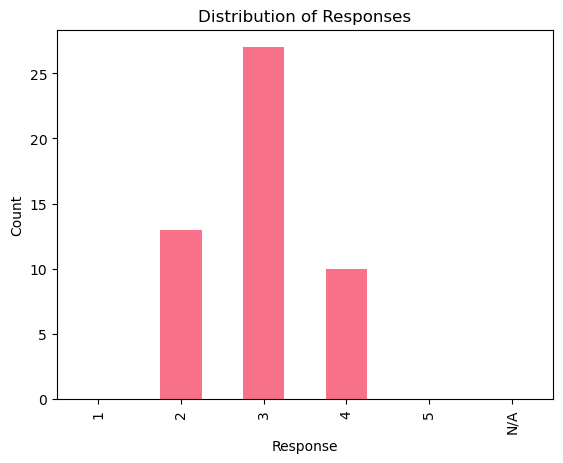

In [30]:
df_es["response"].value_counts().reindex(["1", "2", "3", "4", "5", "N/A"]).plot(kind='bar')
plt.xlabel('Response')
plt.ylabel('Count')
plt.title('Distribution of Responses')

In [31]:
# compute the average and std scores
average_score_es = df_es["response"].replace("N/A", pd.NA).astype(float).mean()
std_score_es = df_es["response"].replace("N/A", pd.NA).astype(float).std()
print(f"Average score: {average_score_es:.2f}")
print(f"Standard deviation of scores: {std_score_es:.2f}")

Average score: 2.94
Standard deviation of scores: 0.68


In [32]:
is_there_a_good_market(df_es)

Percentage of positive responses (4-5): 20.00%
Percentage of neutral responses (3): 54.00%
Percentage of negative responses (1-2): 26.00%
Percentage of 'N/A' responses: 0.00%
Mean response: 2.94
Standard deviation of responses: 0.68
VERDICT: There is a good market for bottled gazpacho.


True

So how the target market compares with the Spanish benchmark?

In [33]:
# compare df with df_es

# % of positive responses (3-4)
percentage_positive = df["response"].astype(str).isin(["4", "5"]).mean()
percentage_positive_es = df_es["response"].astype(str).isin(["4", "5"]).mean()
print(f"Percentage of positive responses (4-5) in the target market: {percentage_positive:.2%}")
print(f"Percentage of positive responses (4-5) in Spain: {percentage_positive_es:.2%}")
# how much more likely are people in Spain to buy the product?
if percentage_positive > 0:
    print(f"Spanish people are {percentage_positive_es / percentage_positive:.2f} times more likely to positively rate the product.")

# % of negative responses (0-1)
percentage_negative = df["response"].astype(str).isin(["1", "2"]).mean()
percentage_negative_es = df_es["response"].astype(str).isin(["1", "2"]).mean()
print(f"Percentage of negative responses (1-2) in the target market: {percentage_negative:.2%}")
print(f"Percentage of negative responses (1-2) in Spain: {percentage_negative_es:.2%}")
# how much more likely are people in Spain to negatively rate the product?
if percentage_negative > 0:
    print(f"Spanish people are {percentage_negative_es / percentage_negative:.2f} times more likely to negatively rate the product.")

Percentage of positive responses (4-5) in the target market: 0.00%
Percentage of positive responses (4-5) in Spain: 20.00%
Percentage of negative responses (1-2) in the target market: 70.45%
Percentage of negative responses (1-2) in Spain: 26.00%
Spanish people are 0.37 times more likely to negatively rate the product.


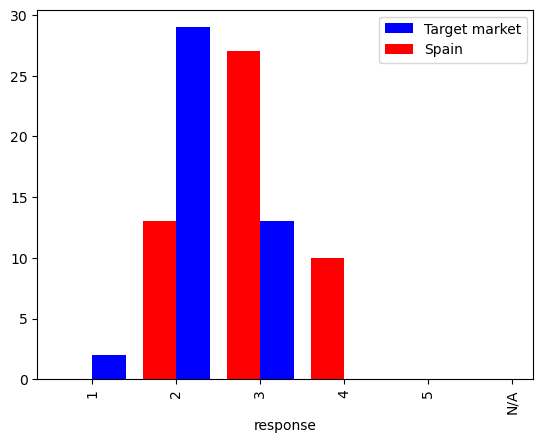

In [34]:
# compare charts. Put both bars in the same plot, for easier comparison
# Need to order the labels in the chart.
fig, ax = plt.subplots()
df["response"].value_counts().reindex(["1", "2", "3", "4", "5", "N/A"]).plot(kind='bar', color='blue', position=0, width=0.4, label="Target market", ax=ax)
df_es["response"].value_counts().reindex(["1", "2", "3", "4", "5", "N/A"]).plot(kind='bar', color='red', position=1, width=0.4, label="Spain", ax=ax)
plt.legend()
plt.show()


In [35]:
#control.end()